**Processed Data**

In [6]:
import pandas as pd
import numpy as np
from datetime import datetime
from google.colab import files

# Step 1: Upload file to Colab
df = pd.read_csv('HRDataset_v14.csv')

# Print initial shape
print(f"Original dataset shape: {df.shape}")

# Step 3: Drop unnecessary columns
columns_to_drop = [
    'Employee_Name', 'EmpID', 'MarriedID', 'MaritalStatusID', 'GenderID',
    'DeptID', 'PerfScoreID', 'PositionID', 'State', 'Zip', 'Termd',
    'DateofTermination', 'TermReason', 'ManagerName', 'ManagerID', 'EmpStatusID'
    # We'll keep LastPerformanceReview_Date for reference and drop it later
]

df_clean = df.drop(columns=columns_to_drop)
print(f"Dataset shape after dropping columns: {df_clean.shape}")

# Step 4: Function to convert date strings to datetime with proper century handling
def parse_date(date_str):
    if pd.isna(date_str):
        return None

    # Handle the format and ensure proper century for 2-digit years
    try:
        # First try with explicit format MM/DD/YY where YY is properly interpreted
        # (20YY if YY < 50, 19YY if YY >= 50)
        parts = date_str.split('/')
        if len(parts) == 3:
            month, day, year = int(parts[0]), int(parts[1]), parts[2]

            # Handle 2-digit years properly
            if len(year) == 2:
                year_int = int(year)
                # Adjust century - assume 1900s for birth years
                # This assumes no one in the dataset was born after 2000
                full_year = 1900 + year_int

                # Reconstruct the date string with 4-digit year
                date_str = f"{month}/{day}/{full_year}"
                return datetime.strptime(date_str, '%m/%d/%Y')
            else:
                # It's already a 4-digit year
                return datetime.strptime(date_str, '%m/%d/%Y')
    except Exception as e:
        # If the primary approach fails, try alternative formats
        formats = ['%m/%d/%Y', '%d/%m/%Y']
        for fmt in formats:
            try:
                return datetime.strptime(date_str, fmt)
            except ValueError:
                continue

    # If none of the formats work, print the problematic date and return None
    print(f"Could not parse date: {date_str}")
    return None

# Step 5: Parse the LastPerformanceReview_Date to use as reference date
# First, parse the review date
df_clean['Review_Date_parsed'] = df_clean['LastPerformanceReview_Date'].apply(parse_date)

# Check for any issues with review dates
print("\nSample of parsed review dates:")
sample_review_dates = pd.DataFrame({
    'Original': df_clean['LastPerformanceReview_Date'].head(10),
    'Parsed': df_clean['Review_Date_parsed'].head(10)
})
print(sample_review_dates)

# For records with missing review dates, use current date as fallback
current_date = datetime.now()
df_clean['Reference_Date'] = df_clean['Review_Date_parsed'].fillna(current_date)

# Step 6: Convert DOB to age as of the last performance review
# Apply the date parsing function to DOB column
df_clean['DOB_parsed'] = df_clean['DOB'].apply(parse_date)

# Display a sample of parsed dates for verification
print("\nSample of parsed DOB dates:")
sample_dates = pd.DataFrame({
    'Original': df_clean['DOB'].head(10),
    'Parsed': df_clean['DOB_parsed'].head(10)
})
print(sample_dates)

# Calculate age in years as of review date
df_clean['Age'] = df_clean.apply(
    lambda row: np.nan if row['DOB_parsed'] is None else
                (row['Reference_Date'] - row['DOB_parsed']).days / 365.25,
    axis=1
)

# Round age to nearest integer
df_clean['Age'] = df_clean['Age'].round().astype('Int64')

# Verify no negative ages
negative_ages = df_clean[df_clean['Age'] < 0]
if len(negative_ages) > 0:
    print(f"\nWARNING: {len(negative_ages)} records have negative ages. Setting them to NaN.")
    df_clean.loc[df_clean['Age'] < 0, 'Age'] = np.nan

# Drop the intermediate parsed DOB column and original DOB
df_clean = df_clean.drop(columns=['DOB_parsed', 'DOB'])

# Step 7: Convert DateofHire to tenure (years of service as of review date)
# Apply the date parsing function to DateofHire column
df_clean['DateofHire_parsed'] = df_clean['DateofHire'].apply(parse_date)

# Display a sample of parsed hire dates for verification
print("\nSample of parsed hire dates:")
sample_hire_dates = pd.DataFrame({
    'Original': df_clean['DateofHire'].head(10),
    'Parsed': df_clean['DateofHire_parsed'].head(10)
})
print(sample_hire_dates)

# Calculate tenure in years as of review date
df_clean['Tenure_Years'] = df_clean.apply(
    lambda row: np.nan if row['DateofHire_parsed'] is None else
                (row['Reference_Date'] - row['DateofHire_parsed']).days / 365.25,
    axis=1
)

# Round tenure to 1 decimal place
df_clean['Tenure_Years'] = df_clean['Tenure_Years'].round(1)

# Verify no negative tenure
negative_tenure = df_clean[df_clean['Tenure_Years'] < 0]
if len(negative_tenure) > 0:
    print(f"\nWARNING: {len(negative_tenure)} records have negative tenure. Setting them to NaN.")
    df_clean.loc[df_clean['Tenure_Years'] < 0, 'Tenure_Years'] = np.nan

# Drop the intermediate columns we no longer need
df_clean = df_clean.drop(columns=[
    'DateofHire_parsed',
    'DateofHire',
    'Review_Date_parsed',
    'LastPerformanceReview_Date',
    'Reference_Date'
])

# Step 7: Display the processed dataset
print("\nFirst few rows of the processed dataset:")
print(df_clean.head())

# Step 8: Display column information
print("\nColumn information:")
print(df_clean.info())

# Step 9: Check for missing values
print("\nMissing values per column:")
print(df_clean.isnull().sum())

# Step 10: Get distribution of the target variable
print("\nDistribution of PerformanceScore:")
print(df_clean['PerformanceScore'].value_counts())

# Optional: Save the processed dataset
df_clean.to_csv('HR_data_processed_1.csv', index=False)
print("\nProcessed dataset saved as 'HR_data_processed_1.csv'")

# Display the columns that remain in the dataset
print("\nRemaining columns in the dataset:")
for i, col in enumerate(df_clean.columns, 1):
    print(f"{i}. {col}")

Original dataset shape: (311, 36)
Dataset shape after dropping columns: (311, 20)

Sample of parsed review dates:
    Original     Parsed
0  1/17/2019 2019-01-17
1  2/24/2016 2016-02-24
2  5/15/2012 2012-05-15
3   1/3/2019 2019-01-03
4   2/1/2016 2016-02-01
5   1/7/2019 2019-01-07
6   1/2/2019 2019-01-02
7  2/25/2019 2019-02-25
8  1/25/2019 2019-01-25
9  2/18/2019 2019-02-18

Sample of parsed DOB dates:
   Original     Parsed
0  07/10/83 1983-07-10
1  05/05/75 1975-05-05
2  09/19/88 1988-09-19
3  09/27/88 1988-09-27
4  09/08/89 1989-09-08
5  05/22/77 1977-05-22
6  05/24/79 1979-05-24
7  02/18/83 1983-02-18
8  02/11/70 1970-02-11
9  01/07/88 1988-01-07

Sample of parsed hire dates:
     Original     Parsed
0    7/5/2011 2011-07-05
1   3/30/2015 2015-03-30
2    7/5/2011 2011-07-05
3    1/7/2008 2008-01-07
4   7/11/2011 2011-07-11
5    1/9/2012 2012-01-09
6  11/10/2014 2014-11-10
7   9/30/2013 2013-09-30
8    7/6/2009 2009-07-06
9    1/5/2015 2015-01-05


First few rows of the processed d

**Preprocessed Data**

Dataset shape: (311, 19)

First 5 rows:


FromDiversityJobFairID  Salary                  Position Sex MaritalDesc  \
0                       0   62506   Production Technician I  M       Single   
1                       0  104437                   Sr. DBA  M      Married   
2                       0   64955  Production Technician II   F     Married   
3                       0   64991   Production Technician I   F     Married   
4                       0   50825   Production Technician I   F    Divorced   

  CitizenDesc HispanicLatino RaceDesc        EmploymentStatus  \
0  US Citizen             No    White                  Active   
1  US Citizen             No    White  Voluntarily Terminated   
2  US Citizen             No    White  Voluntarily Terminated   
3  US Citizen             No    White                  Active   
4  US Citizen             No    White  Voluntarily Terminated   

          Department RecruitmentSource PerformanceScore  EngagementSurvey  \
0  Production                 LinkedIn          Exceeds              4.60   
1              IT/IS            Indeed      Fully Meets              4.96   
2  Production                 LinkedIn      Fully Meets              3.02   
3  Production                   Indeed      Fully Meets              4.84   
4  Production            Google Search      Fully Meets              5.00   

   EmpSatisfaction  SpecialProjectsCount  DaysLateLast30  Absences  Age  \
0                5                     0               0         1   36   
1                3                     6               0        17   41   
2                3                     0               0         3   24   
3                5                     0               0        15   30   
4                4                     0               0         2   26   

   Tenure_Years  
0           7.5  
1           0.9  
2           0.9  
3          11.0  
4           4.6


Data types:


FromDiversityJobFairID      int64
Salary                      int64
Position                   object
Sex                        object
MaritalDesc                object
CitizenDesc                object
HispanicLatino             object
RaceDesc                   object
EmploymentStatus           object
Department                 object
RecruitmentSource          object
PerformanceScore           object
EngagementSurvey          float64
EmpSatisfaction             int64
SpecialProjectsCount        int64
DaysLateLast30              int64
Absences                    int64
Age                         int64
Tenure_Years              float64
dtype: object


Summary statistics:


FromDiversityJobFairID         Salary  EngagementSurvey  \
count              311.000000     311.000000        311.000000   
mean                 0.093248   69020.684887          4.110000   
std                  0.291248   25156.636930          0.789938   
min                  0.000000   45046.000000          1.120000   
25%                  0.000000   55501.500000          3.690000   
50%                  0.000000   62810.000000          4.280000   
75%                  0.000000   72036.000000          4.700000   
max                  1.000000  250000.000000          5.000000   

       EmpSatisfaction  SpecialProjectsCount  DaysLateLast30    Absences  \
count       311.000000            311.000000      311.000000  311.000000   
mean          3.890675              1.218650        0.414791   10.237942   
std           0.909241              2.349421        1.294519    5.852596   
min           1.000000              0.000000        0.000000    1.000000   
25%           3.000000              0.000000        0.000000    5.000000   
50%           4.000000              0.000000        0.000000   10.000000   
75%           5.000000              0.000000        0.000000   15.000000   
max           5.000000              8.000000        6.000000   20.000000   

             Age  Tenure_Years  
count  311.00000    309.000000  
mean    38.59164      4.632686  
std      8.96573      2.266985  
min     23.00000      0.100000  
25%     32.00000      3.200000  
50%     37.00000      4.500000  
75%     43.50000      6.100000  
max     68.00000     13.000000


Checking for missing values:
Tenure_Years    2
dtype: int64

Missing values after handling:
0
Created 5 one-hot encoded features for MaritalDesc
Created 3 one-hot encoded features for CitizenDesc
Created 6 one-hot encoded features for RaceDesc
Created 6 one-hot encoded features for Department
Created 9 one-hot encoded features for RecruitmentSource
FromDiversityJobFairID is already binary

Salary - Original: min=45046, max=250000
Salary_Scaled: min=0.0, max=0.9999999999999999

EngagementSurvey - Original: min=1.12, max=5.0
EngagementSurvey_Scaled: min=0.0, max=1.0

EmpSatisfaction - Original: min=1, max=5
EmpSatisfaction_Scaled: min=0.0, max=1.0

Age - Original: min=23, max=68
Age_Scaled: min=0.0, max=0.9999999999999999

Tenure_Years - Original: min=0.1, max=13.0
Tenure_Years_Scaled: min=0.0, max=1.0

Final DataFrame shape: (311, 57)
Added 38 new features

New columns (38):
['HispanicLatino_Encoded', 'Sex_Encoded', 'EmploymentStatus_Encoded', 'PerformanceScore_Encoded', 'MaritalDesc_D

<ipython-input-7-e0dc9507907f>:40: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True)


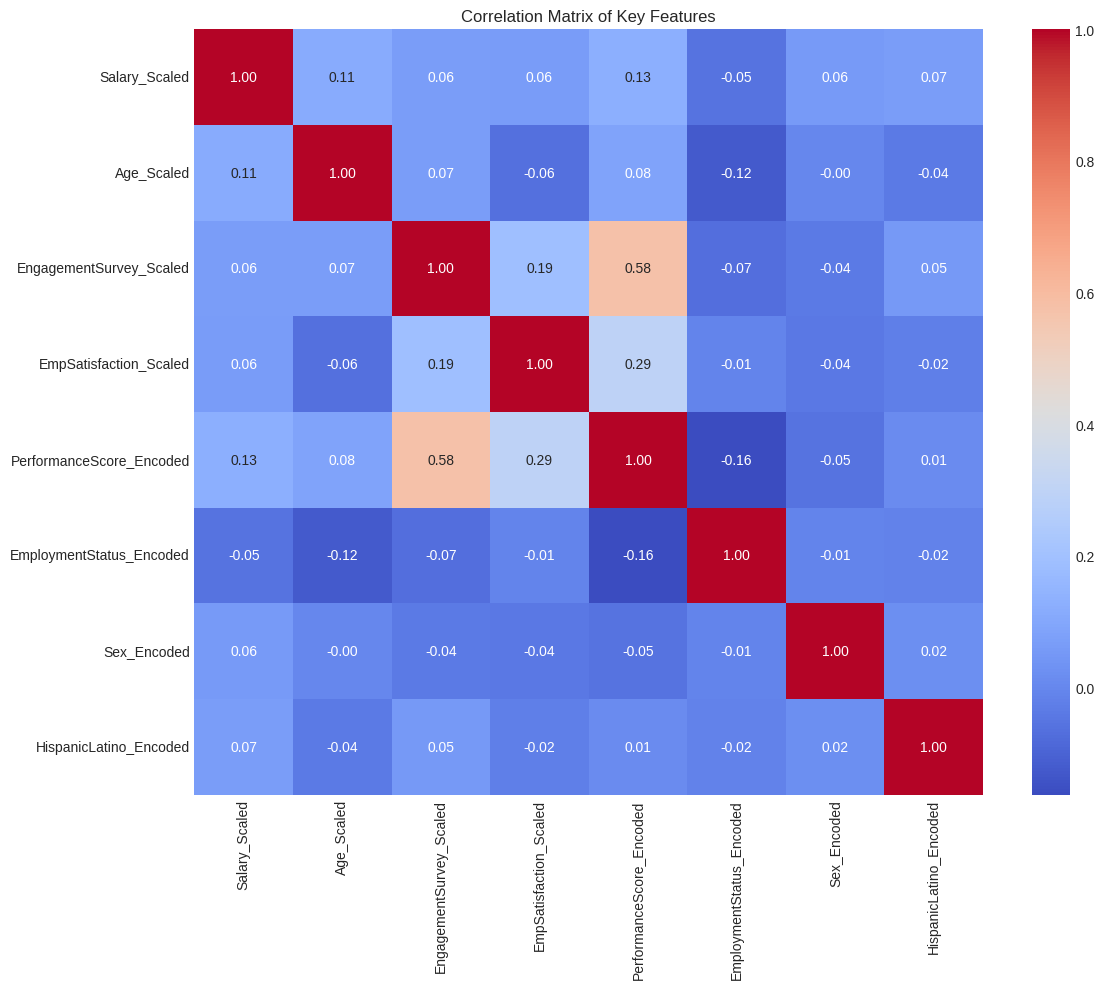


Preprocessed data saved to HR_data_preprocessed.csv
Encoded-only data saved to HR_data_encoded.csv

Data preprocessing complete!

Click below to download the preprocessed files:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [7]:
# HR Data Preprocessing
# For Google Colab (without Drive, using local files)

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load data from local Colab environment
# Assuming you've uploaded the file directly to Colab using the file browser
file_path = 'HR_data_processed_1.csv'
df = pd.read_csv(file_path)

# Display basic information about the dataset
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
display(df.head())

print("\nData types:")
display(df.dtypes)

print("\nSummary statistics:")
display(df.describe())

print("\nChecking for missing values:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

# ----------------------------------------------------------------
# 1. Handle Missing Values
# ----------------------------------------------------------------

# Check if we have any missing values
if df.isnull().sum().sum() > 0:
    # For numerical columns, fill with mean
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    for col in numeric_cols:
        if df[col].isnull().sum() > 0:
            df[col].fillna(df[col].mean(), inplace=True)

    # For categorical columns, fill with mode
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        if df[col].isnull().sum() > 0:
            df[col].fillna(df[col].mode()[0], inplace=True)

# Check again to confirm no missing values
print("\nMissing values after handling:")
print(df.isnull().sum().sum())

# ----------------------------------------------------------------
# 2. Data Cleaning (If needed)
# ----------------------------------------------------------------

# Fix inconsistent HispanicLatino values
if 'HispanicLatino' in df.columns:
    # Check for lowercase variants
    if df['HispanicLatino'].str.lower().isin(['yes', 'no']).any():
        df['HispanicLatino'] = df['HispanicLatino'].str.capitalize()

# Fix any spaces in Sex column if needed
if 'Sex' in df.columns and df['Sex'].dtype == 'object':
    df['Sex'] = df['Sex'].str.strip()

# Check for negative values in Age (as seen in the earlier analysis)
if 'Age' in df.columns:
    if (df['Age'] < 0).any():
        print(f"Found {(df['Age'] < 0).sum()} negative Age values. Converting to absolute values.")
        df['Age'] = df['Age'].abs()

# ----------------------------------------------------------------
# 3. Encoding Categorical Variables
# ----------------------------------------------------------------

# a) Label Encoding
# ------------------

# HispanicLatino (Yes=1, No=0)
if 'HispanicLatino' in df.columns:
    df['HispanicLatino_Encoded'] = df['HispanicLatino'].map({'Yes': 1, 'No': 0})
    # Handle any missing mappings if they exist
    if df['HispanicLatino_Encoded'].isnull().any():
        print("Warning: Some values in HispanicLatino couldn't be mapped.")
        df['HispanicLatino_Encoded'] = df['HispanicLatino_Encoded'].fillna(0)

# Sex (M=1, F=0)
if 'Sex' in df.columns:
    df['Sex_Encoded'] = df['Sex'].map({'M': 1, 'F': 0})
    # Handle any missing mappings
    if df['Sex_Encoded'].isnull().any():
        print("Warning: Some values in Sex couldn't be mapped.")
        df['Sex_Encoded'] = df['Sex_Encoded'].fillna(0)

# EmploymentStatus (Active=1, Voluntarily Terminated=2, Terminated for Cause=3)
if 'EmploymentStatus' in df.columns:
    status_map = {
        'Active': 1,
        'Voluntarily Terminated': 2,
        'Terminated for Cause': 3
    }
    df['EmploymentStatus_Encoded'] = df['EmploymentStatus'].map(status_map)
    # Handle any missing mappings
    if df['EmploymentStatus_Encoded'].isnull().any():
        print("Warning: Some values in EmploymentStatus couldn't be mapped.")
        most_common = df['EmploymentStatus'].mode()[0]
        df['EmploymentStatus_Encoded'] = df['EmploymentStatus_Encoded'].fillna(status_map.get(most_common, 1))

# PerformanceScore (highest to lowest)
if 'PerformanceScore' in df.columns:
    # Ordering from highest to lowest
    perf_map = {
        'Exceeds': 4,
        'Fully Meets': 3,
        'Needs Improvement': 2,
        'PIP': 1
    }
    df['PerformanceScore_Encoded'] = df['PerformanceScore'].map(perf_map)
    # Handle any missing mappings
    if df['PerformanceScore_Encoded'].isnull().any():
        print("Warning: Some values in PerformanceScore couldn't be mapped.")
        most_common = df['PerformanceScore'].mode()[0]
        df['PerformanceScore_Encoded'] = df['PerformanceScore_Encoded'].fillna(perf_map.get(most_common, 3))

# b) One-Hot Encoding
# ------------------

# List of columns to one-hot encode
one_hot_cols = ['MaritalDesc', 'CitizenDesc', 'RaceDesc', 'Department', 'RecruitmentSource']

# Clean strings by stripping spaces
for col in one_hot_cols:
    if col in df.columns and df[col].dtype == 'object':
        df[col] = df[col].str.strip()

# Apply one-hot encoding
for col in one_hot_cols:
    if col in df.columns:
        # Create dummy variables (one-hot encoding)
        dummies = pd.get_dummies(df[col], prefix=col, drop_first=False)

        # Add the dummy variables to the dataframe
        df = pd.concat([df, dummies], axis=1)

        print(f"Created {dummies.shape[1]} one-hot encoded features for {col}")

# c) Binary Encoding
# ------------------

# FromDiversityJobFairID (already binary, but verify)
if 'FromDiversityJobFairID' in df.columns:
    # Check if it's already binary
    unique_values = df['FromDiversityJobFairID'].unique()
    if set(unique_values) == {0, 1} or set(unique_values) == {0.0, 1.0}:
        print("FromDiversityJobFairID is already binary")
    else:
        print(f"Warning: FromDiversityJobFairID has values {unique_values} - converting to binary")
        le = LabelEncoder()
        df['FromDiversityJobFairID'] = le.fit_transform(df['FromDiversityJobFairID'])

# EmpStatusID (if multiple values)
if 'EmpStatusID' in df.columns:
    # Check number of unique values
    unique_count = df['EmpStatusID'].nunique()
    print(f"EmpStatusID has {unique_count} unique values")

    if unique_count > 2:
        # We could one-hot encode this if it has just a few values
        if unique_count <= 10:  # threshold for one-hot encoding
            dummies = pd.get_dummies(df['EmpStatusID'], prefix='EmpStatusID', drop_first=False)
            df = pd.concat([df, dummies], axis=1)
            print(f"Created {dummies.shape[1]} one-hot encoded features for EmpStatusID")
        else:
            # Otherwise use label encoding
            le = LabelEncoder()
            df['EmpStatusID_Encoded'] = le.fit_transform(df['EmpStatusID'])
            print(f"Label encoded EmpStatusID with {unique_count} categories")
    elif unique_count == 2:
        print("EmpStatusID is already binary")
    else:
        print("EmpStatusID has only one value, no encoding needed")

# d) Min-Max Scaling
# ------------------

# Columns to scale
scale_cols = ['Salary', 'EngagementSurvey', 'EmpSatisfaction', 'Age', 'Tenure_Years']

# Initialize the scaler
scaler = MinMaxScaler()

# Apply scaling to specified columns
for col in scale_cols:
    if col in df.columns:
        # Create a new column with scaled values
        df[f'{col}_Scaled'] = scaler.fit_transform(df[[col]])

        # Display min and max of original and scaled
        print(f"\n{col} - Original: min={df[col].min()}, max={df[col].max()}")
        print(f"{col}_Scaled: min={df[f'{col}_Scaled'].min()}, max={df[f'{col}_Scaled'].max()}")

# ----------------------------------------------------------------
# 4. Final Summary
# ----------------------------------------------------------------

print("\nFinal DataFrame shape:", df.shape)
print(f"Added {df.shape[1] - len(pd.read_csv(file_path).columns)} new features")

# List of all new encoded/scaled columns
new_cols = [col for col in df.columns if any(suffix in col for suffix in ['_Encoded', '_Scaled', 'Department_', 'MaritalDesc_',
                                                                           'CitizenDesc_', 'RaceDesc_', 'RecruitmentSource_'])]
print(f"\nNew columns ({len(new_cols)}):")
print(new_cols[:10])  # Show first 10 if there are many
if len(new_cols) > 10:
    print(f"...and {len(new_cols)-10} more")

# ----------------------------------------------------------------
# 5. Data Visualization
# ----------------------------------------------------------------

# Plot correlation matrix for important variables
important_cols = [
    'Salary_Scaled', 'Age_Scaled', 'EngagementSurvey_Scaled',
    'EmpSatisfaction_Scaled', 'PerformanceScore_Encoded',
    'EmploymentStatus_Encoded', 'Sex_Encoded', 'HispanicLatino_Encoded'
]

# Filter to include only columns that exist in the dataframe
important_cols = [col for col in important_cols if col in df.columns]

if len(important_cols) > 0:
    plt.figure(figsize=(12, 10))
    correlation = df[important_cols].corr()
    sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix of Key Features')
    plt.tight_layout()
    plt.show()

# ----------------------------------------------------------------
# 6. Save the preprocessed data
# ----------------------------------------------------------------

# Save the data locally in Colab
output_path = 'HR_data_preprocessed.csv'
df.to_csv(output_path, index=False)
print(f"\nPreprocessed data saved to {output_path}")

# Also save a version with only the encoded/transformed columns
encoded_df = df.drop(columns=[col for col in df.columns if not any(suffix in col for suffix in ['_Encoded', '_Scaled']) and col not in ['EmpID']])
encoded_output_path = 'HR_data_encoded.csv'
encoded_df.to_csv(encoded_output_path, index=False)
print(f"Encoded-only data saved to {encoded_output_path}")

print("\nData preprocessing complete!")

# Note: If you want to download the files to your local machine
# Display links to download the files
from google.colab import files
print("\nClick below to download the preprocessed files:")
files.download(output_path)
files.download(encoded_output_path)

**transformed data**

Dataset loaded successfully with shape: (311, 57)

First 5 rows:
   FromDiversityJobFairID  Salary                  Position Sex MaritalDesc  \
0                       0   62506   Production Technician I   M      Single   
1                       0  104437                   Sr. DBA   M     Married   
2                       0   64955  Production Technician II   F     Married   
3                       0   64991   Production Technician I   F     Married   
4                       0   50825   Production Technician I   F    Divorced   

  CitizenDesc HispanicLatino RaceDesc        EmploymentStatus  Department  \
0  US Citizen             No    White                  Active  Production   
1  US Citizen             No    White  Voluntarily Terminated       IT/IS   
2  US Citizen             No    White  Voluntarily Terminated  Production   
3  US Citizen             No    White                  Active  Production   
4  US Citizen             No    White  Voluntarily Terminated  Production  

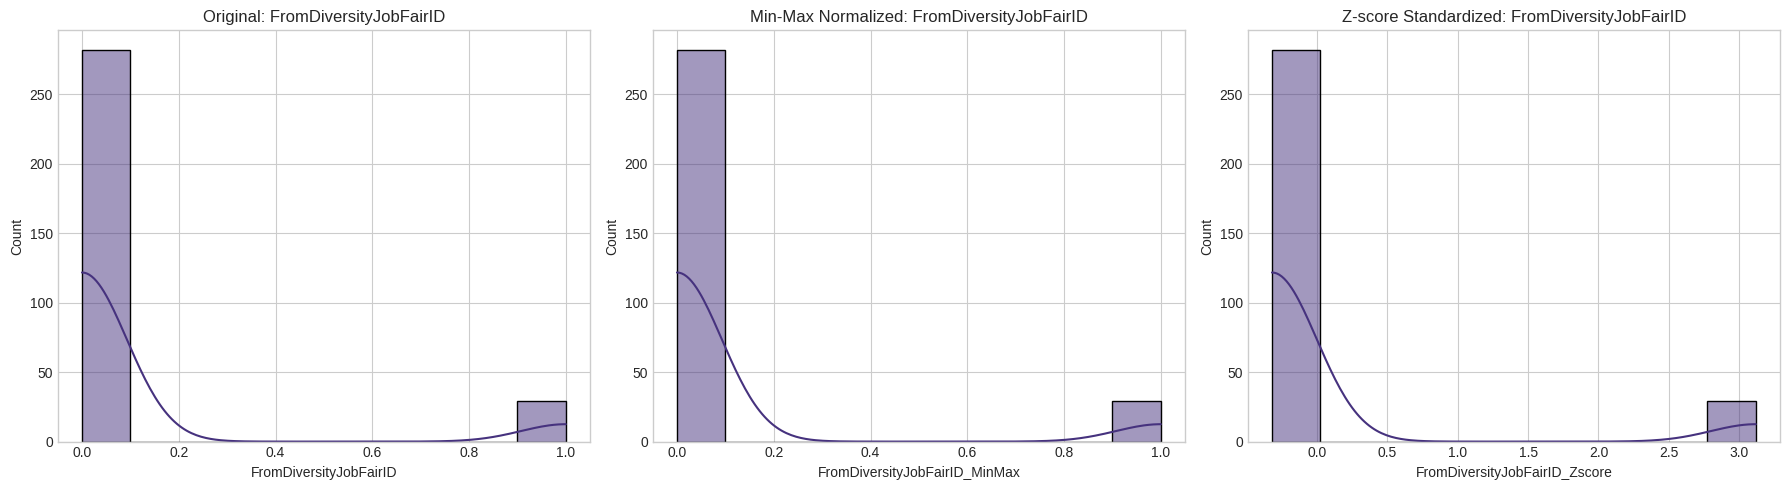

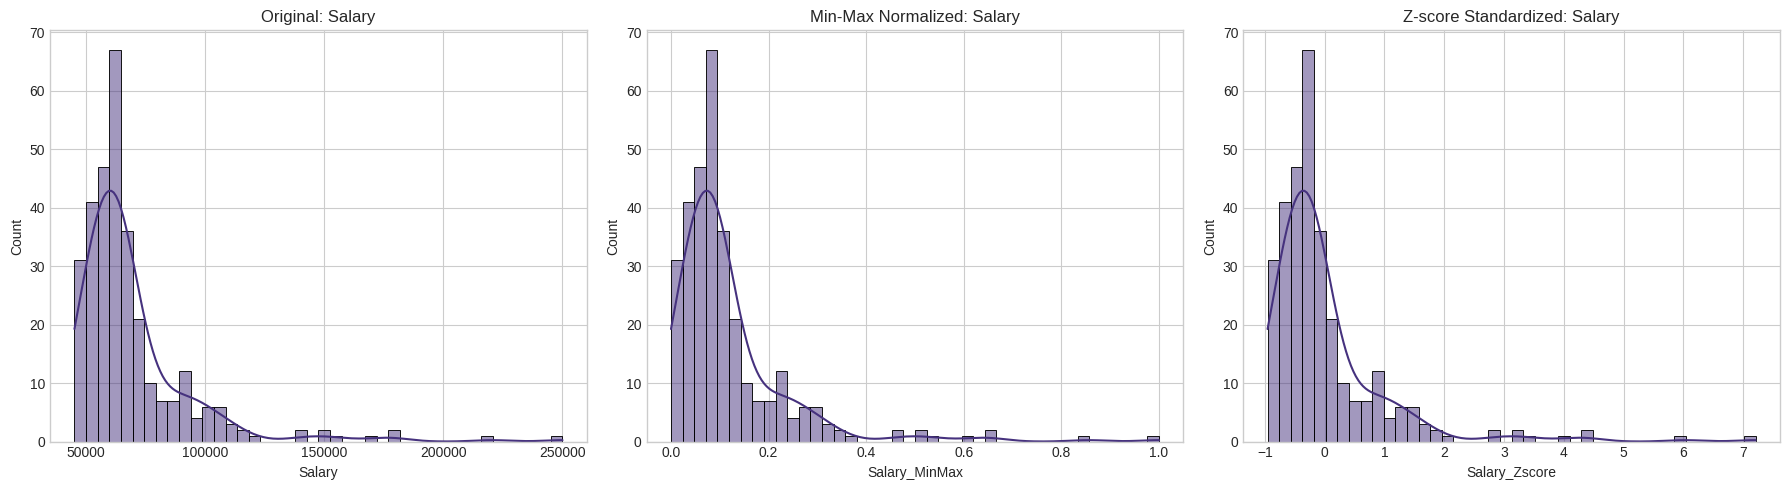

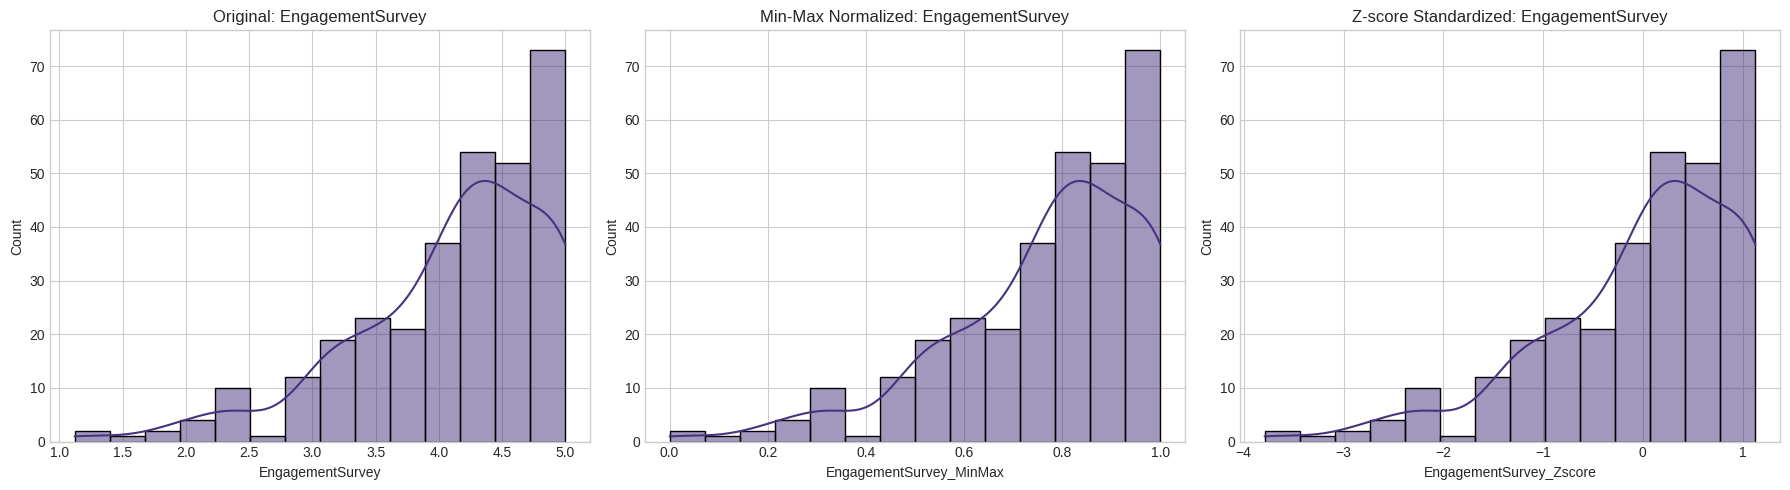

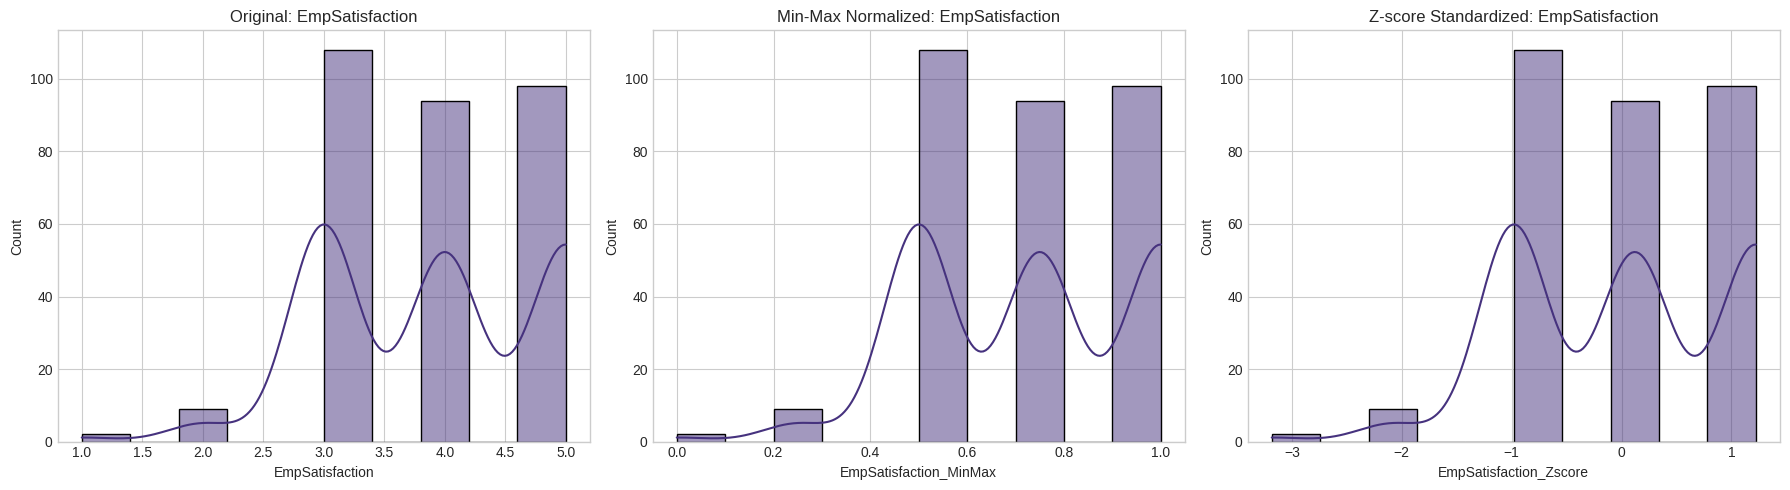

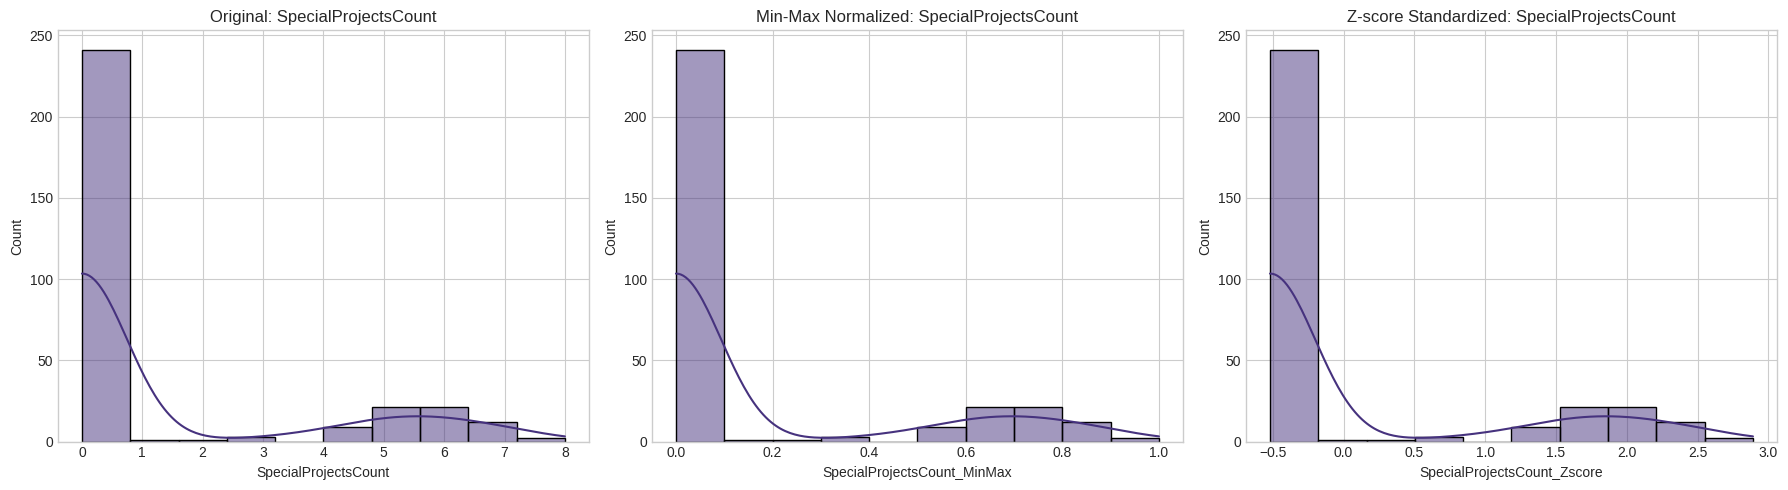


Min-Max normalized data saved to HR_data_normalized.csv
Z-score standardized data saved to HR_data_standardized.csv
Combined dataset with all transformations saved to HR_data_all_transformations.csv

===== SUMMARY =====
Transformation of numeric features complete!
- Applied Min-Max normalization to 9 columns
- Applied Z-score standardization to 9 columns
- Created visualizations comparing original and transformed distributions
- Saved three versions of the dataset

===== RECOMMENDATIONS =====
1. Use Min-Max normalized features (range [0,1]) when:
   - You need bounded values
   - Working with algorithms that require features in a specific range (e.g., neural networks)
   - Original data is not normally distributed

2. Use Z-score standardized features (mean=0, std=1) when:
   - Working with algorithms sensitive to feature magnitudes (e.g., SVM, PCA, K-means)
   - Features have different units/scales
   - Looking for outliers (values with abs(z) > 3)
   - Original data is approximately

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [8]:
# HR Data Normalization and Standardization
# This script normalizes and standardizes numeric features in the HR dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')

# Load the preprocessed HR data
df = pd.read_csv('HR_data_preprocessed.csv')

print("Dataset loaded successfully with shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())

# Identify numeric columns
# Exclude columns that are already normalized/scaled (ending with _Scaled or _Encoded)
# or categorical columns that have been one-hot encoded
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
numeric_cols = [col for col in numeric_cols if not (
    col.endswith('_Scaled') or
    col.endswith('_Encoded') or
    col.startswith('Department_') or
    col.startswith('MaritalDesc_') or
    col.startswith('CitizenDesc_') or
    col.startswith('RaceDesc_') or
    col.startswith('RecruitmentSource_') or
    col.startswith('EmpStatusID_')
)]

print(f"\nNumeric columns to normalize/standardize ({len(numeric_cols)}):")
print(numeric_cols)

# Create a copy of the dataframe to avoid modifying the original
df_transformed = df.copy()

# 1. Min-Max Normalization (scaling to [0,1] range)
# ------------------------------------------------
print("\n1. Applying Min-Max Normalization...")

# Initialize the Min-Max scaler
min_max_scaler = MinMaxScaler()

# Create a new dataframe for normalized values
df_normalized = df.copy()

# Apply Min-Max scaling to each numeric column
for col in numeric_cols:
    # Reshape data for scikit-learn
    col_data = df[[col]].values

    # Fit and transform the data
    normalized_data = min_max_scaler.fit_transform(col_data)

    # Add to the normalized dataframe with a suffix
    df_normalized[f"{col}_MinMax"] = normalized_data

    # Print statistics
    print(f"  {col}: Original range [{df[col].min():.2f}, {df[col].max():.2f}] → Normalized range [{df_normalized[f'{col}_MinMax'].min():.2f}, {df_normalized[f'{col}_MinMax'].max():.2f}]")

# 2. Z-score Standardization (mean=0, std=1)
# ---------------------------------------
print("\n2. Applying Z-score Standardization...")

# Initialize the StandardScaler
std_scaler = StandardScaler()

# Create a new dataframe for standardized values
df_standardized = df.copy()

# Apply standardization to each numeric column
for col in numeric_cols:
    # Reshape data for scikit-learn
    col_data = df[[col]].values

    # Fit and transform the data
    standardized_data = std_scaler.fit_transform(col_data)

    # Add to the standardized dataframe with a suffix
    df_standardized[f"{col}_Zscore"] = standardized_data

    # Print statistics
    print(f"  {col}: Original (mean={df[col].mean():.2f}, std={df[col].std():.2f}) → Standardized (mean={df_standardized[f'{col}_Zscore'].mean():.2f}, std={df_standardized[f'{col}_Zscore'].std():.2f})")

# 3. Combine transformations into one dataframe
# ---------------------------------------------
# Create a combined dataframe with original and all transformed columns
df_combined = df.copy()

# Add Min-Max normalized columns
for col in numeric_cols:
    df_combined[f"{col}_MinMax"] = df_normalized[f"{col}_MinMax"]

# Add Z-score standardized columns
for col in numeric_cols:
    df_combined[f"{col}_Zscore"] = df_standardized[f"{col}_Zscore"]

# 4. Visualize the transformations
# -------------------------------
print("\n4. Visualizing transformations...")

# Select a few representative columns to visualize
if len(numeric_cols) > 5:
    viz_cols = numeric_cols[:5]  # First 5 columns
else:
    viz_cols = numeric_cols

for col in viz_cols:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Original data
    sns.histplot(df[col], kde=True, ax=axes[0])
    axes[0].set_title(f'Original: {col}')

    # Min-Max Normalized
    sns.histplot(df_normalized[f"{col}_MinMax"], kde=True, ax=axes[1])
    axes[1].set_title(f'Min-Max Normalized: {col}')

    # Z-score Standardized
    sns.histplot(df_standardized[f"{col}_Zscore"], kde=True, ax=axes[2])
    axes[2].set_title(f'Z-score Standardized: {col}')

    plt.tight_layout()
    plt.show()

# 5. Save the transformed datasets
# -------------------------------
# Save normalized dataset
normalized_output_path = 'HR_data_normalized.csv'
df_normalized.to_csv(normalized_output_path, index=False)
print(f"\nMin-Max normalized data saved to {normalized_output_path}")

# Save standardized dataset
standardized_output_path = 'HR_data_standardized.csv'
df_standardized.to_csv(standardized_output_path, index=False)
print(f"Z-score standardized data saved to {standardized_output_path}")

# Save combined dataset
combined_output_path = 'HR_data_all_transformations.csv'
df_combined.to_csv(combined_output_path, index=False)
print(f"Combined dataset with all transformations saved to {combined_output_path}")

# 6. Print summary and recommendations
# ----------------------------------
print("\n===== SUMMARY =====")
print("Transformation of numeric features complete!")
print(f"- Applied Min-Max normalization to {len(numeric_cols)} columns")
print(f"- Applied Z-score standardization to {len(numeric_cols)} columns")
print("- Created visualizations comparing original and transformed distributions")
print("- Saved three versions of the dataset")

print("\n===== RECOMMENDATIONS =====")
print("1. Use Min-Max normalized features (range [0,1]) when:")
print("   - You need bounded values")
print("   - Working with algorithms that require features in a specific range (e.g., neural networks)")
print("   - Original data is not normally distributed")

print("\n2. Use Z-score standardized features (mean=0, std=1) when:")
print("   - Working with algorithms sensitive to feature magnitudes (e.g., SVM, PCA, K-means)")
print("   - Features have different units/scales")
print("   - Looking for outliers (values with abs(z) > 3)")
print("   - Original data is approximately normally distributed")

print("\nTransformation complete!")

# For Google Colab environment - add download capability
try:
    from google.colab import files
    print("\nIn Google Colab environment. Click below to download the transformed files:")
    files.download(normalized_output_path)
    files.download(standardized_output_path)
    files.download(combined_output_path)
except ImportError:
    print("\nNot running in Google Colab. Files saved locally.")

**Cleaned Original Data**

In [9]:
# Step 1: HR Data Preparation and Cleaning
# This script loads the HR data and performs initial cleaning steps

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')

print("="*80)
print("STEP 1: DATA PREPARATION AND CLEANING")
print("="*80)

# 1.1 Load the dataset(s)
print("\n1.1 Loading dataset...")

# Choose one of the available datasets to start with
# You can use HR_data_normalized.csv, HR_data_standardized.csv, or HR_data_all_transformations.csv
file_path = 'HR_data_all_transformations.csv'  # This has the most complete information
df = pd.read_csv(file_path)

print(f"Dataset loaded successfully with {df.shape[0]} rows and {df.shape[1]} columns")

# 1.2 Examine the data structure
print("\n1.2 Examining data structure...")
print("\nFirst 5 rows:")
print(df.head())

print("\nData types:")
print(df.dtypes.value_counts())
print("\nDetailed data types:")
print(df.dtypes)

# 1.3 Check for missing values
print("\n1.3 Checking for missing values...")
missing_values = df.isnull().sum()
if missing_values.sum() > 0:
    print("Columns with missing values:")
    print(missing_values[missing_values > 0])

    # Calculate percentage of missing values
    missing_percentage = (missing_values / len(df)) * 100
    print("\nPercentage of missing values by column:")
    print(missing_percentage[missing_percentage > 0])
else:
    print("No missing values found in the dataset")

# 1.4 Check for duplicates
print("\n1.4 Checking for duplicate rows...")
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

if duplicates > 0:
    print("Removing duplicate rows...")
    df = df.drop_duplicates()
    print(f"Dataset shape after removing duplicates: {df.shape}")

# 1.5 Identify column types
print("\n1.5 Identifying column types...")

# Identify original columns vs transformed columns
original_cols = [col for col in df.columns if not (
    col.endswith('_MinMax') or
    col.endswith('_Zscore') or
    col.endswith('_Encoded') or
    col.endswith('_Scaled') or
    col.startswith('Department_') or
    col.startswith('MaritalDesc_') or
    col.startswith('CitizenDesc_') or
    col.startswith('RaceDesc_') or
    col.startswith('RecruitmentSource_') or
    col.startswith('EmpStatusID_')
)]

# Identify categorical and numerical columns from the original columns
categorical_cols = [col for col in original_cols if df[col].dtype == 'object']
numerical_cols = [col for col in original_cols if df[col].dtype != 'object']

print(f"Original columns ({len(original_cols)}):")
print(original_cols)

print(f"\nCategorical columns ({len(categorical_cols)}):")
print(categorical_cols)

print(f"\nNumerical columns ({len(numerical_cols)}):")
print(numerical_cols)

print(f"\nTotal transformed/encoded columns: {df.shape[1] - len(original_cols)}")

# 1.6 Check for inconsistencies in categorical data
print("\n1.6 Checking for inconsistencies in categorical data...")

for col in categorical_cols:
    unique_values = df[col].unique()
    print(f"\nUnique values in {col} ({len(unique_values)}):")
    print(unique_values)

    # Check for leading/trailing spaces or inconsistent casing
    if df[col].dtype == 'object':
        # Count of values before cleaning
        value_counts_before = df[col].value_counts().shape[0]

        # Clean the column (strip spaces and standardize case)
        df[col] = df[col].str.strip()

        # Count of values after cleaning
        value_counts_after = df[col].value_counts().shape[0]

        if value_counts_before != value_counts_after:
            print(f"  Cleaned {value_counts_before - value_counts_after} inconsistent values in {col}")

# 1.7 Check for outliers in numerical data
print("\n1.7 Checking for outliers in numerical data...")

for col in numerical_cols:
    # Calculate statistics
    stats = df[col].describe()

    # Calculate IQR (Interquartile Range)
    Q1 = stats['25%']
    Q3 = stats['75%']
    IQR = Q3 - Q1

    # Define outlier boundaries
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Count outliers
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].shape[0]
    outlier_percentage = (outliers / len(df)) * 100

    print(f"{col}: {outliers} outliers ({outlier_percentage:.2f}%)")
    print(f"  Range: [{stats['min']:.2f}, {stats['max']:.2f}], IQR: {IQR:.2f}")
    print(f"  Outlier boundaries: [{lower_bound:.2f}, {upper_bound:.2f}]")

# 1.8 Save the cleaned dataset if needed
# Uncomment the following line if you want to save the cleaned dataset
df.to_csv('HR_data_cleaned.csv', index=False)

print("\nData preparation and cleaning complete!")

STEP 1: DATA PREPARATION AND CLEANING

1.1 Loading dataset...
Dataset loaded successfully with 311 rows and 75 columns

1.2 Examining data structure...

First 5 rows:
   FromDiversityJobFairID  Salary                  Position Sex MaritalDesc  \
0                       0   62506   Production Technician I   M      Single   
1                       0  104437                   Sr. DBA   M     Married   
2                       0   64955  Production Technician II   F     Married   
3                       0   64991   Production Technician I   F     Married   
4                       0   50825   Production Technician I   F    Divorced   

  CitizenDesc HispanicLatino RaceDesc        EmploymentStatus  Department  \
0  US Citizen             No    White                  Active  Production   
1  US Citizen             No    White  Voluntarily Terminated       IT/IS   
2  US Citizen             No    White  Voluntarily Terminated  Production   
3  US Citizen             No    White             

**HR_data_transformed_final**

In [10]:
import pandas as pd


# If you've uploaded directly to Colab session
df = pd.read_csv('HR_data_all_transformations.csv')

# Print the original shape
print(f"Original dataframe shape: {df.shape}")

# Columns to drop based on your transformations
columns_to_drop = [
    # Label encoded originals
    'HispanicLatino', 'Sex', 'EmploymentStatus', 'PerformanceScore',

    # One-hot encoded originals
    'MaritalDesc', 'CitizenDesc', 'RaceDesc', 'Department', 'RecruitmentSource',

    # Binary encoded originals
    'FromDiversityJobFairID',

    # Min-Max scaled originals
    'Salary', 'EngagementSurvey', 'EmpSatisfaction', 'Age', 'Tenure_Years'
]

# Drop the original columns
df_transformed = df.drop(columns=columns_to_drop)

# Print the new shape
print(f"Transformed dataframe shape: {df_transformed.shape}")

# Check first few rows to verify
print("\nFirst 5 rows of transformed data:")
print(df_transformed.head())

# Save the transformed dataset
df_transformed.to_csv('HR_data_transformed_final.csv', index=False)
print("\nTransformed dataset saved as 'HR_data_transformed_final.csv'")

Original dataframe shape: (311, 75)
Transformed dataframe shape: (311, 60)

First 5 rows of transformed data:
                   Position  SpecialProjectsCount  DaysLateLast30  Absences  \
0   Production Technician I                     0               0         1   
1                   Sr. DBA                     6               0        17   
2  Production Technician II                     0               0         3   
3   Production Technician I                     0               0        15   
4   Production Technician I                     0               0         2   

   HispanicLatino_Encoded  Sex_Encoded  EmploymentStatus_Encoded  \
0                       0            1                         1   
1                       0            1                         2   
2                       0            0                         2   
3                       0            0                         1   
4                       0            0                         2   

   Per

**Final Cleaned Data**

In [11]:
import pandas as pd

# သင့်ဒေတာစက်ကို ဖွင့်ပါ
df = pd.read_csv('HR_data_transformed_final.csv')

# မူလပုံသဏ္ဍာန်ကို ပြပါ
print(f"မူလပုံသဏ္ဍာန်: {df.shape}")

# ဖျက်ရန် ကော်လံများကို သတ်မှတ်ပါ (၎င်းတို့တွင် ပြောင်းလဲထားသော ဗားရှင်းများရှိပါက)
columns_to_drop = []

# ဤကော်လံများတွင် ပြောင်းလဲထားသော ဗားရှင်းများ (_MinMax, _Scaled, သို့မဟုတ် _Zscore) ရှိမရှိ စစ်ဆေးပါ
numerical_originals = ['SpecialProjectsCount', 'DaysLateLast30', 'Absences']
for col in numerical_originals:
    # ပြောင်းလဲထားသော ဗားရှင်းများ ရှိမရှိ စစ်ဆေးပါ
    minmax_exists = f"{col}_MinMax" in df.columns
    zscore_exists = f"{col}_Zscore" in df.columns

    # ပြောင်းလဲထားသော ဗားရှင်းရှိပါက မူလကို ဖျက်ရန်စာရင်းတွင် ထည့်ပါ
    if minmax_exists or zscore_exists:
        columns_to_drop.append(col)

# သတ်မှတ်ထားသော ကော်လံများကို ဖျက်ပါ
if columns_to_drop:
    df_cleaned = df.drop(columns=columns_to_drop)
    print(f"ဖျက်ထားသော ကော်လံများ: {columns_to_drop}")
else:
    df_cleaned = df
    print("ထပ်ဖျက်ရန် ကော်လံမလိုအပ်ပါ")

# နောက်ဆုံးပုံသဏ္ဍာန်ကို ပြပါ
print(f"နောက်ဆုံးပုံသဏ္ဍာန်: {df_cleaned.shape}")

# သန့်စင်ထားသော ဒေတာစက်ကို သိမ်းဆည်းပါ
df_cleaned.to_csv('final_cleaned_dataset.csv', index=False)
print("ဒေတာစက်ကို 'final_cleaned_dataset.csv' အဖြစ် သိမ်းဆည်းပြီးပါပြီ")

မူလပုံသဏ္ဍာန်: (311, 60)
ဖျက်ထားသော ကော်လံများ: ['SpecialProjectsCount', 'DaysLateLast30', 'Absences']
နောက်ဆုံးပုံသဏ္ဍာန်: (311, 57)
ဒေတာစက်ကို 'final_cleaned_dataset.csv' အဖြစ် သိမ်းဆည်းပြီးပါပြီ


**EDA**

Dataset shape: (311, 57)

=== Descriptive Statistics ===

Numeric Columns Summary:
                               count          mean       std       min  \
HispanicLatino_Encoded         311.0  9.003215e-02  0.286689  0.000000   
Sex_Encoded                    311.0  4.340836e-01  0.496435  0.000000   
EmploymentStatus_Encoded       311.0  1.385852e+00  0.583918  1.000000   
PerformanceScore_Encoded       311.0  2.977492e+00  0.587072  1.000000   
Salary_Scaled                  311.0  1.169759e-01  0.122743  0.000000   
EngagementSurvey_Scaled        311.0  7.706186e-01  0.203592  0.000000   
EmpSatisfaction_Scaled         311.0  7.226688e-01  0.227310  0.000000   
Age_Scaled                     311.0  3.464809e-01  0.199238  0.000000   
Tenure_Years_Scaled            311.0  3.513710e-01  0.175167  0.000000   
FromDiversityJobFairID_MinMax  311.0  9.324759e-02  0.291248  0.000000   
Salary_MinMax                  311.0  1.169759e-01  0.122743  0.000000   
EngagementSurvey_MinMax      

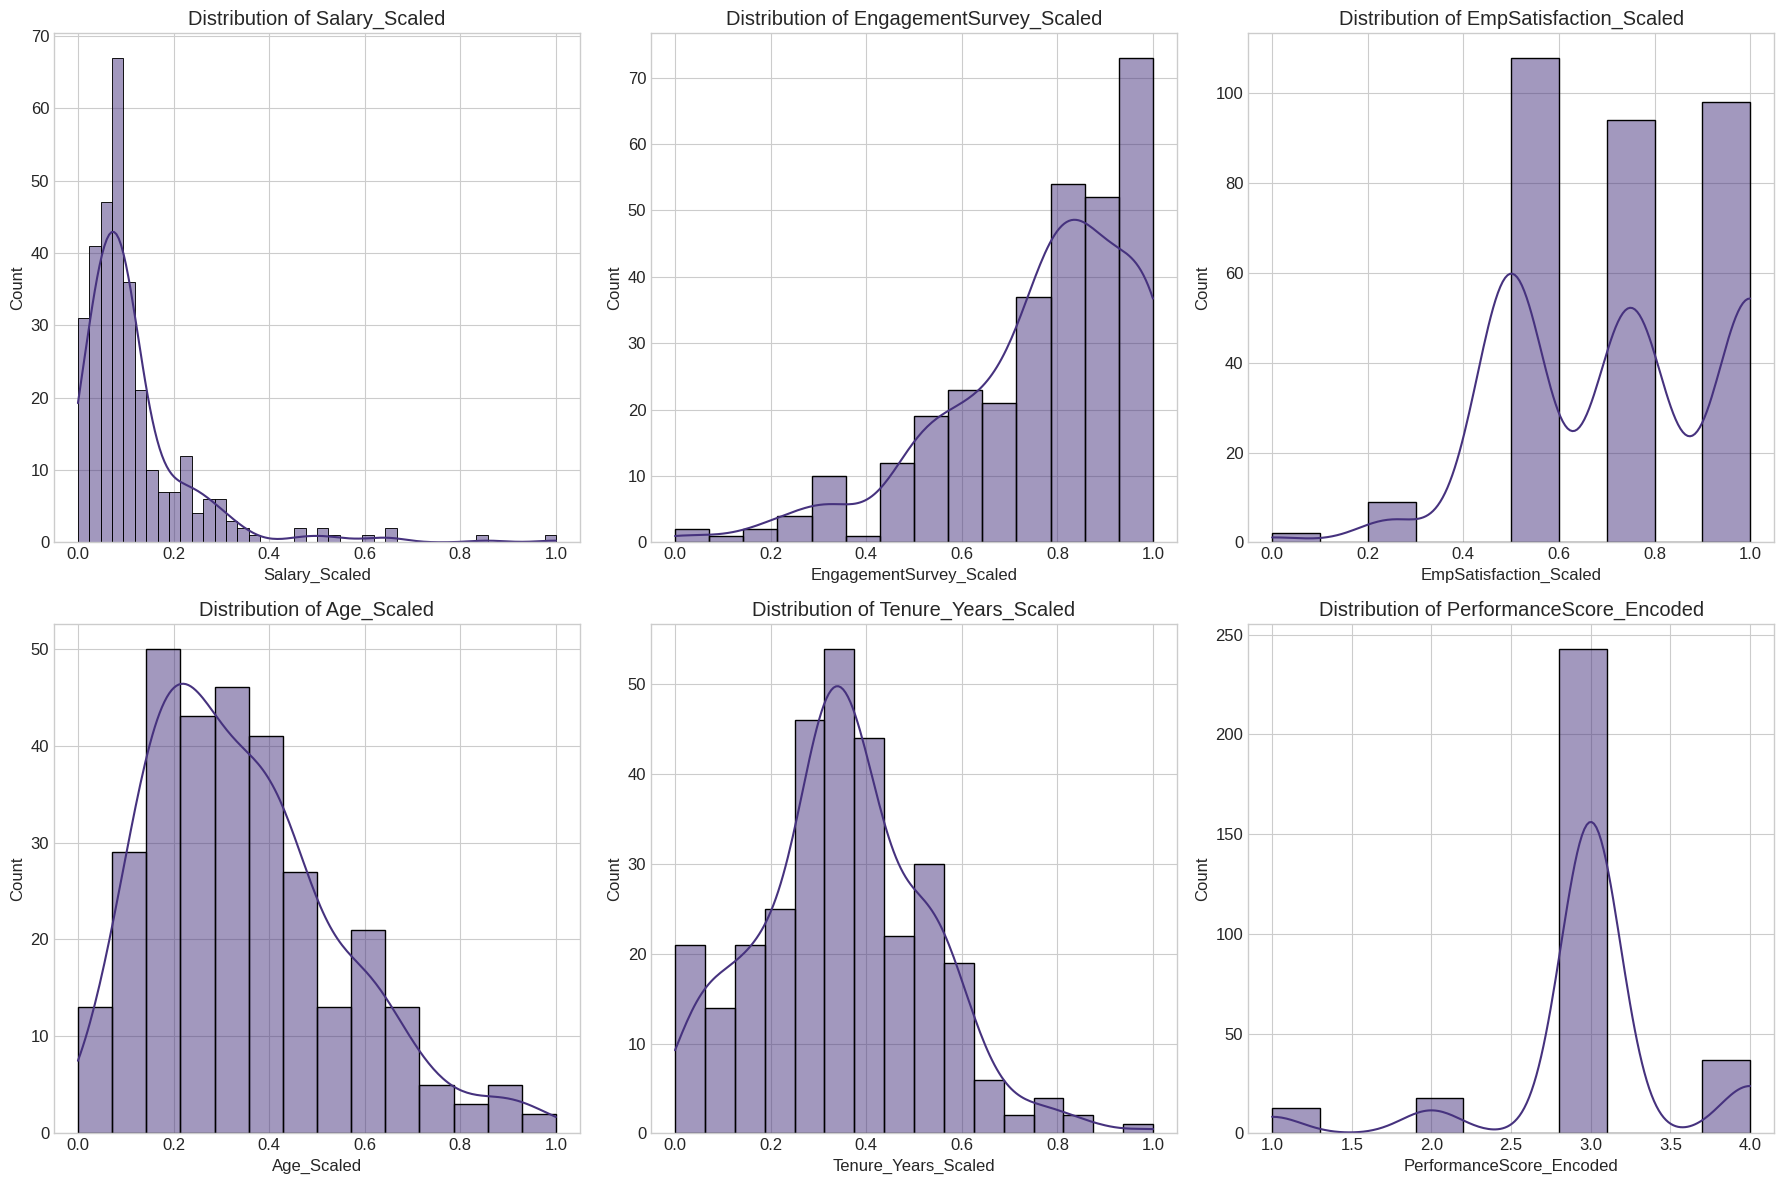

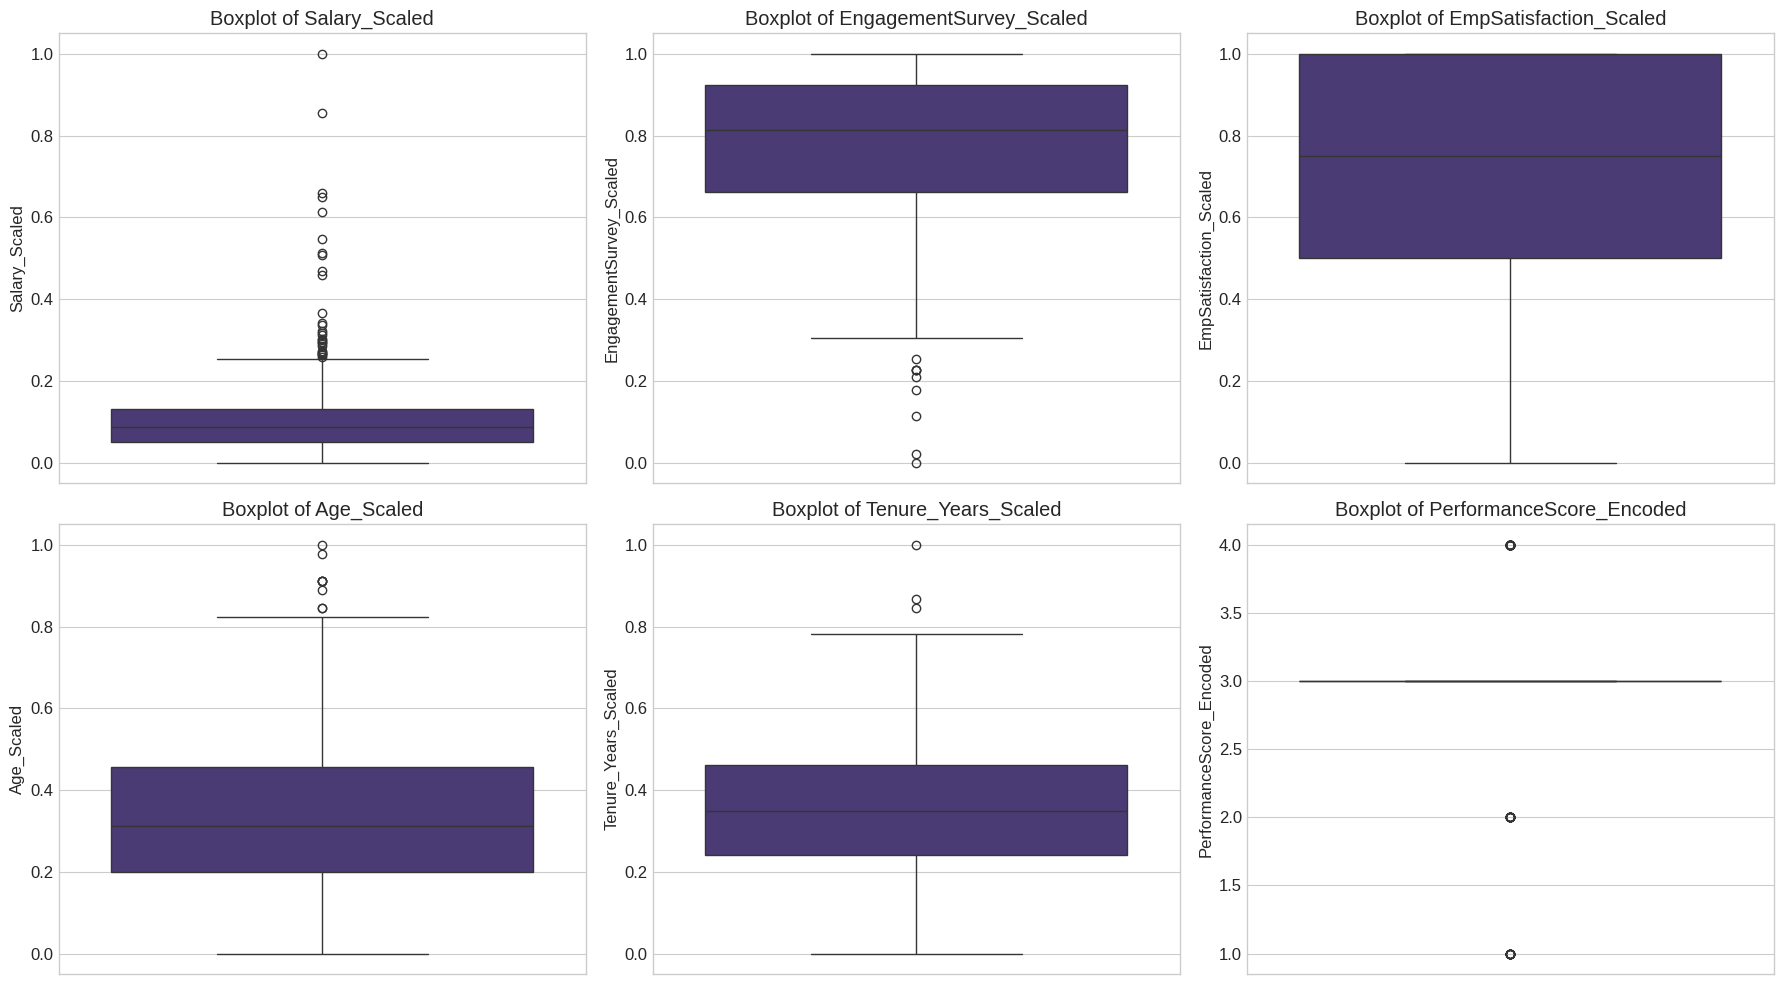

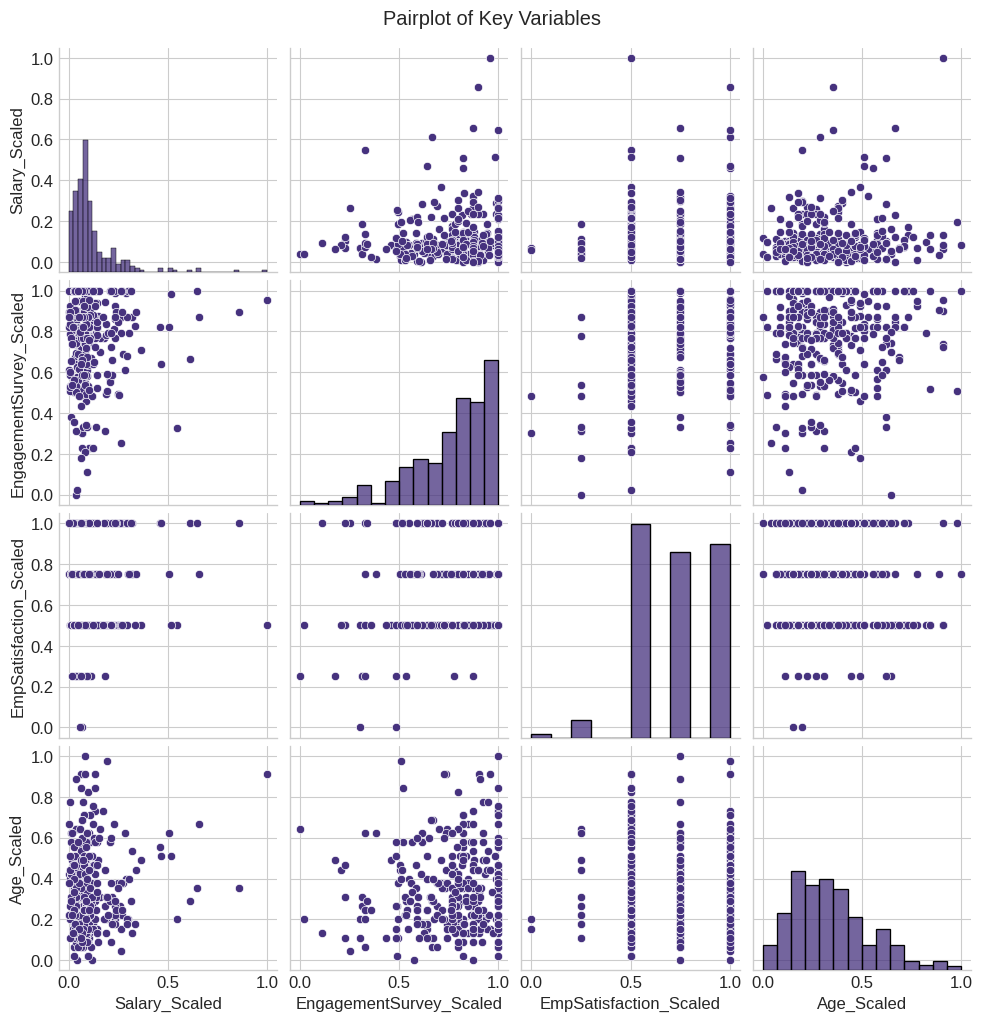


=== Categorical Variables Analysis ===


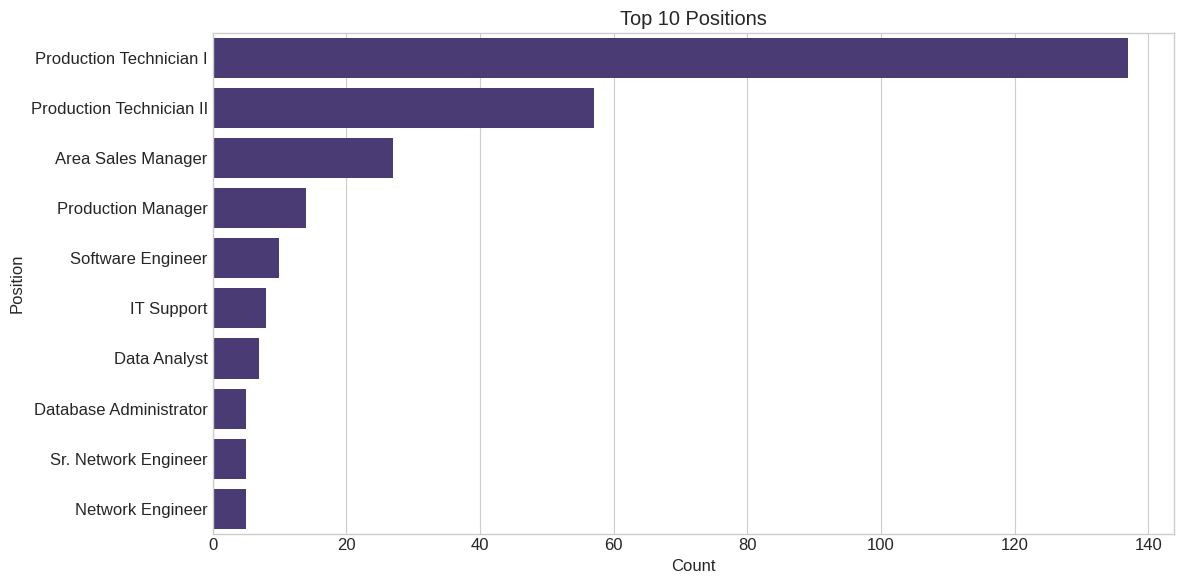

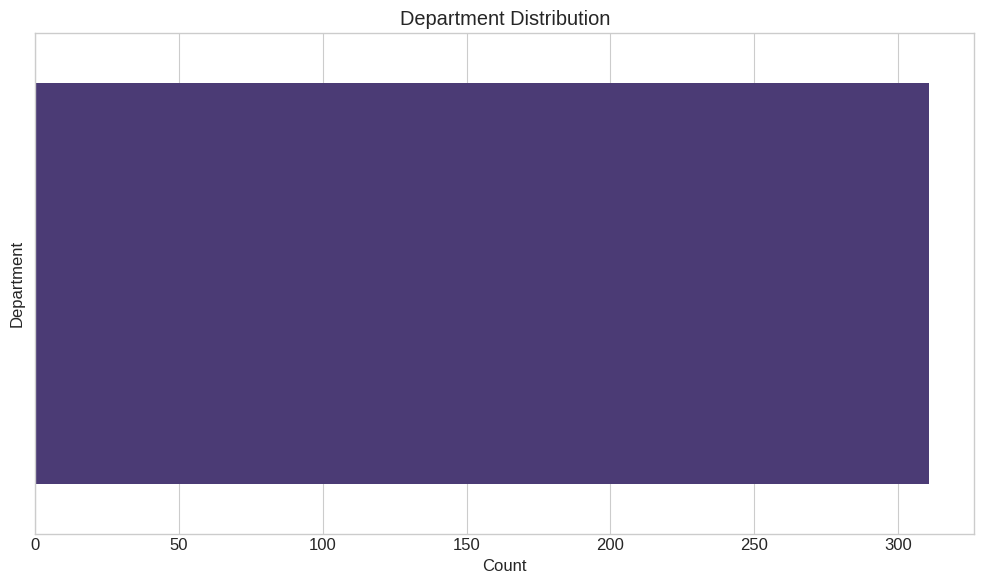

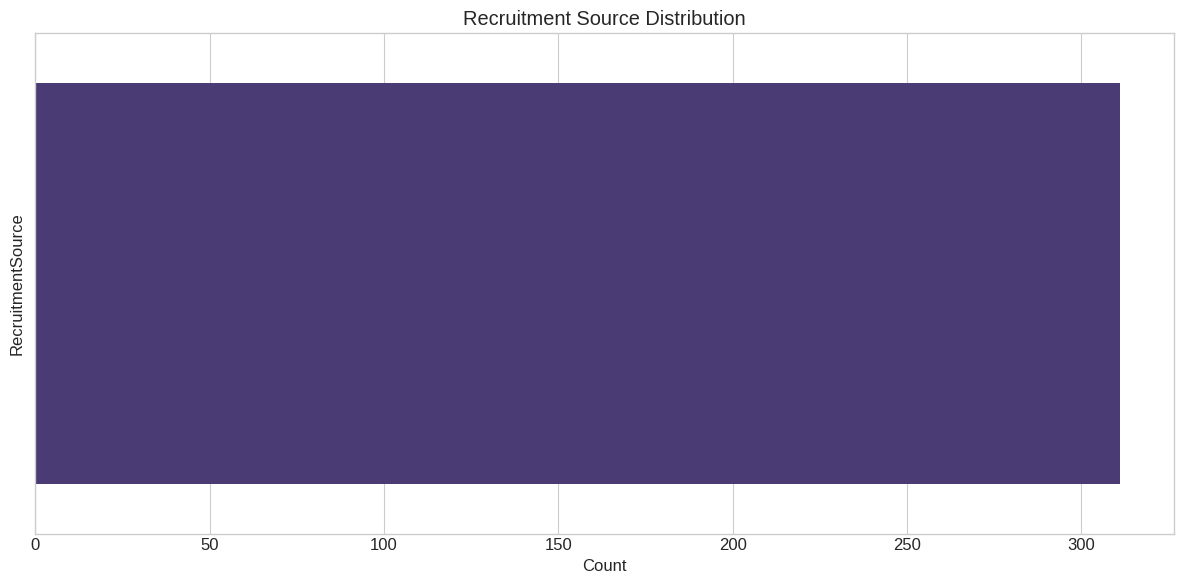

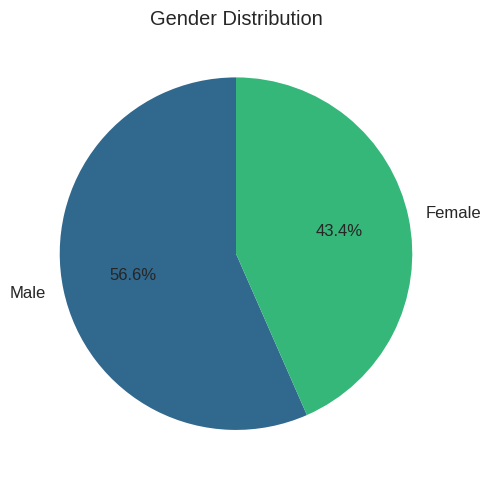

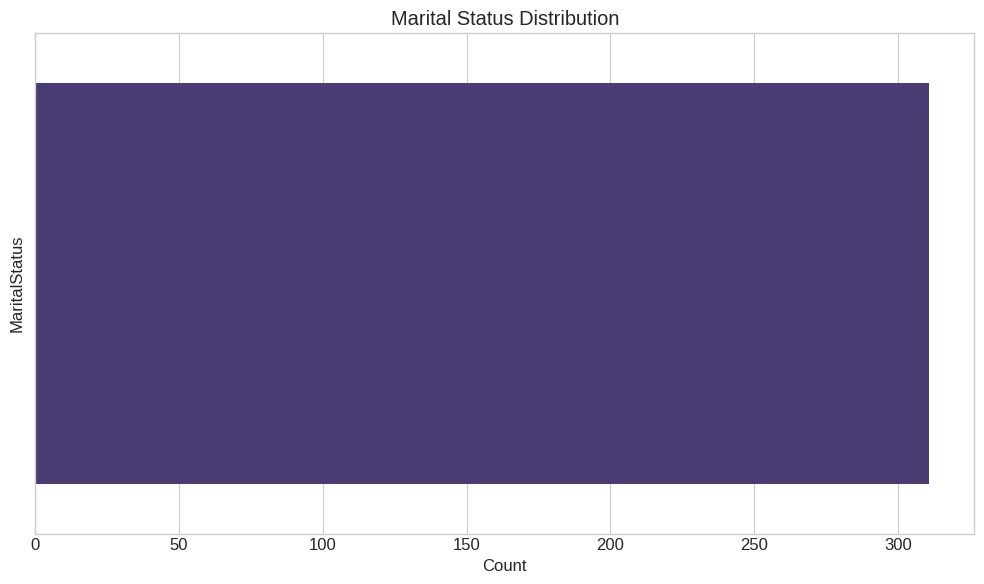

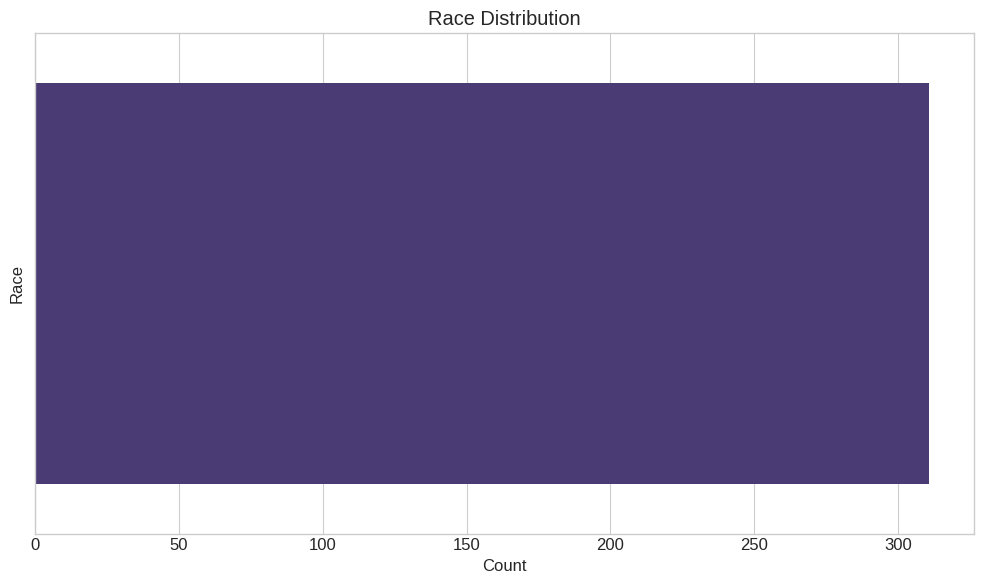

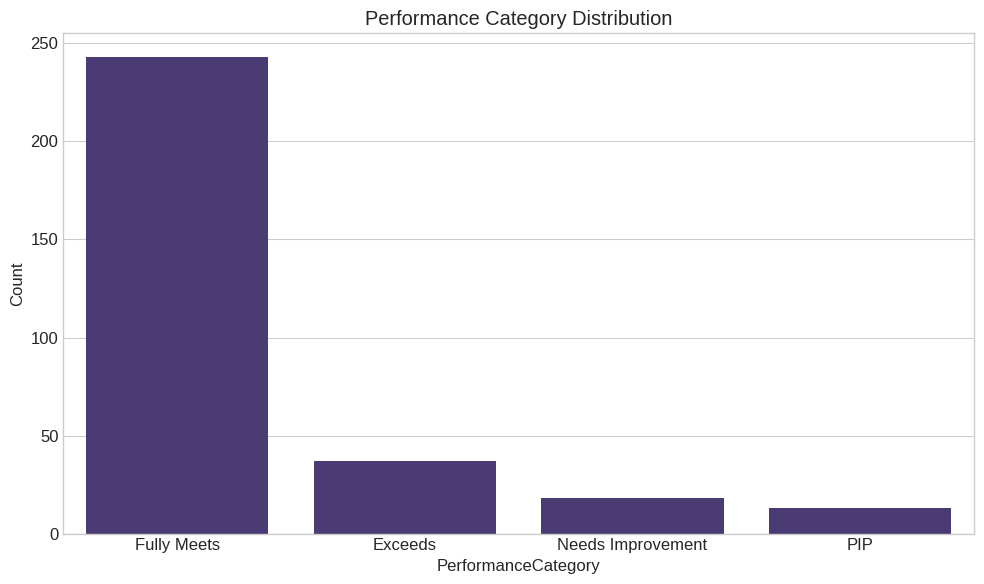


=== Correlation Analysis ===


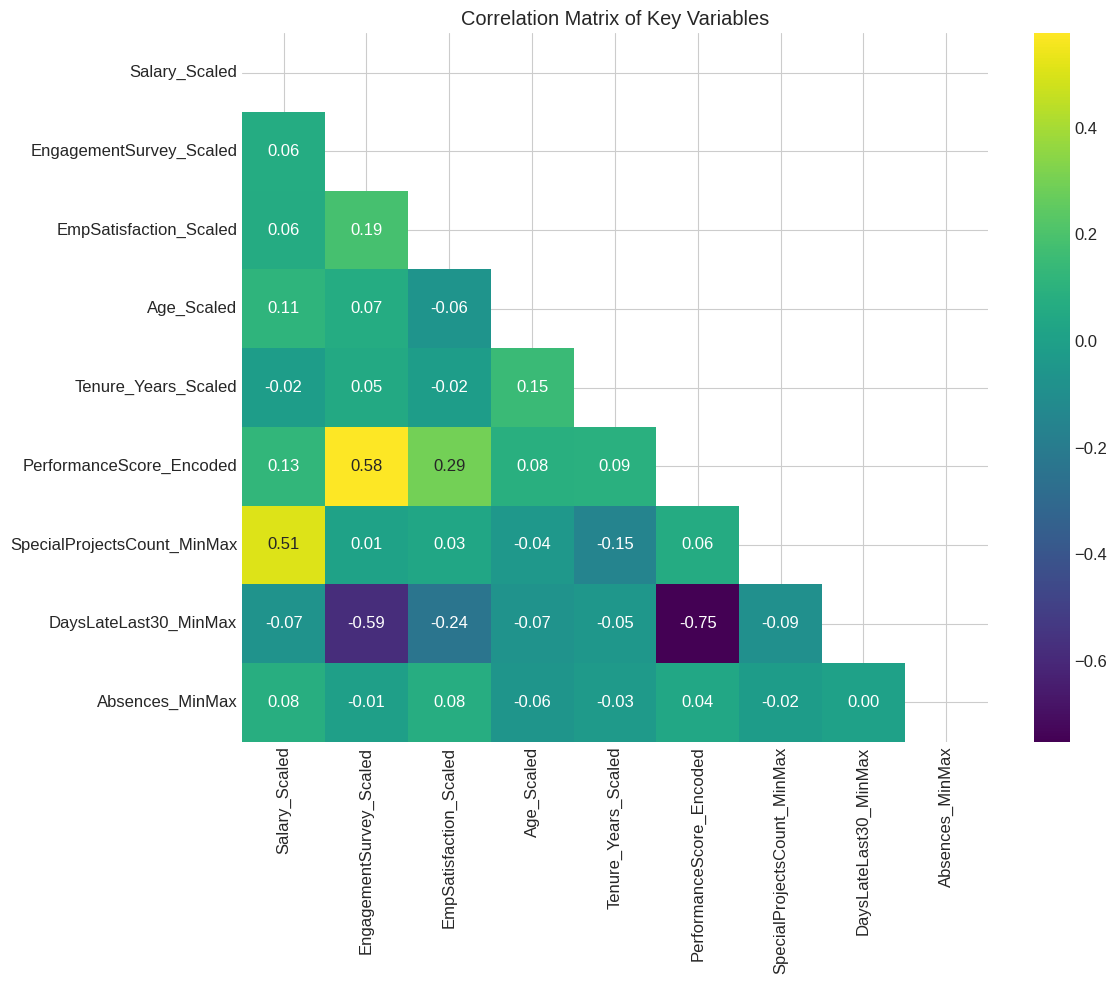


Strongly Correlated Features (|r| > 0.5):
                   feature1                     feature2  correlation
1   EngagementSurvey_Scaled     PerformanceScore_Encoded     0.576924
0             Salary_Scaled  SpecialProjectsCount_MinMax     0.508333
2   EngagementSurvey_Scaled        DaysLateLast30_MinMax    -0.585232
3  PerformanceScore_Encoded        DaysLateLast30_MinMax    -0.751707

=== Group-Based Analysis ===


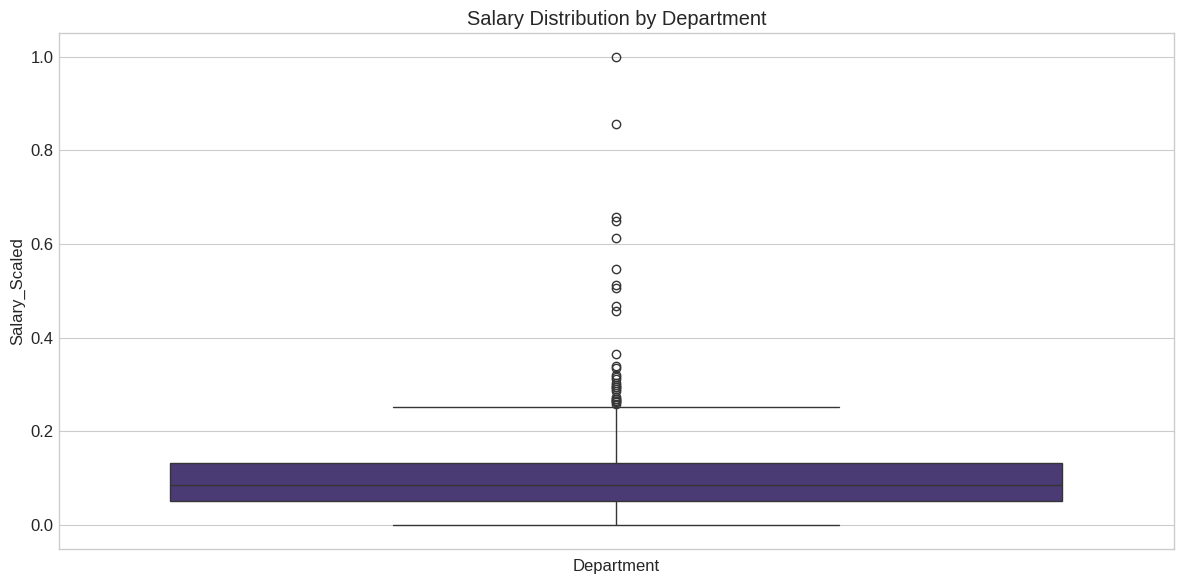

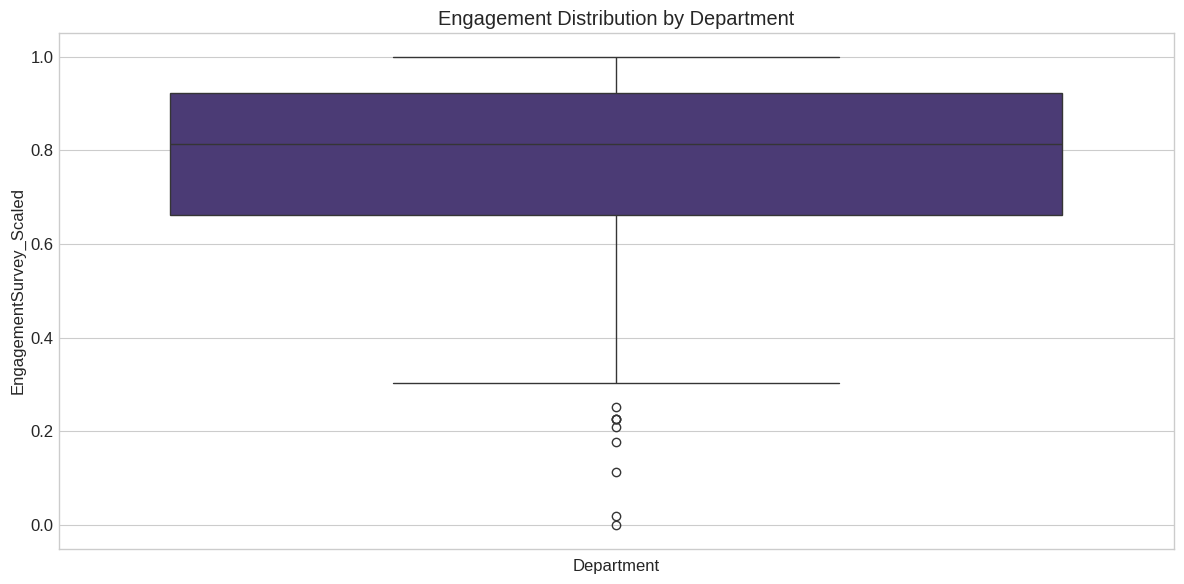

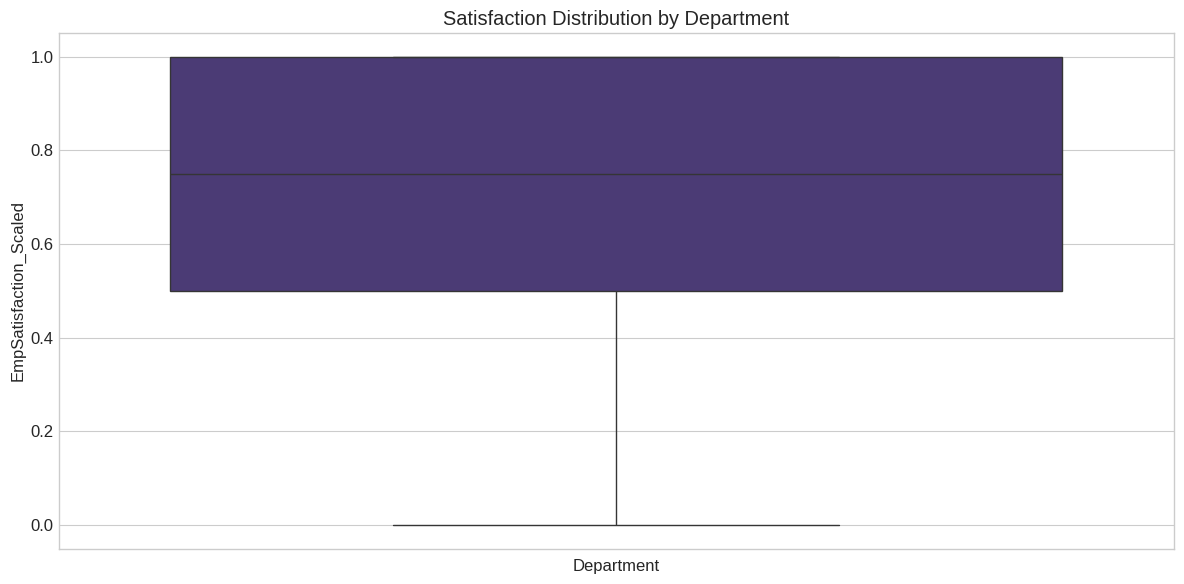

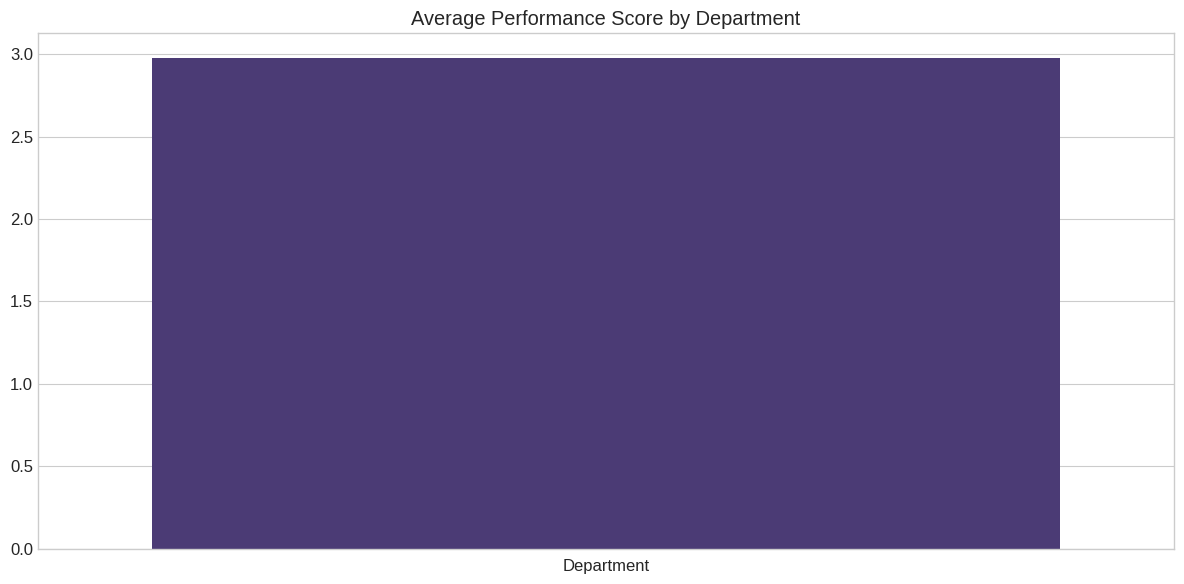

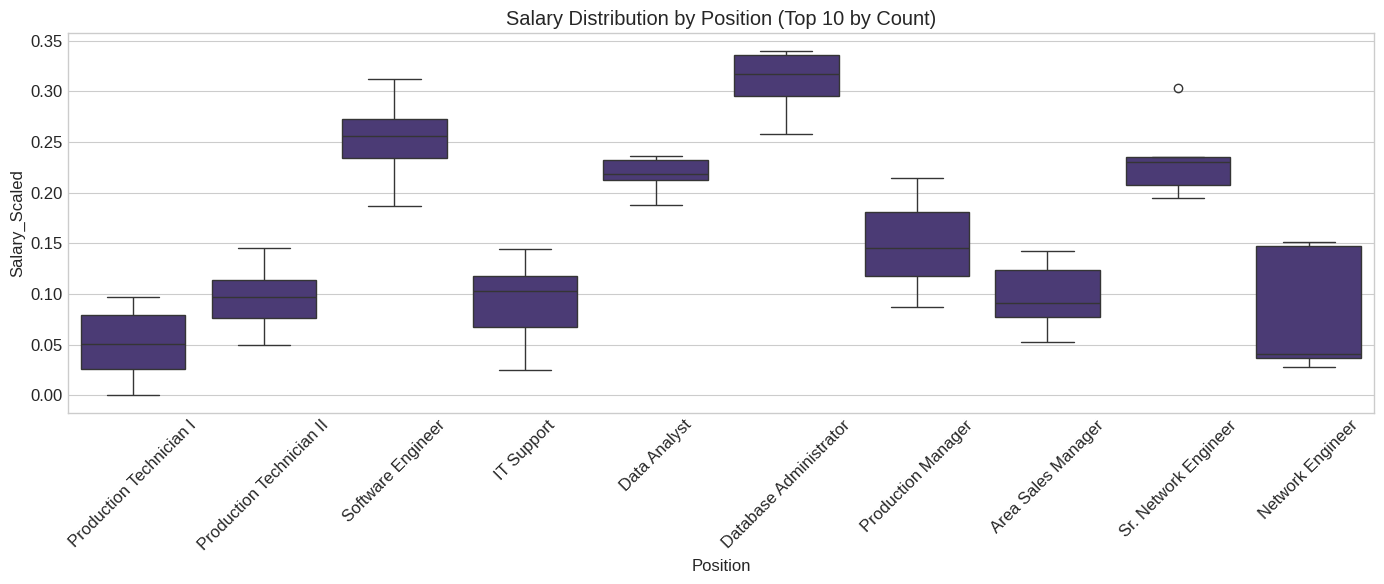

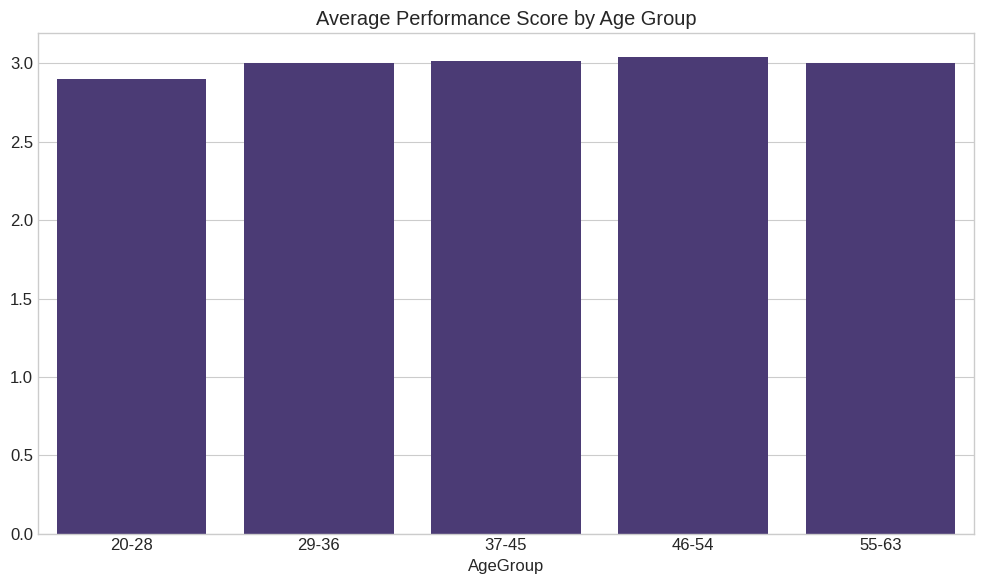

<Figure size 1200x600 with 0 Axes>

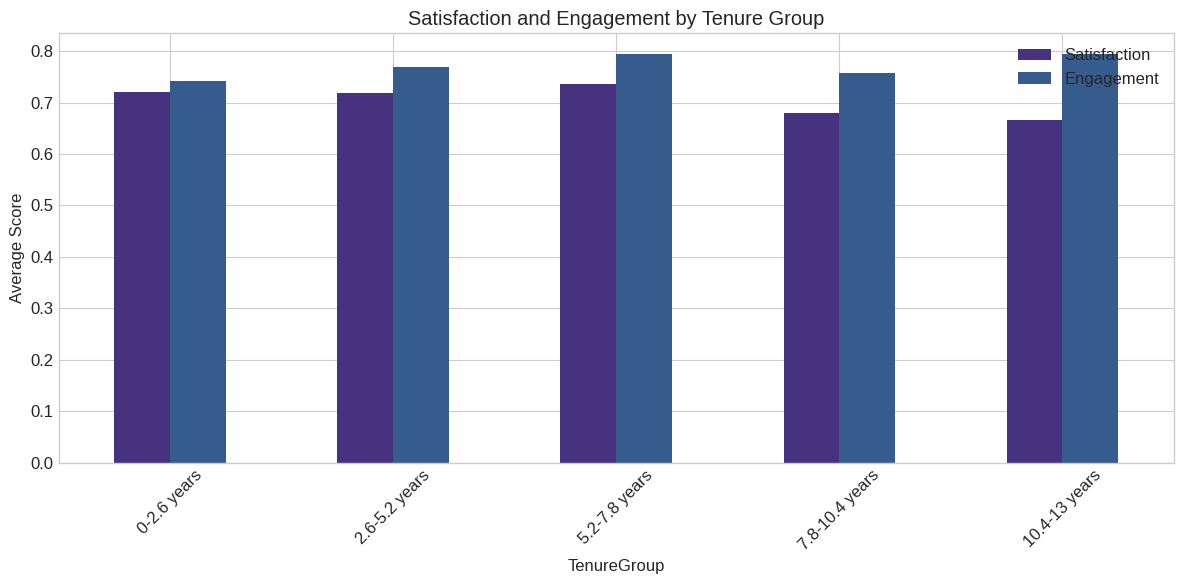

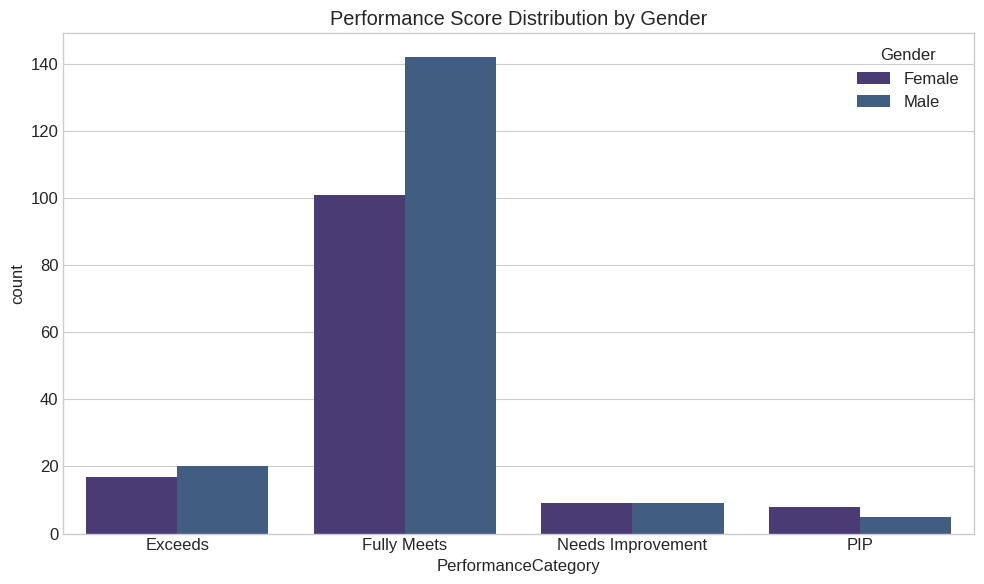

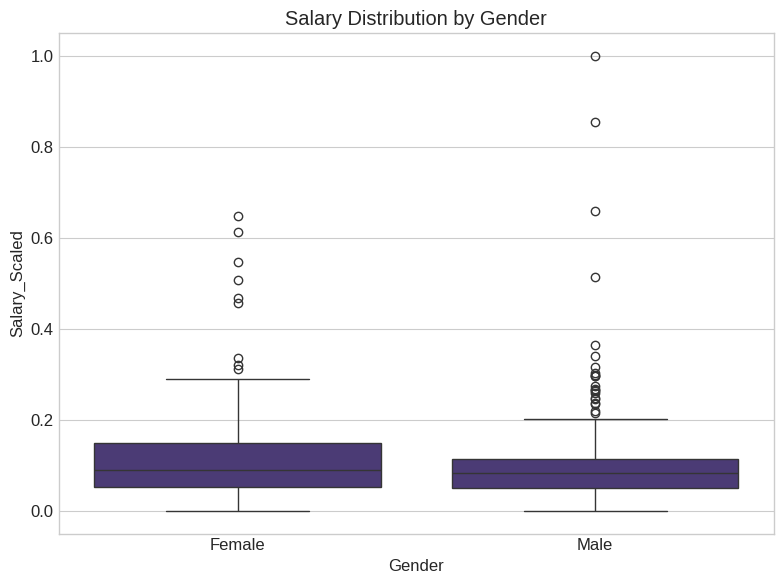

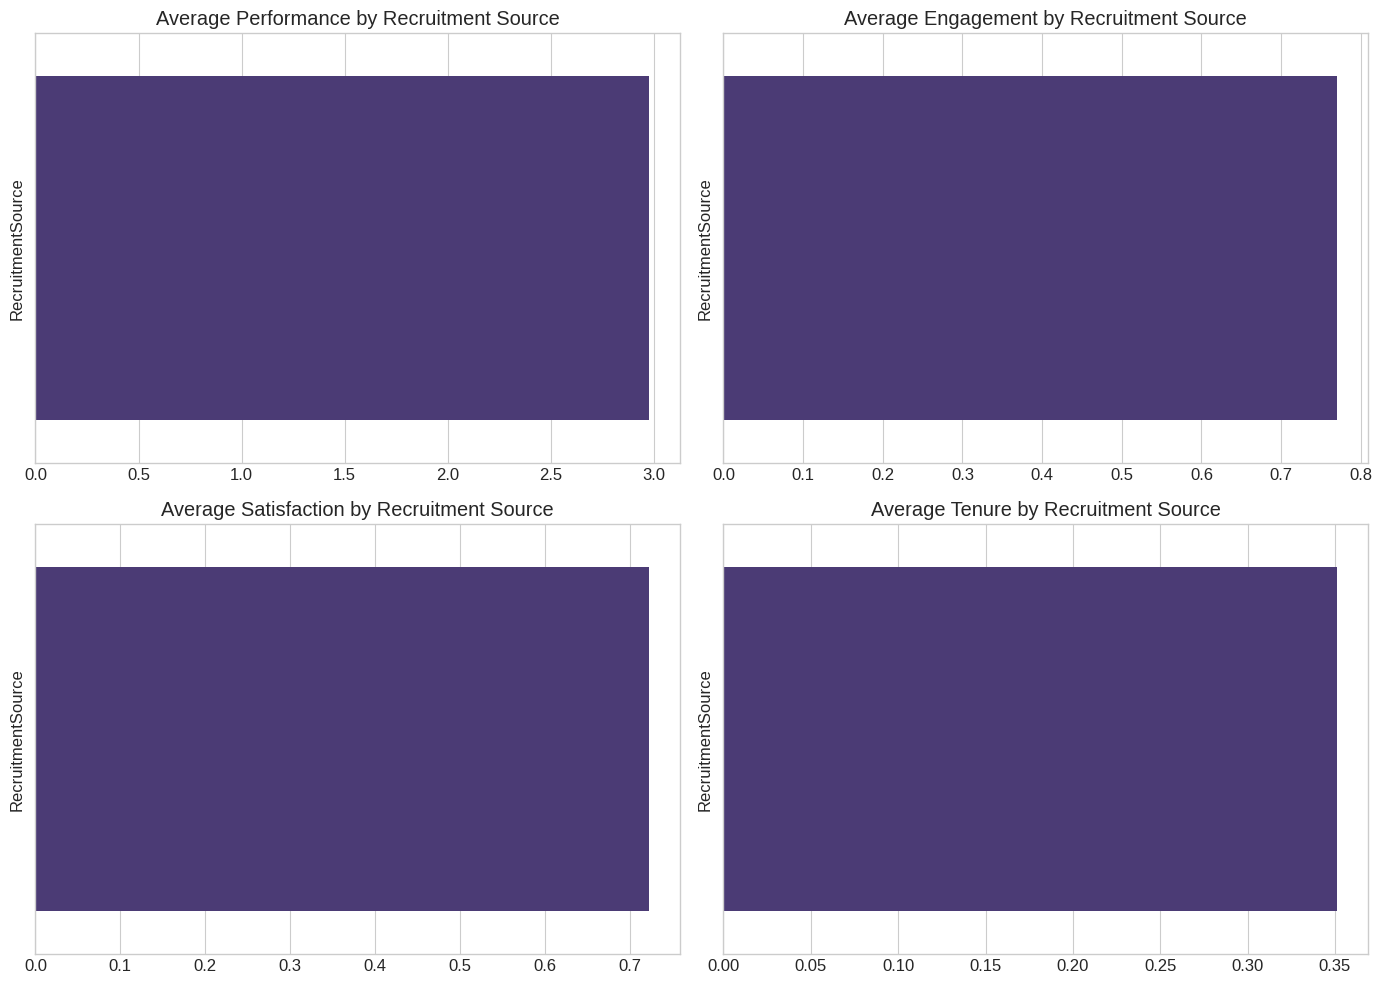

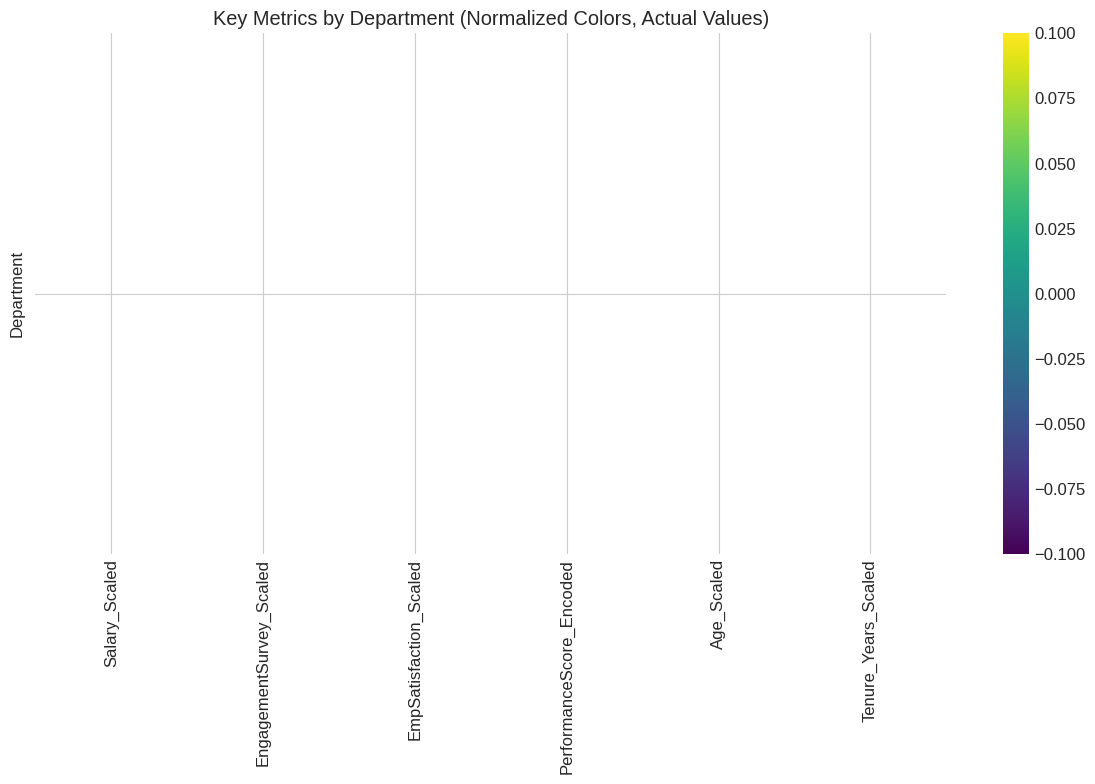


=== Dimensionality Reduction ===
Explained variance ratio by first two components: [0.2111746  0.13093825]
Total explained variance: 0.34

PCA Components:
                                  PC1       PC2
HispanicLatino_Encoded       0.045896  0.102837
Sex_Encoded                 -0.053522  0.137361
EmploymentStatus_Encoded    -0.217120  0.296104
PerformanceScore_Encoded     0.548713 -0.007635
Salary_Scaled                0.150387  0.516728
EngagementSurvey_Scaled      0.474161 -0.023441
EmpSatisfaction_Scaled       0.251894  0.105771
Age_Scaled                   0.100857 -0.173534
Tenure_Years_Scaled          0.124064 -0.462159
SpecialProjectsCount_MinMax  0.109502  0.571781
DaysLateLast30_MinMax       -0.546101  0.021844
Absences_MinMax              0.011186  0.181548


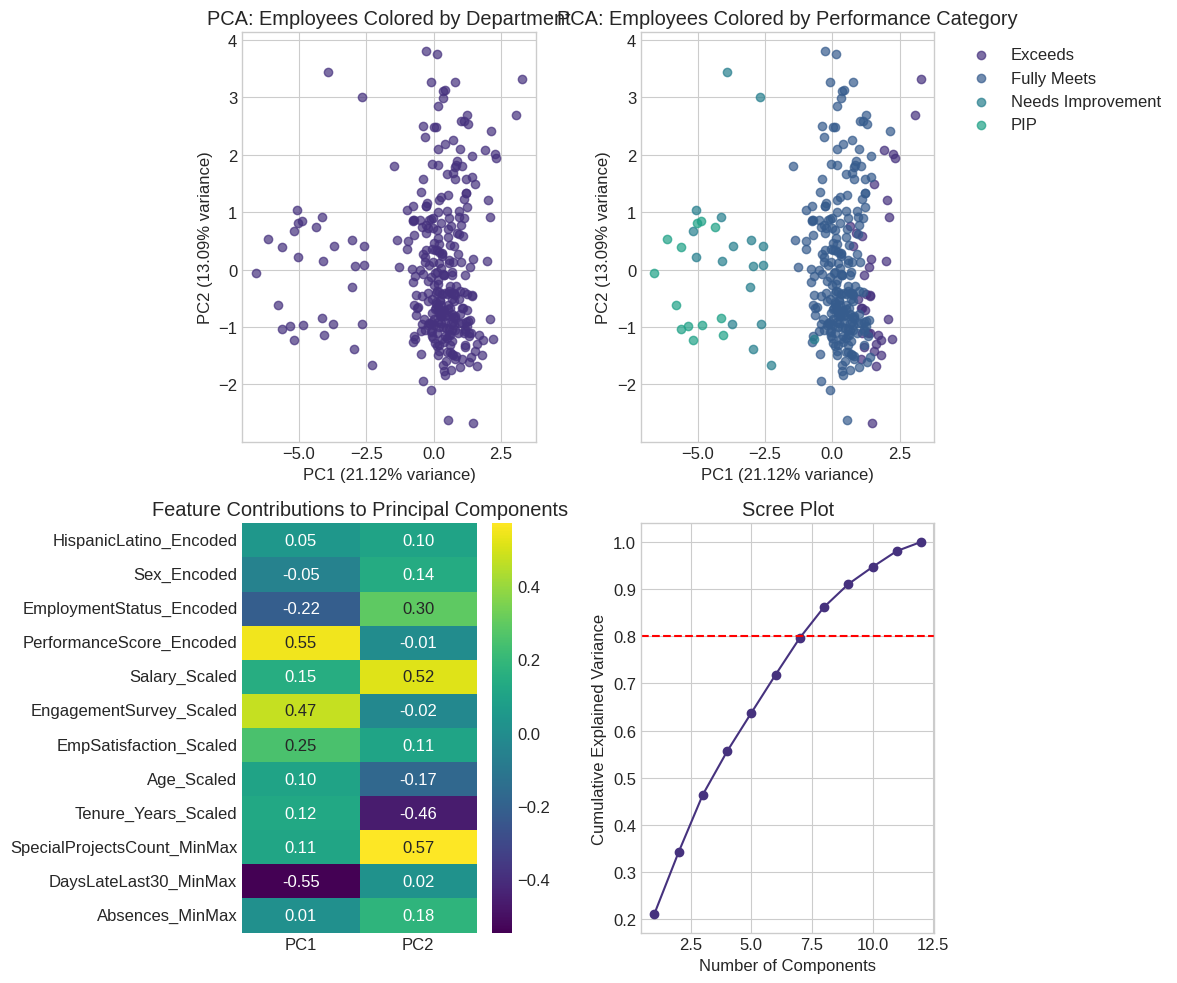


Applying t-SNE...


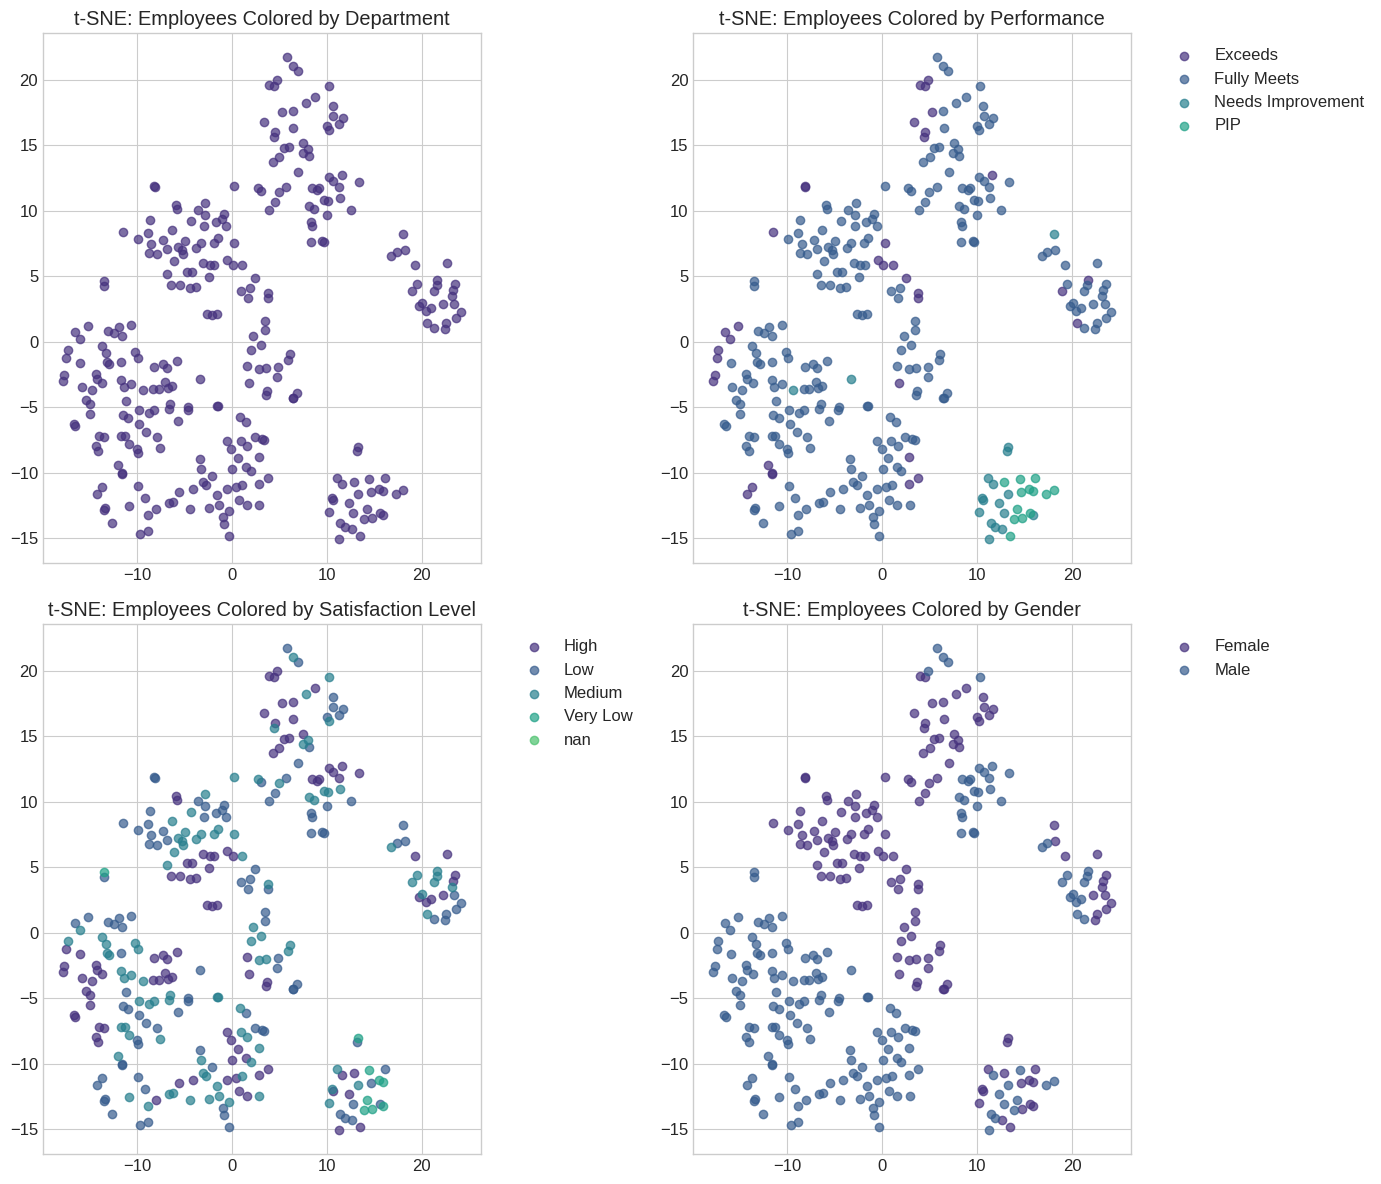


Applying UMAP...


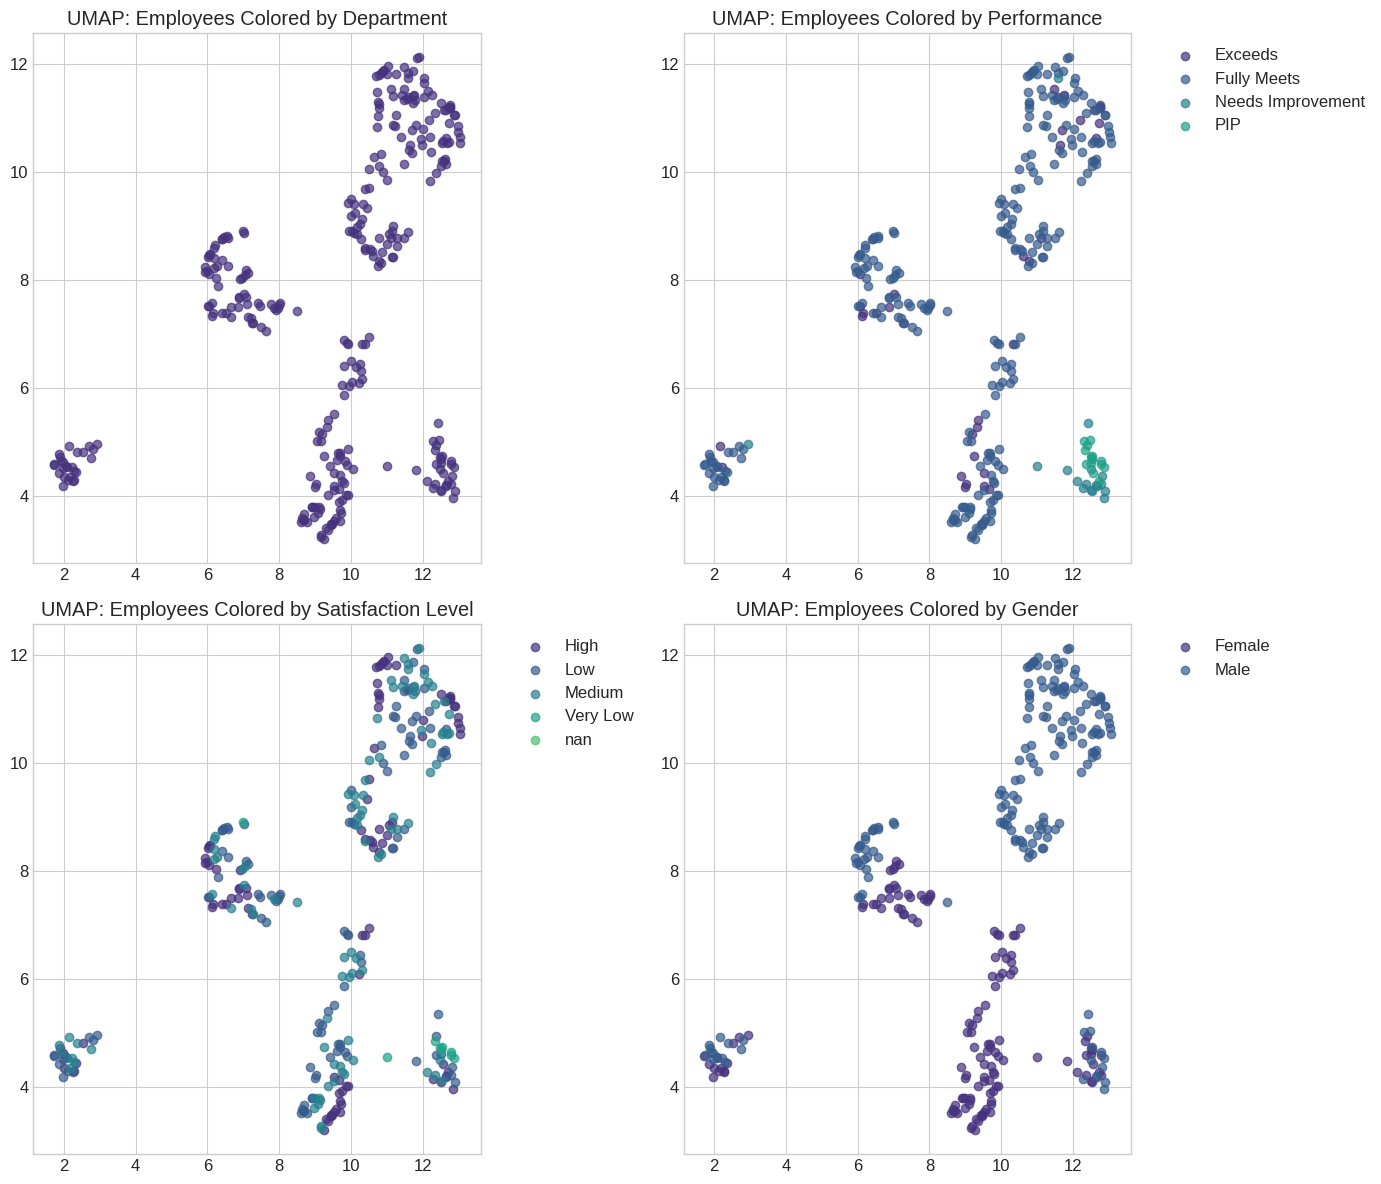


=== Pattern Detection ===


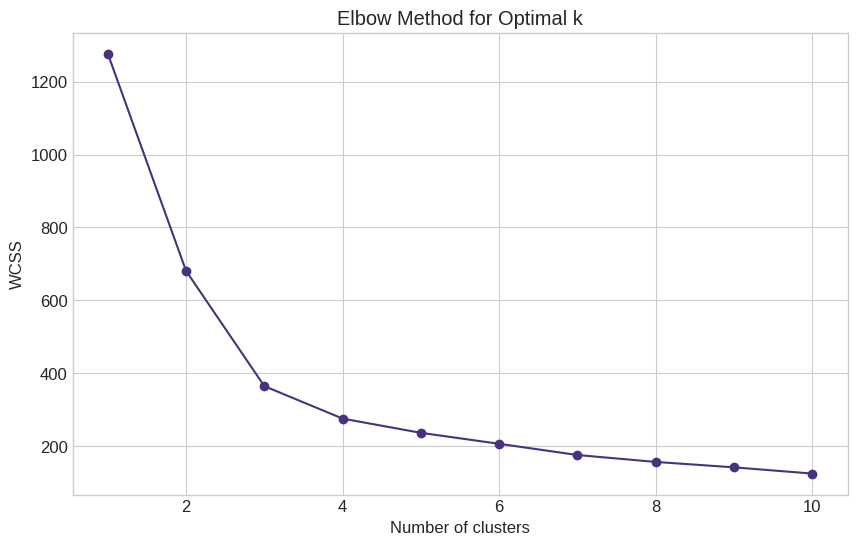

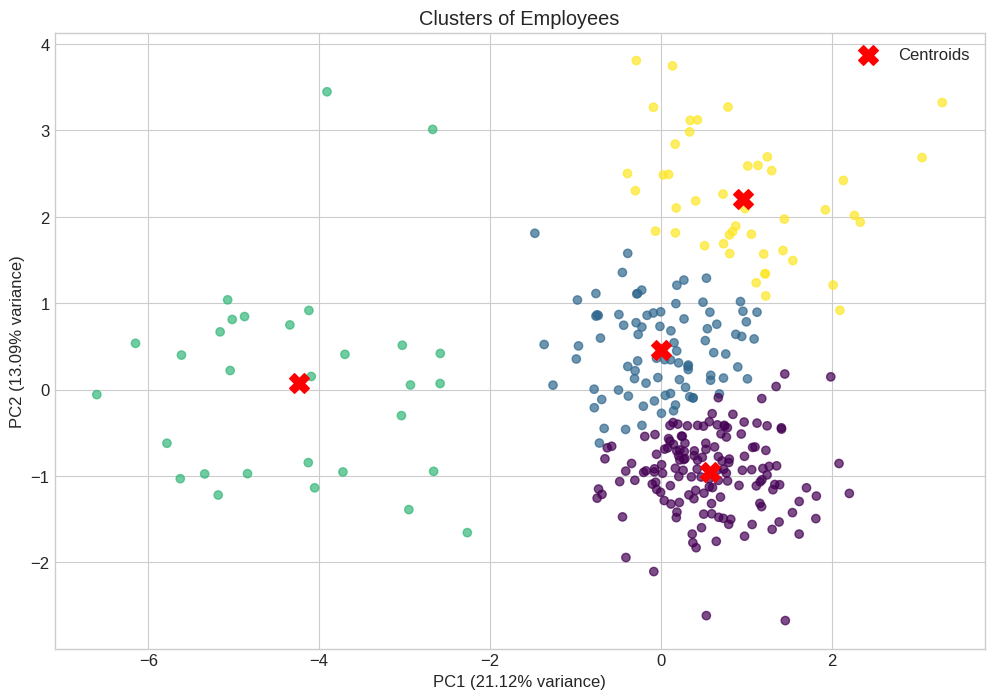


Cluster Characteristics:
         Salary_Scaled  EngagementSurvey_Scaled  EmpSatisfaction_Scaled  \
Cluster                                                                   
0                0.072                    0.825                   0.728   
1                0.098                    0.782                   0.733   
2                0.095                    0.388                   0.533   
3                0.318                    0.825                   0.811   

         PerformanceScore_Encoded  Age_Scaled  Tenure_Years_Scaled  \
Cluster                                                              
0                           3.162       0.396                0.452   
1                           3.045       0.277                0.230   
2                           1.567       0.293                0.338   
3                           3.178       0.355                0.267   

         SpecialProjectsCount_MinMax  DaysLateLast30_MinMax  Absences_MinMax  
Cluster                

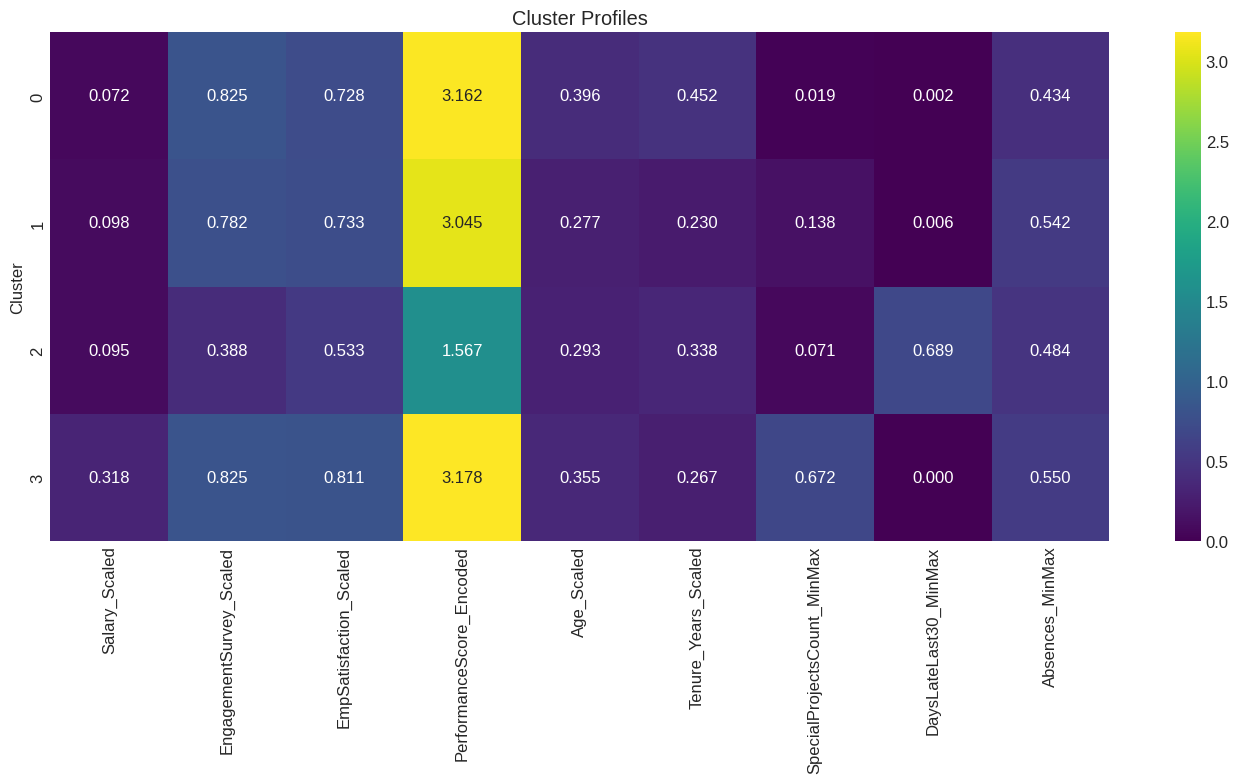

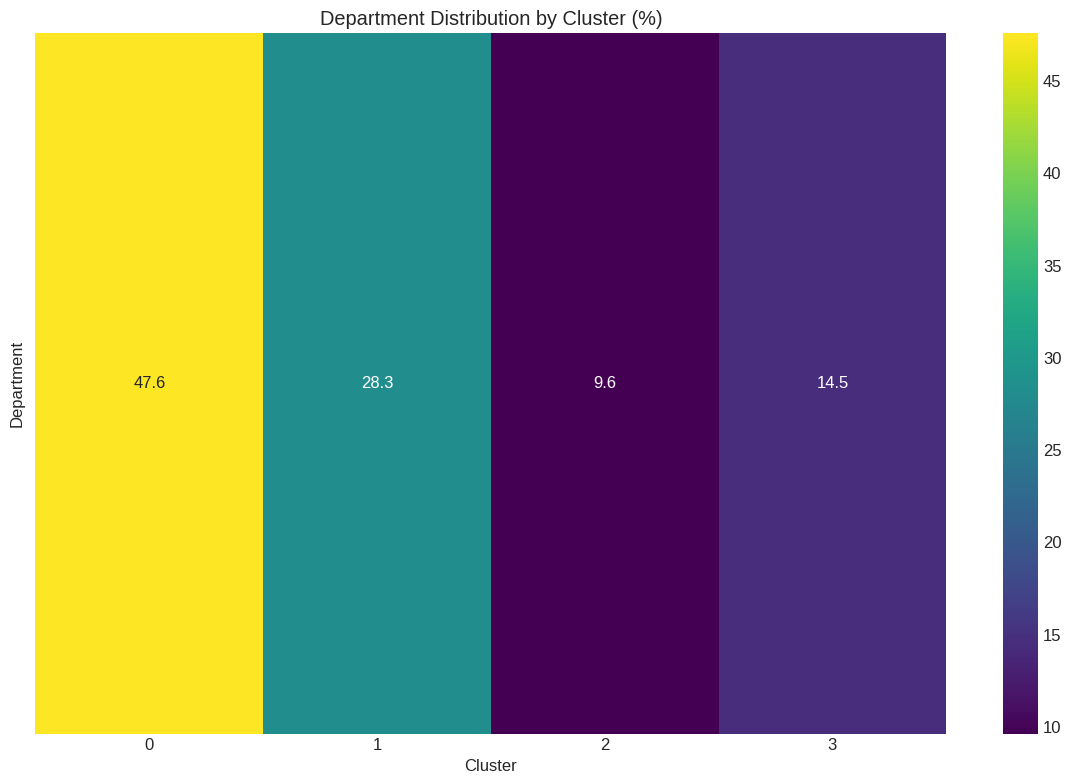

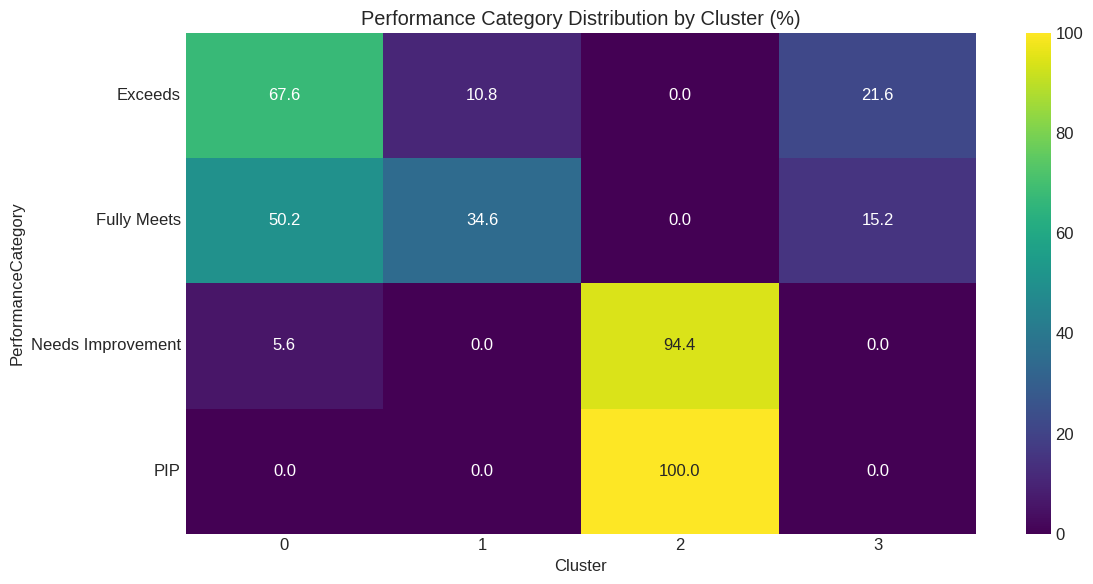


Cluster Interpretation:

Cluster 0:
Higher than average in: EngagementSurvey_Scaled, PerformanceScore_Encoded
Lower than average in: Salary_Scaled, Age_Scaled, Tenure_Years_Scaled, SpecialProjectsCount_MinMax, DaysLateLast30_MinMax, Absences_MinMax
Dominant department:  (100.0%)
Dominant performance category: Fully Meets (82.4%)

Cluster 1:
Higher than average in: EngagementSurvey_Scaled, PerformanceScore_Encoded
Lower than average in: Salary_Scaled, Age_Scaled, Tenure_Years_Scaled, SpecialProjectsCount_MinMax, DaysLateLast30_MinMax, Absences_MinMax
Dominant department:  (100.0%)
Dominant performance category: Fully Meets (95.5%)

Cluster 2:
Higher than average in: PerformanceScore_Encoded, DaysLateLast30_MinMax
Lower than average in: Salary_Scaled, EngagementSurvey_Scaled, Age_Scaled, Tenure_Years_Scaled, SpecialProjectsCount_MinMax
Dominant department:  (100.0%)
Dominant performance category: Needs Improvement (56.7%)

Cluster 3:
Higher than average in: PerformanceScore_Encoded
Lowe

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import umap
import warnings
warnings.filterwarnings('ignore')

# Set the style for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Load the dataset
def load_data(file_path):
    df = pd.read_csv(file_path)
    print(f"Dataset shape: {df.shape}")
    return df

# 1. Descriptive Statistics
def descriptive_statistics(df):
    """Generate descriptive statistics for the dataset"""
    # Identify column types
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object', 'bool']).columns.tolist()
    binary_cols = [col for col in df.columns if df[col].isin(['True', 'False']).all() or df[col].isin([0, 1]).all()]

    print("\n=== Descriptive Statistics ===")

    # Summary stats for numeric columns
    print("\nNumeric Columns Summary:")
    print(df[numeric_cols].describe().T)

    # Frequency counts for categorical variables
    if categorical_cols:
        print("\nCategorical Columns:")
        for col in categorical_cols:
            print(f"\n{col} Value Counts:")
            print(df[col].value_counts())

    # Check for missing values
    print("\nMissing Values:")
    missing = df.isnull().sum()
    missing = missing[missing > 0]
    if len(missing) > 0:
        print(missing)
    else:
        print("No missing values found.")

    return numeric_cols, categorical_cols, binary_cols

# Create single department and recruitment source columns
def preprocess_data(df):
    """Create unified columns from one-hot encoded columns"""
    # Convert department columns
    dept_columns = [col for col in df.columns if col.startswith('Department_')]
    df['Department'] = ''
    for col in dept_columns:
        dept_name = col.replace('Department_', '')
        df.loc[df[col] == 'True', 'Department'] = dept_name

    # Convert recruitment source columns
    recruit_columns = [col for col in df.columns if col.startswith('RecruitmentSource_')]
    df['RecruitmentSource'] = ''
    for col in recruit_columns:
        source_name = col.replace('RecruitmentSource_', '')
        df.loc[df[col] == 'True', 'RecruitmentSource'] = source_name

    # Convert marital status columns
    marital_columns = [col for col in df.columns if col.startswith('MaritalDesc_')]
    df['MaritalStatus'] = ''
    for col in marital_columns:
        status_name = col.replace('MaritalDesc_', '')
        df.loc[df[col] == 'True', 'MaritalStatus'] = status_name

    # Convert race columns
    race_columns = [col for col in df.columns if col.startswith('RaceDesc_')]
    df['Race'] = ''
    for col in race_columns:
        race_name = col.replace('RaceDesc_', '')
        df.loc[df[col] == 'True', 'Race'] = race_name

    # Encoding sex column
    df['Gender'] = df['Sex_Encoded'].map({0: 'Male', 1: 'Female'})

    # Create age groups
    age_bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
    age_labels = ['20-28', '29-36', '37-45', '46-54', '55-63']
    df['AgeGroup'] = pd.cut(df['Age_Scaled'], bins=age_bins, labels=age_labels)

    # Create tenure groups
    tenure_bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
    tenure_labels = ['0-2.6 years', '2.6-5.2 years', '5.2-7.8 years', '7.8-10.4 years', '10.4-13 years']
    df['TenureGroup'] = pd.cut(df['Tenure_Years_Scaled'], bins=tenure_bins, labels=tenure_labels)

    # Create satisfaction groups
    satisfaction_bins = [0, 0.25, 0.5, 0.75, 1.0]
    satisfaction_labels = ['Very Low', 'Low', 'Medium', 'High']
    df['SatisfactionLevel'] = pd.cut(df['EmpSatisfaction_Scaled'], bins=satisfaction_bins, labels=satisfaction_labels)

    # Create engagement groups
    engagement_bins = [0, 0.25, 0.5, 0.75, 1.0]
    engagement_labels = ['Very Low', 'Low', 'Medium', 'High']
    df['EngagementLevel'] = pd.cut(df['EngagementSurvey_Scaled'], bins=engagement_bins, labels=engagement_labels)

    # Performance score mapping
    df['PerformanceCategory'] = df['PerformanceScore_Encoded'].map({
        1: 'PIP', 2: 'Needs Improvement', 3: 'Fully Meets', 4: 'Exceeds'
    })

    return df

# 2. Data Visualization
def visualize_numeric_distributions(df, numeric_cols):
    """Visualize distributions of numerical variables"""
    print("\n=== Numeric Variables Distributions ===")

    # Select important numeric variables for visualization
    important_vars = ['Salary_Scaled', 'EngagementSurvey_Scaled', 'EmpSatisfaction_Scaled',
                      'Age_Scaled', 'Tenure_Years_Scaled', 'PerformanceScore_Encoded']

    # Histograms and KDE plots
    plt.figure(figsize=(18, 12))
    for i, col in enumerate(important_vars):
        plt.subplot(2, 3, i+1)
        sns.histplot(df[col], kde=True)
        plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.savefig('numeric_distributions.png')
    plt.show()

    # Boxplots for numeric variables
    plt.figure(figsize=(18, 10))
    for i, col in enumerate(important_vars):
        plt.subplot(2, 3, i+1)
        sns.boxplot(y=df[col])
        plt.title(f'Boxplot of {col}')
    plt.tight_layout()
    plt.savefig('numeric_boxplots.png')
    plt.show()

    # Pairplot for key variables
    key_vars = ['Salary_Scaled', 'EngagementSurvey_Scaled', 'EmpSatisfaction_Scaled', 'Age_Scaled']
    sns.pairplot(df[key_vars])
    plt.suptitle('Pairplot of Key Variables', y=1.02)
    plt.savefig('key_variables_pairplot.png')
    plt.show()

def visualize_categorical_data(df):
    """Visualize categorical variables"""
    print("\n=== Categorical Variables Analysis ===")

    # Position distribution (top 10)
    plt.figure(figsize=(12, 6))
    position_counts = df['Position'].value_counts().head(10)
    sns.barplot(x=position_counts.values, y=position_counts.index)
    plt.title('Top 10 Positions')
    plt.xlabel('Count')
    plt.tight_layout()
    plt.savefig('position_distribution.png')
    plt.show()

    # Department distribution
    plt.figure(figsize=(10, 6))
    dept_counts = df['Department'].value_counts()
    sns.barplot(x=dept_counts.values, y=dept_counts.index)
    plt.title('Department Distribution')
    plt.xlabel('Count')
    plt.tight_layout()
    plt.savefig('department_distribution.png')
    plt.show()

    # Recruitment source distribution
    plt.figure(figsize=(12, 6))
    recruit_counts = df['RecruitmentSource'].value_counts()
    sns.barplot(x=recruit_counts.values, y=recruit_counts.index)
    plt.title('Recruitment Source Distribution')
    plt.xlabel('Count')
    plt.tight_layout()
    plt.savefig('recruitment_source_distribution.png')
    plt.show()

    # Gender distribution
    plt.figure(figsize=(8, 5))
    gender_counts = df['Gender'].value_counts()
    plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('viridis', 2))
    plt.title('Gender Distribution')
    plt.tight_layout()
    plt.savefig('gender_distribution.png')
    plt.show()

    # Marital status distribution
    plt.figure(figsize=(10, 6))
    marital_counts = df['MaritalStatus'].value_counts()
    sns.barplot(x=marital_counts.values, y=marital_counts.index)
    plt.title('Marital Status Distribution')
    plt.xlabel('Count')
    plt.tight_layout()
    plt.savefig('marital_status_distribution.png')
    plt.show()

    # Race distribution
    plt.figure(figsize=(10, 6))
    race_counts = df['Race'].value_counts()
    sns.barplot(x=race_counts.values, y=race_counts.index)
    plt.title('Race Distribution')
    plt.xlabel('Count')
    plt.tight_layout()
    plt.savefig('race_distribution.png')
    plt.show()

    # Performance category distribution
    plt.figure(figsize=(10, 6))
    performance_counts = df['PerformanceCategory'].value_counts()
    sns.barplot(x=performance_counts.index, y=performance_counts.values)
    plt.title('Performance Category Distribution')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.savefig('performance_distribution.png')
    plt.show()

def correlation_analysis(df, numeric_cols):
    """Analyze correlations between numeric variables"""
    print("\n=== Correlation Analysis ===")

    # Select important variables for correlation
    important_vars = [
        'Salary_Scaled', 'EngagementSurvey_Scaled', 'EmpSatisfaction_Scaled',
        'Age_Scaled', 'Tenure_Years_Scaled', 'PerformanceScore_Encoded',
        'SpecialProjectsCount_MinMax', 'DaysLateLast30_MinMax', 'Absences_MinMax'
    ]

    # Create correlation matrix
    corr_matrix = df[important_vars].corr()

    # Plot correlation heatmap
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='viridis', mask=mask)
    plt.title('Correlation Matrix of Key Variables')
    plt.tight_layout()
    plt.savefig('correlation_heatmap.png')
    plt.show()

    # Print strongly correlated features
    print("\nStrongly Correlated Features (|r| > 0.5):")
    strong_correlations = []
    for i in range(len(important_vars)):
        for j in range(i+1, len(important_vars)):
            if abs(corr_matrix.iloc[i, j]) > 0.5:
                strong_correlations.append({
                    'feature1': important_vars[i],
                    'feature2': important_vars[j],
                    'correlation': corr_matrix.iloc[i, j]
                })

    if strong_correlations:
        strong_corr_df = pd.DataFrame(strong_correlations)
        print(strong_corr_df.sort_values('correlation', ascending=False))
    else:
        print("No strong correlations found.")

# 3. Group-Based Analysis
def group_based_analysis(df):
    """Compare metrics across different categorical groups"""
    print("\n=== Group-Based Analysis ===")

    # Salary by Department
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Department', y='Salary_Scaled', data=df)
    plt.title('Salary Distribution by Department')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('salary_by_department.png')
    plt.show()

    # Engagement by Department
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Department', y='EngagementSurvey_Scaled', data=df)
    plt.title('Engagement Distribution by Department')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('engagement_by_department.png')
    plt.show()

    # Satisfaction by Department
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Department', y='EmpSatisfaction_Scaled', data=df)
    plt.title('Satisfaction Distribution by Department')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('satisfaction_by_department.png')
    plt.show()

    # Performance by Department
    plt.figure(figsize=(12, 6))
    performance_by_dept = df.groupby('Department')['PerformanceScore_Encoded'].mean().sort_values(ascending=False)
    sns.barplot(x=performance_by_dept.index, y=performance_by_dept.values)
    plt.title('Average Performance Score by Department')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('performance_by_department.png')
    plt.show()

    # Salary by Position (top 10 positions by count)
    top_positions = df['Position'].value_counts().head(10).index
    position_df = df[df['Position'].isin(top_positions)]
    plt.figure(figsize=(14, 6))
    sns.boxplot(x='Position', y='Salary_Scaled', data=position_df)
    plt.title('Salary Distribution by Position (Top 10 by Count)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('salary_by_position.png')
    plt.show()

    # Performance by Age Group
    plt.figure(figsize=(10, 6))
    performance_by_age = df.groupby('AgeGroup')['PerformanceScore_Encoded'].mean()
    sns.barplot(x=performance_by_age.index, y=performance_by_age.values)
    plt.title('Average Performance Score by Age Group')
    plt.tight_layout()
    plt.savefig('performance_by_age.png')
    plt.show()

    # Satisfaction and Engagement by Tenure Group
    plt.figure(figsize=(12, 6))
    satisfaction_by_tenure = df.groupby('TenureGroup')['EmpSatisfaction_Scaled'].mean()
    engagement_by_tenure = df.groupby('TenureGroup')['EngagementSurvey_Scaled'].mean()

    data = pd.DataFrame({
        'Satisfaction': satisfaction_by_tenure,
        'Engagement': engagement_by_tenure
    })

    data.plot(kind='bar', figsize=(12, 6))
    plt.title('Satisfaction and Engagement by Tenure Group')
    plt.ylabel('Average Score')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('satisfaction_engagement_by_tenure.png')
    plt.show()

    # Performance Score Distribution by Gender
    plt.figure(figsize=(10, 6))
    sns.countplot(x='PerformanceCategory', hue='Gender', data=df)
    plt.title('Performance Score Distribution by Gender')
    plt.tight_layout()
    plt.savefig('performance_by_gender.png')
    plt.show()

    # Salary by Gender
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='Gender', y='Salary_Scaled', data=df)
    plt.title('Salary Distribution by Gender')
    plt.tight_layout()
    plt.savefig('salary_by_gender.png')
    plt.show()

    # Metrics by Recruitment Source
    plt.figure(figsize=(14, 10))

    # Performance by Recruitment Source
    plt.subplot(2, 2, 1)
    performance_by_source = df.groupby('RecruitmentSource')['PerformanceScore_Encoded'].mean().sort_values()
    sns.barplot(x=performance_by_source.values, y=performance_by_source.index)
    plt.title('Average Performance by Recruitment Source')

    # Engagement by Recruitment Source
    plt.subplot(2, 2, 2)
    engagement_by_source = df.groupby('RecruitmentSource')['EngagementSurvey_Scaled'].mean().sort_values()
    sns.barplot(x=engagement_by_source.values, y=engagement_by_source.index)
    plt.title('Average Engagement by Recruitment Source')

    # Satisfaction by Recruitment Source
    plt.subplot(2, 2, 3)
    satisfaction_by_source = df.groupby('RecruitmentSource')['EmpSatisfaction_Scaled'].mean().sort_values()
    sns.barplot(x=satisfaction_by_source.values, y=satisfaction_by_source.index)
    plt.title('Average Satisfaction by Recruitment Source')

    # Tenure by Recruitment Source
    plt.subplot(2, 2, 4)
    tenure_by_source = df.groupby('RecruitmentSource')['Tenure_Years_Scaled'].mean().sort_values()
    sns.barplot(x=tenure_by_source.values, y=tenure_by_source.index)
    plt.title('Average Tenure by Recruitment Source')

    plt.tight_layout()
    plt.savefig('metrics_by_recruitment_source.png')
    plt.show()

    # Heatmap of key metrics by department
    dept_metrics = df.groupby('Department').agg({
        'Salary_Scaled': 'mean',
        'EngagementSurvey_Scaled': 'mean',
        'EmpSatisfaction_Scaled': 'mean',
        'PerformanceScore_Encoded': 'mean',
        'Age_Scaled': 'mean',
        'Tenure_Years_Scaled': 'mean'
    })

    # Normalize for better visualization
    dept_metrics_norm = (dept_metrics - dept_metrics.min()) / (dept_metrics.max() - dept_metrics.min())

    plt.figure(figsize=(12, 8))
    sns.heatmap(dept_metrics_norm, annot=dept_metrics.round(2), fmt='.2f', cmap='viridis')
    plt.title('Key Metrics by Department (Normalized Colors, Actual Values)')
    plt.tight_layout()
    plt.savefig('department_metrics_heatmap.png')
    plt.show()

# 4. Dimensionality Reduction
def dimensionality_reduction(df):
    """Apply PCA and t-SNE for visualization"""
    print("\n=== Dimensionality Reduction ===")

    # Select numeric columns for dimensionality reduction
    # Use original features, not the normalized/scaled versions that are duplicates
    feature_cols = [
        'HispanicLatino_Encoded', 'Sex_Encoded', 'EmploymentStatus_Encoded',
        'PerformanceScore_Encoded', 'Salary_Scaled', 'EngagementSurvey_Scaled',
        'EmpSatisfaction_Scaled', 'Age_Scaled', 'Tenure_Years_Scaled',
        'SpecialProjectsCount_MinMax', 'DaysLateLast30_MinMax', 'Absences_MinMax'
    ]

    X = df[feature_cols].values

    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    explained_variance = pca.explained_variance_ratio_

    print(f"Explained variance ratio by first two components: {explained_variance}")
    print(f"Total explained variance: {sum(explained_variance):.2f}")

    # Feature importances in PCA
    pca_components = pd.DataFrame(
        pca.components_.T,
        columns=['PC1', 'PC2'],
        index=feature_cols
    )

    print("\nPCA Components:")
    print(pca_components)

    # Visualize PCA results colored by Department
    plt.figure(figsize=(12, 10))

    # Department plot
    plt.subplot(2, 2, 1)
    for dept in df['Department'].unique():
        mask = df['Department'] == dept
        plt.scatter(X_pca[mask, 0], X_pca[mask, 1], label=dept, alpha=0.7)
    plt.title('PCA: Employees Colored by Department')
    plt.xlabel(f'PC1 ({explained_variance[0]:.2%} variance)')
    plt.ylabel(f'PC2 ({explained_variance[1]:.2%} variance)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Performance plot
    plt.subplot(2, 2, 2)
    for perf in df['PerformanceCategory'].unique():
        mask = df['PerformanceCategory'] == perf
        plt.scatter(X_pca[mask, 0], X_pca[mask, 1], label=perf, alpha=0.7)
    plt.title('PCA: Employees Colored by Performance Category')
    plt.xlabel(f'PC1 ({explained_variance[0]:.2%} variance)')
    plt.ylabel(f'PC2 ({explained_variance[1]:.2%} variance)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Feature contributions to PCs
    plt.subplot(2, 2, 3)
    sns.heatmap(pca_components, cmap='viridis', annot=True, fmt='.2f')
    plt.title('Feature Contributions to Principal Components')

    # Scree plot
    plt.subplot(2, 2, 4)
    pca_full = PCA().fit(X_scaled)
    plt.plot(np.arange(1, len(pca_full.explained_variance_ratio_) + 1),
             np.cumsum(pca_full.explained_variance_ratio_), marker='o')
    plt.axhline(y=0.8, color='r', linestyle='--')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Scree Plot')

    plt.tight_layout()
    plt.savefig('pca_analysis.png')
    plt.show()

    # t-SNE for more complex relationships
    print("\nApplying t-SNE...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    X_tsne = tsne.fit_transform(X_scaled)

    plt.figure(figsize=(14, 12))

    # t-SNE by Department
    plt.subplot(2, 2, 1)
    for dept in df['Department'].unique():
        mask = df['Department'] == dept
        plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1], label=dept, alpha=0.7)
    plt.title('t-SNE: Employees Colored by Department')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # t-SNE by Performance
    plt.subplot(2, 2, 2)
    for perf in df['PerformanceCategory'].unique():
        mask = df['PerformanceCategory'] == perf
        plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1], label=perf, alpha=0.7)
    plt.title('t-SNE: Employees Colored by Performance')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # t-SNE by Satisfaction Level
    plt.subplot(2, 2, 3)
    for level in df['SatisfactionLevel'].unique():
        mask = df['SatisfactionLevel'] == level
        plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1], label=level, alpha=0.7)
    plt.title('t-SNE: Employees Colored by Satisfaction Level')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # t-SNE by Gender
    plt.subplot(2, 2, 4)
    for gender in df['Gender'].unique():
        mask = df['Gender'] == gender
        plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1], label=gender, alpha=0.7)
    plt.title('t-SNE: Employees Colored by Gender')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.savefig('tsne_analysis.png')
    plt.show()

    # Also try UMAP for dimensionality reduction
    try:
        print("\nApplying UMAP...")
        reducer = umap.UMAP(random_state=42)
        X_umap = reducer.fit_transform(X_scaled)

        plt.figure(figsize=(14, 12))

        # UMAP by Department
        plt.subplot(2, 2, 1)
        for dept in df['Department'].unique():
            mask = df['Department'] == dept
            plt.scatter(X_umap[mask, 0], X_umap[mask, 1], label=dept, alpha=0.7)
        plt.title('UMAP: Employees Colored by Department')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

        # UMAP by Performance
        plt.subplot(2, 2, 2)
        for perf in df['PerformanceCategory'].unique():
            mask = df['PerformanceCategory'] == perf
            plt.scatter(X_umap[mask, 0], X_umap[mask, 1], label=perf, alpha=0.7)
        plt.title('UMAP: Employees Colored by Performance')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

        # UMAP by Satisfaction Level
        plt.subplot(2, 2, 3)
        for level in df['SatisfactionLevel'].unique():
            mask = df['SatisfactionLevel'] == level
            plt.scatter(X_umap[mask, 0], X_umap[mask, 1], label=level, alpha=0.7)
        plt.title('UMAP: Employees Colored by Satisfaction Level')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

        # UMAP by Gender
        plt.subplot(2, 2, 4)
        for gender in df['Gender'].unique():
            mask = df['Gender'] == gender
            plt.scatter(X_umap[mask, 0], X_umap[mask, 1], label=gender, alpha=0.7)
        plt.title('UMAP: Employees Colored by Gender')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

        plt.tight_layout()
        plt.savefig('umap_analysis.png')
        plt.show()
    except:
        print("UMAP could not be applied. Please install umap-learn package if needed.")

    return X_pca, pca

# 5. Pattern Detection
def pattern_detection(df, X_pca, pca):
    """Apply cluster analysis to identify natural employee groupings"""
    print("\n=== Pattern Detection ===")

    # Use PCA components for clustering
    X = X_pca

    # Determine optimal number of clusters using the elbow method
    wcss = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 11), wcss, marker='o')
    plt.title('Elbow Method for Optimal k')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.grid(True)
    plt.savefig('kmeans_elbow.png')
    plt.show()

    # Perform K-means clustering (let's assume k=4 based on the elbow)
    n_clusters = 4  # This should be adjusted based on the elbow plot
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    df['Cluster'] = kmeans.fit_predict(X)

    # Visualize clusters
    plt.figure(figsize=(12, 8))

    # Clusters on PCA
    centers = kmeans.cluster_centers_
    plt.scatter(X[:, 0], X[:, 1], c=df['Cluster'], cmap='viridis', alpha=0.7)
    plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='X', s=200, label='Centroids')
    plt.title('Clusters of Employees')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.legend()
    plt.grid(True)
    plt.savefig('kmeans_clusters.png')
    plt.show()

    # Analyze cluster characteristics
    cluster_analysis = df.groupby('Cluster').agg({
        'Salary_Scaled': 'mean',
        'EngagementSurvey_Scaled': 'mean',
        'EmpSatisfaction_Scaled': 'mean',
        'PerformanceScore_Encoded': 'mean',
        'Age_Scaled': 'mean',
        'Tenure_Years_Scaled': 'mean',
        'SpecialProjectsCount_MinMax': 'mean',
        'DaysLateLast30_MinMax': 'mean',
        'Absences_MinMax': 'mean'
    }).round(3)

    print("\nCluster Characteristics:")
    print(cluster_analysis)

    # Visualize cluster profiles
    plt.figure(figsize=(14, 8))
    sns.heatmap(cluster_analysis, annot=True, cmap='viridis', fmt='.3f')
    plt.title('Cluster Profiles')
    plt.tight_layout()
    plt.savefig('cluster_profiles.png')
    plt.show()

    # Distribution of Department by Cluster
    dept_cluster = pd.crosstab(df['Department'], df['Cluster'])
    dept_cluster_pct = dept_cluster.div(dept_cluster.sum(axis=1), axis=0) * 100

    plt.figure(figsize=(12, 8))
    sns.heatmap(dept_cluster_pct, annot=True, cmap='viridis', fmt='.1f')
    plt.title('Department Distribution by Cluster (%)')
    plt.tight_layout()
    plt.savefig('department_cluster_distribution.png')
    plt.show()

    # Distribution of Performance Category by Cluster
    perf_cluster = pd.crosstab(df['PerformanceCategory'], df['Cluster'])
    perf_cluster_pct = perf_cluster.div(perf_cluster.sum(axis=1), axis=0) * 100

    plt.figure(figsize=(12, 6))
    sns.heatmap(perf_cluster_pct, annot=True, cmap='viridis', fmt='.1f')
    plt.title('Performance Category Distribution by Cluster (%)')
    plt.tight_layout()
    plt.savefig('performance_cluster_distribution.png')
    plt.show()

    # Create a narrative for each cluster
    print("\nCluster Interpretation:")
    for i in range(n_clusters):
        print(f"\nCluster {i}:")
        cluster_data = cluster_analysis.loc[i]

        # Key metrics
        high_metrics = cluster_data[cluster_data > cluster_data.mean() + 0.1 * cluster_data.std()].index.tolist()
        low_metrics = cluster_data[cluster_data < cluster_data.mean() - 0.1 * cluster_data.std()].index.tolist()

        print(f"Higher than average in: {', '.join(high_metrics)}")
        print(f"Lower than average in: {', '.join(low_metrics)}")

        # Department composition
        dominant_dept = dept_cluster[i].idxmax()
        dept_percentage = (dept_cluster[i][dominant_dept] / dept_cluster[i].sum()) * 100
        print(f"Dominant department: {dominant_dept} ({dept_percentage:.1f}%)")

        # Performance composition
        if 'PerformanceCategory' in df.columns:
            dominant_perf = perf_cluster[i].idxmax()
            perf_percentage = (perf_cluster[i][dominant_perf] / perf_cluster[i].sum()) * 100
            print(f"Dominant performance category: {dominant_perf} ({perf_percentage:.1f}%)")

# Main function
def main():
    # Load dataset
    df = load_data('final_cleaned_dataset.csv')

    # Descriptive statistics
    numeric_cols, categorical_cols, binary_cols = descriptive_statistics(df)

    # Preprocess data to create combined categorical variables
    df = preprocess_data(df)

    # Visualize numeric distributions
    visualize_numeric_distributions(df, numeric_cols)

    # Visualize categorical data
    visualize_categorical_data(df)

    # Correlation analysis
    correlation_analysis(df, numeric_cols)

    # Group-based analysis
    group_based_analysis(df)

    # Dimensionality reduction
    X_pca, pca = dimensionality_reduction(df)

    # Pattern detection
    pattern_detection(df, X_pca, pca)

    print("\nExploratory Data Analysis complete. All visualizations have been saved.")

if __name__ == "__main__":
    main()

**Feature Selection**

Dataset shape: (311, 57)

=== First 5 rows of the dataset ===
                   Position  HispanicLatino_Encoded  Sex_Encoded  \
0   Production Technician I                       0            1   
1                   Sr. DBA                       0            1   
2  Production Technician II                       0            0   
3   Production Technician I                       0            0   
4   Production Technician I                       0            0   

   EmploymentStatus_Encoded  PerformanceScore_Encoded  MaritalDesc_Divorced  \
0                         1                         4                 False   
1                         2                         3                 False   
2                         2                         3                 False   
3                         1                         3                 False   
4                         2                         3                  True   

   MaritalDesc_Married  MaritalDesc_Separated  Marital

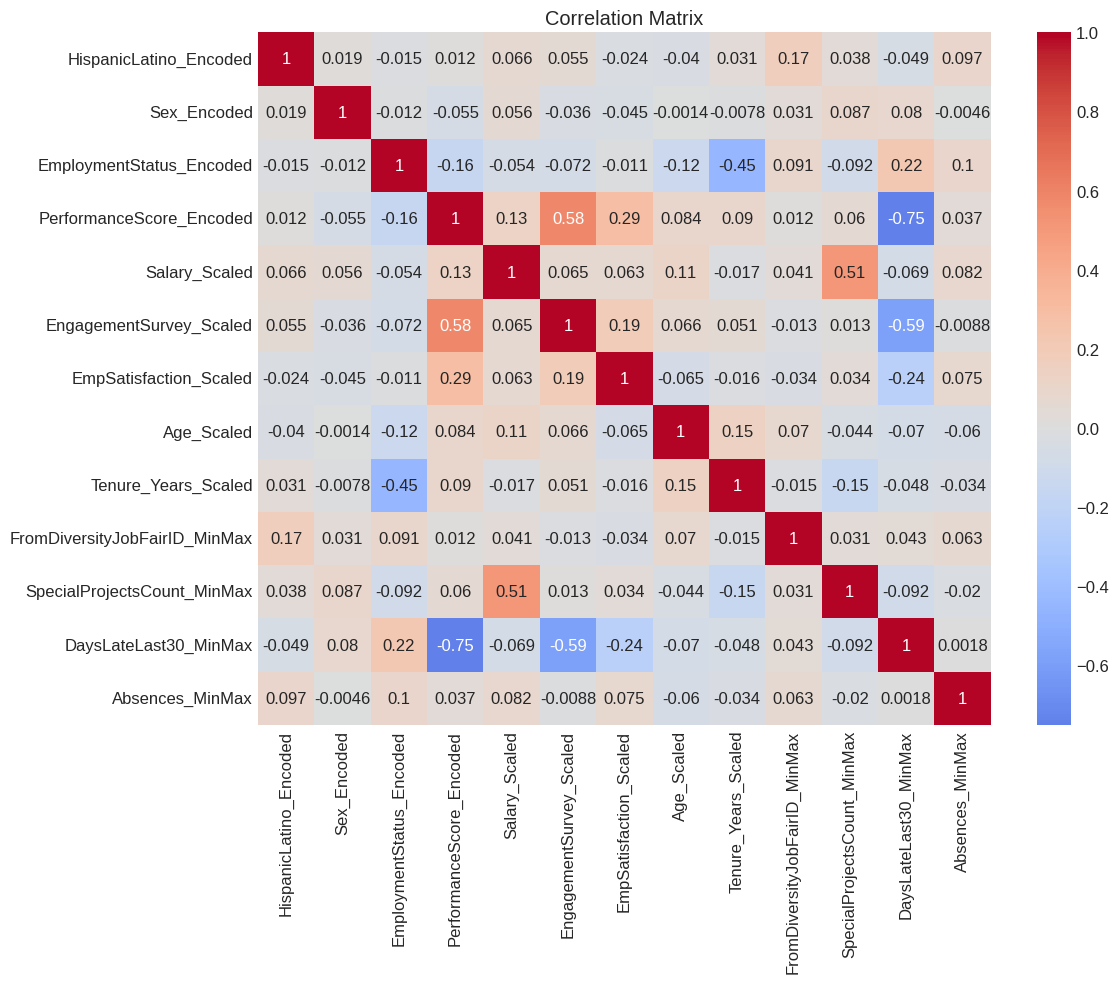


=== Highly Correlated Features (|r| > 0.7) ===
{'DaysLateLast30_MinMax'}


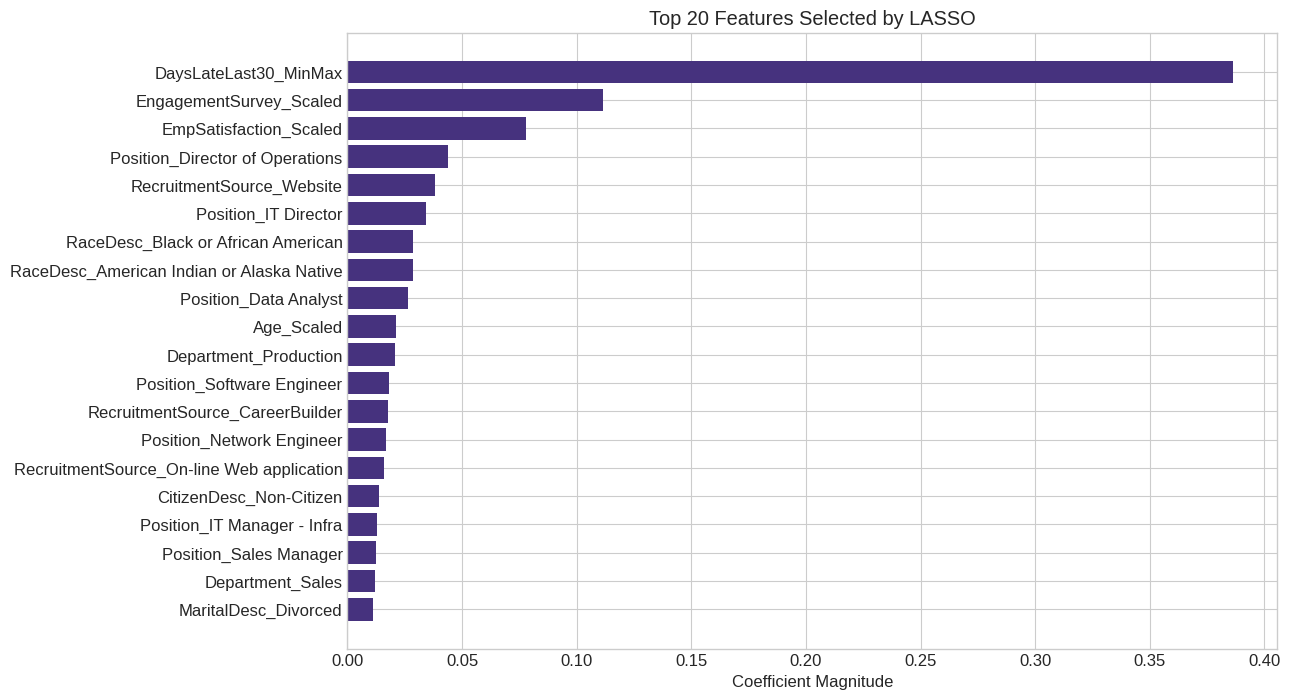


=== LASSO Feature Selection (alpha=0.01) ===
Selected 37 features out of 72
Top 10 features from LASSO:
                                      Feature  Importance
39                      DaysLateLast30_MinMax    0.386427
33                    EngagementSurvey_Scaled    0.111360
34                     EmpSatisfaction_Scaled    0.077980
50            Position_Director of Operations    0.043894
31                  RecruitmentSource_Website    0.038258
53                       Position_IT Director    0.034281
13         RaceDesc_Black or African American    0.028627
11  RaceDesc_American Indian or Alaska Native    0.028427
46                      Position_Data Analyst    0.026479
35                                 Age_Scaled    0.021060


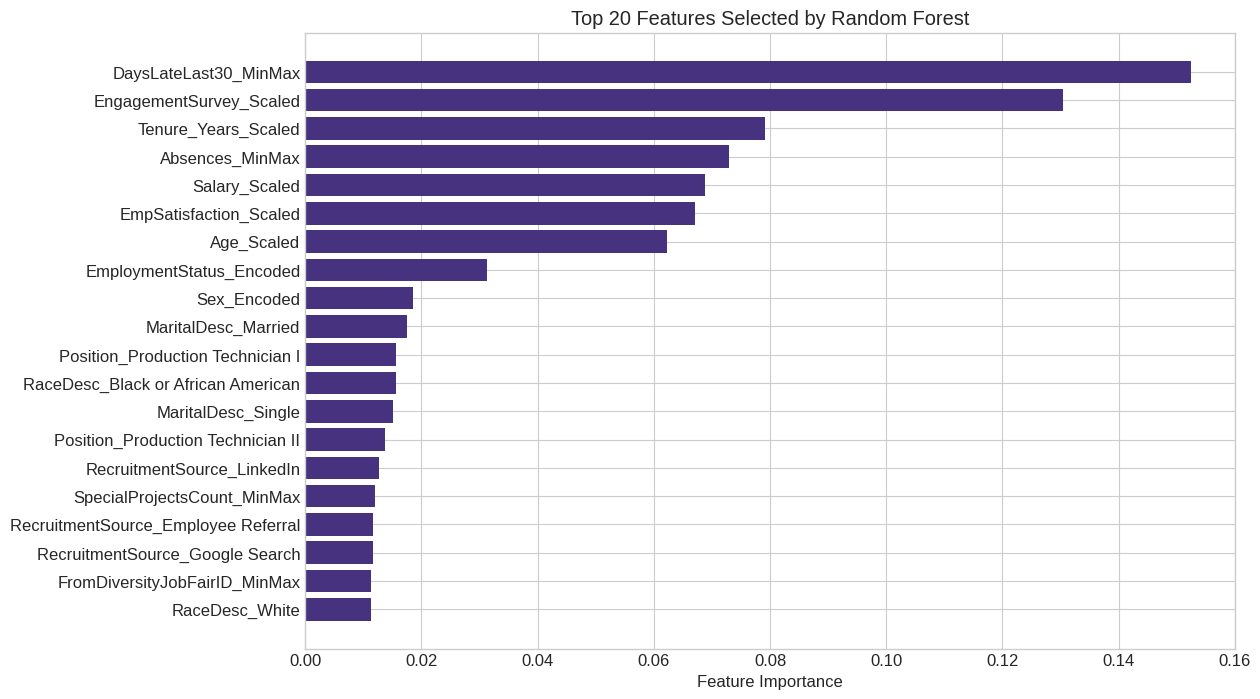


=== Random Forest Feature Selection ===
Top 20 features by importance:
                                Feature  Importance
39                DaysLateLast30_MinMax    0.152450
33              EngagementSurvey_Scaled    0.130455
36                  Tenure_Years_Scaled    0.079174
40                      Absences_MinMax    0.072988
32                        Salary_Scaled    0.068811
34               EmpSatisfaction_Scaled    0.067112
35                           Age_Scaled    0.062328
2              EmploymentStatus_Encoded    0.031208
1                           Sex_Encoded    0.018575
4                   MaritalDesc_Married    0.017461
62     Position_Production Technician I    0.015580
13   RaceDesc_Black or African American    0.015545
6                    MaritalDesc_Single    0.015122
63    Position_Production Technician II    0.013650
28           RecruitmentSource_LinkedIn    0.012728
38          SpecialProjectsCount_MinMax    0.011953
25  RecruitmentSource_Employee Referral    0

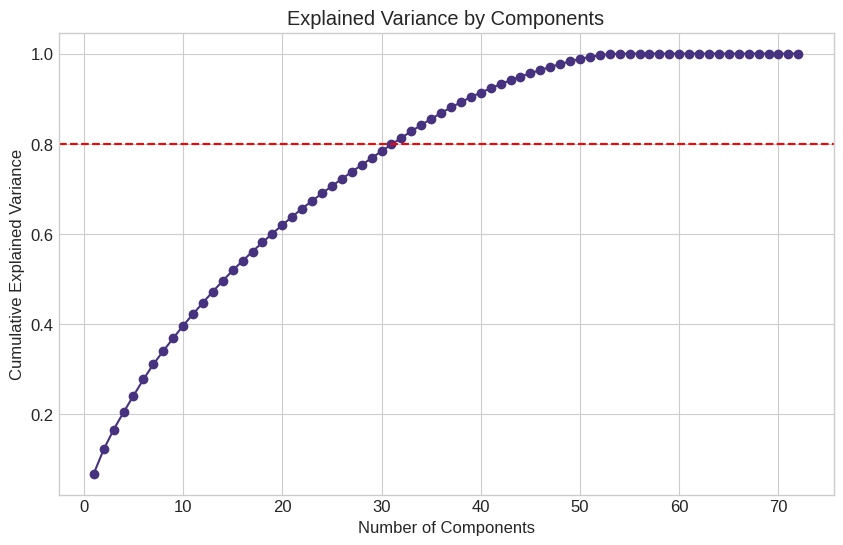


=== PCA Analysis ===
Number of components for 80% variance: 32
Explained variance ratio: [0.0689     0.05348655 0.04392874 0.03838984 0.03678632]

=== Recursive Feature Elimination ===
Running feature ranking (this may take a while)...

Feature ranking:
1. DaysLateLast30_MinMax (0.1525)
2. EngagementSurvey_Scaled (0.1305)
3. Tenure_Years_Scaled (0.0792)
4. Absences_MinMax (0.0730)
5. Salary_Scaled (0.0688)
6. EmpSatisfaction_Scaled (0.0671)
7. Age_Scaled (0.0623)
8. EmploymentStatus_Encoded (0.0312)
9. Sex_Encoded (0.0186)
10. MaritalDesc_Married (0.0175)
11. Position_Production Technician I (0.0156)
12. RaceDesc_Black or African American (0.0155)
13. MaritalDesc_Single (0.0151)
14. Position_Production Technician II (0.0137)
15. RecruitmentSource_LinkedIn (0.0127)
16. SpecialProjectsCount_MinMax (0.0120)
17. RecruitmentSource_Employee Referral (0.0117)
18. RecruitmentSource_Google Search (0.0116)
19. FromDiversityJobFairID_MinMax (0.0114)
20. RaceDesc_White (0.0113)


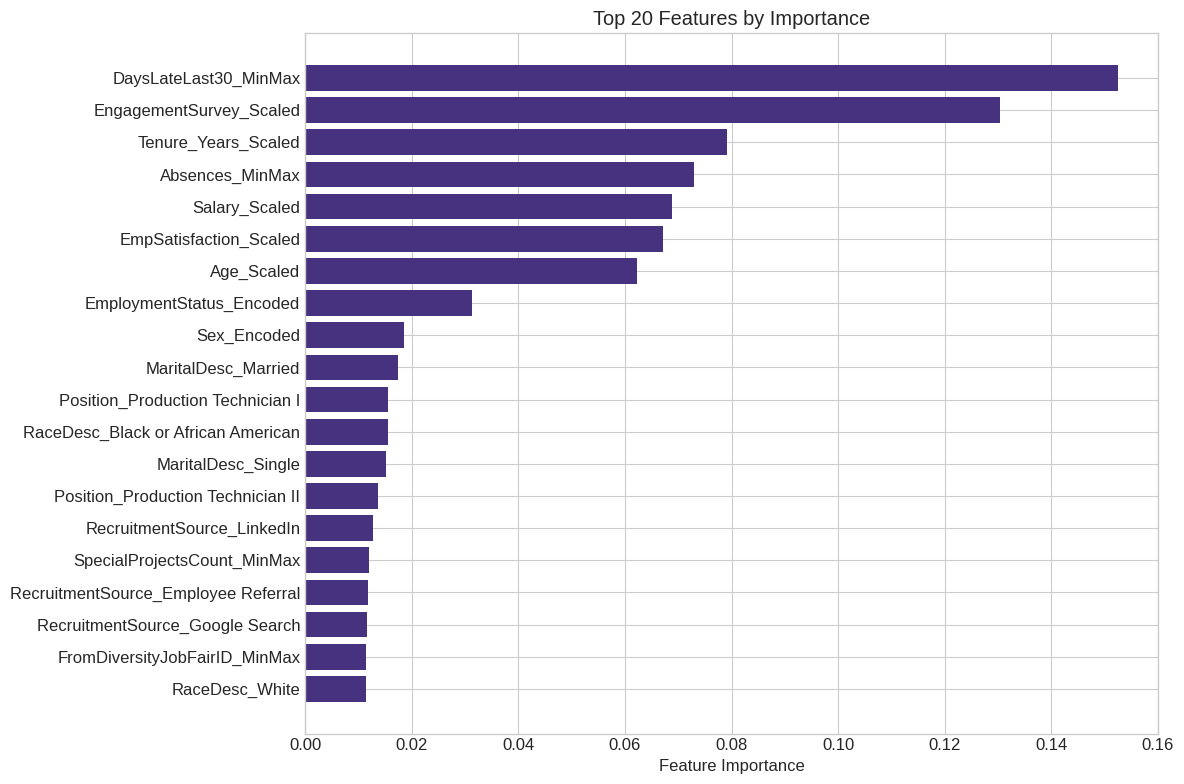


Evaluating different feature counts:
  Features: 5, CV Score: 0.8251
  Features: 10, CV Score: 0.8432
  Features: 15, CV Score: 0.8433
  Features: 20, CV Score: 0.8340
  Features: 25, CV Score: 0.8295
  Features: 30, CV Score: 0.8341
  Features: 40, CV Score: 0.8387
  Features: 50, CV Score: 0.8295


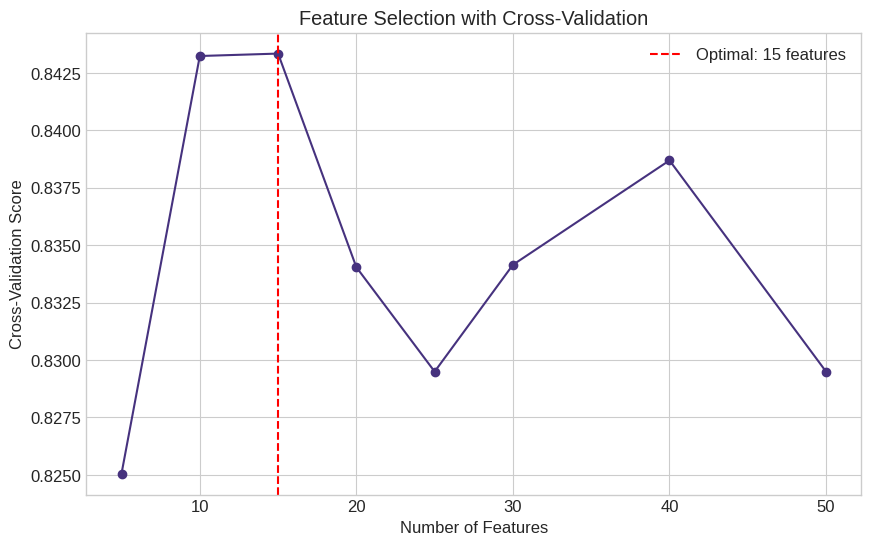


Optimal number of features: 15
Best CV score: 0.8433
Selected 15 features

Features selected by RFE:
['DaysLateLast30_MinMax', 'EngagementSurvey_Scaled', 'Tenure_Years_Scaled', 'Absences_MinMax', 'Salary_Scaled', 'EmpSatisfaction_Scaled', 'Age_Scaled', 'EmploymentStatus_Encoded', 'Sex_Encoded', 'MaritalDesc_Married', 'Position_Production Technician I', 'RaceDesc_Black or African American', 'MaritalDesc_Single', 'Position_Production Technician II', 'RecruitmentSource_LinkedIn']

=== Combined Feature Selection Results ===
Features selected by LASSO: 20
Features selected by Random Forest: 20
Features selected by RFE: 15
Consensus features (selected by at least 2 methods): 15
Consensus feature list: ['Absences_MinMax', 'Age_Scaled', 'DaysLateLast30_MinMax', 'EmpSatisfaction_Scaled', 'EmploymentStatus_Encoded', 'EngagementSurvey_Scaled', 'MaritalDesc_Married', 'MaritalDesc_Single', 'Position_Production Technician I', 'Position_Production Technician II', 'RaceDesc_Black or African American'

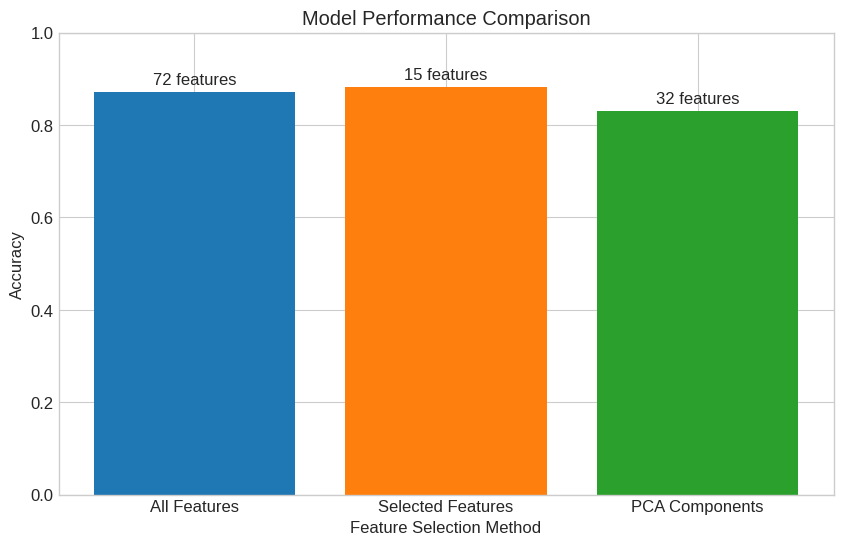


=== Feature Selection Summary ===
1. Redundant Features:
   - Multiple scaling versions of the same features were removed
2. Correlation-Based Selection:
   - Identified highly correlated feature pairs to avoid redundancy
3. LASSO Selection:
   - Selected 37 features with non-zero coefficients
4. Random Forest Importance:
   - Identified top features based on importance in tree-based model
5. Recursive Feature Elimination:
   - Selected 15 optimal features using cross-validation
6. PCA Analysis:
   - 32 components explain approximately 80% of variance
7. Consensus Features:
   - 15 features selected by at least 2 methods

Recommended approach:
1. Start with the consensus features as they were selected by multiple methods
2. If dimensionality is a major concern, consider using the PCA components
3. For interpretability, the selected original features are preferable over PCA


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, RFE, RFECV
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
# Replace with path to your dataset
df = pd.read_csv('final_cleaned_dataset.csv')

# Display basic info about the dataset
print(f"Dataset shape: {df.shape}")
print("\n=== First 5 rows of the dataset ===")
print(df.head())

# Step 1: Remove redundant scaled versions of same features
# Let's identify groups of redundant features based on name patterns

# Group features by their base name (before scaling suffix)
feature_groups = {}
scaled_suffixes = ['_Scaled', '_MinMax', '_Zscore']

for col in df.columns:
    # Check if column has any of the scaling suffixes
    base_name = None
    for suffix in scaled_suffixes:
        if col.endswith(suffix):
            base_name = col.replace(suffix, '')
            break

    if base_name:
        if base_name not in feature_groups:
            feature_groups[base_name] = []
        feature_groups[base_name].append(col)

# Print redundant feature groups
print("\n=== Redundant Feature Groups ===")
for base, variants in feature_groups.items():
    if len(variants) > 1:
        print(f"{base}: {variants}")

# Function to keep only one scaling type per feature
def remove_redundant_scalings(df, feature_groups, preferred_suffix='_Scaled'):
    """
    Keeps only one scaling version per feature, preferring the specified suffix.
    """
    columns_to_drop = []
    kept_columns = []

    for base, variants in feature_groups.items():
        if len(variants) > 1:
            # Find the preferred version if it exists
            preferred_version = [v for v in variants if v.endswith(preferred_suffix)]
            if preferred_version:
                kept_version = preferred_version[0]
            else:
                # If preferred suffix not found, keep the first one
                kept_version = variants[0]

            kept_columns.append(kept_version)
            # Add other versions to the drop list
            for variant in variants:
                if variant != kept_version:
                    columns_to_drop.append(variant)

    # Drop redundant columns
    df_reduced = df.drop(columns=columns_to_drop)
    print(f"\nRemoved {len(columns_to_drop)} redundant scaled features")
    print(f"Kept versions: {kept_columns}")

    return df_reduced

# Apply redundancy removal
df_reduced = remove_redundant_scalings(df, feature_groups)
print(f"Dataset shape after redundancy removal: {df_reduced.shape}")

# Step 2: Correlation-based Feature Selection
# Compute the correlation matrix for numerical features
numeric_cols = df_reduced.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = df_reduced[numeric_cols].corr()

# Visualize correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.savefig('correlation_matrix.png')
plt.show()

# Identify highly correlated feature pairs (threshold = 0.7)
def identify_correlated_features(correlation_matrix, threshold=0.7):
    correlated_features = set()

    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > threshold:
                feature_name = correlation_matrix.columns[i]
                correlated_features.add(feature_name)

    return correlated_features

correlated_features = identify_correlated_features(correlation_matrix, threshold=0.7)
print(f"\n=== Highly Correlated Features (|r| > 0.7) ===")
print(correlated_features)

# Step 3: Prepare data for further feature selection
# Assuming PerformanceScore_Encoded is our target
target_col = 'PerformanceScore_Encoded'
if target_col in df_reduced.columns:
    y = df_reduced[target_col]
    X = df_reduced.drop(columns=[target_col])
else:
    print(f"Target column {target_col} not found. Using the first column as a placeholder.")
    y = df_reduced.iloc[:, 0]
    X = df_reduced.iloc[:, 1:]

# Keep track of original column names
feature_names = X.columns.tolist()

# Convert categorical variables to numeric
X = pd.get_dummies(X, drop_first=True)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 4: Embedded Feature Selection with LASSO
def lasso_feature_selection(X_train, y_train, X_test, feature_names, alpha=0.01):
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Fit Lasso
    lasso = Lasso(alpha=alpha, random_state=42)
    lasso.fit(X_train_scaled, y_train)

    # Get feature importance
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': np.abs(lasso.coef_)
    })

    # Sort by importance
    feature_importance = feature_importance.sort_values('Importance', ascending=False)

    # Plot importance
    plt.figure(figsize=(12, 8))
    plt.barh(feature_importance['Feature'].head(20), feature_importance['Importance'].head(20))
    plt.xlabel('Coefficient Magnitude')
    plt.title('Top 20 Features Selected by LASSO')
    plt.gca().invert_yaxis()  # Display the most important at the top
    plt.savefig('lasso_feature_importance.png')
    plt.show()

    # Select features with non-zero coefficients
    selected_features = feature_importance[feature_importance['Importance'] > 0]

    print(f"\n=== LASSO Feature Selection (alpha={alpha}) ===")
    print(f"Selected {len(selected_features)} features out of {len(feature_names)}")

    return selected_features, lasso

# Apply LASSO feature selection
lasso_selected_features, lasso_model = lasso_feature_selection(
    X_train, y_train, X_test, X.columns
)
print("Top 10 features from LASSO:")
print(lasso_selected_features.head(10))

# Step 5: Random Forest Feature Importance
def random_forest_feature_selection(X_train, y_train, X_test, feature_names):
    # Convert to classification problem if needed (performance categories)
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)

    # Get feature importance
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': rf.feature_importances_
    })

    # Sort by importance
    feature_importance = feature_importance.sort_values('Importance', ascending=False)

    # Plot importance
    plt.figure(figsize=(12, 8))
    plt.barh(feature_importance['Feature'].head(20), feature_importance['Importance'].head(20))
    plt.xlabel('Feature Importance')
    plt.title('Top 20 Features Selected by Random Forest')
    plt.gca().invert_yaxis()
    plt.savefig('rf_feature_importance.png')
    plt.show()

    print(f"\n=== Random Forest Feature Selection ===")
    print(f"Top 20 features by importance:")

    return feature_importance, rf

# Apply Random Forest feature selection
rf_feature_importance, rf_model = random_forest_feature_selection(
    X_train, y_train, X_test, X.columns
)
print(rf_feature_importance.head(20))

# Step 6: Principal Component Analysis (PCA)
def pca_analysis(X_train, X_test):
    # Standardize the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Apply PCA
    pca = PCA()
    pca.fit(X_train_scaled)

    # Calculate cumulative explained variance
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

    # Plot explained variance
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
    plt.axhline(y=0.8, color='r', linestyle='--')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Explained Variance by Components')
    plt.grid(True)
    plt.savefig('pca_explained_variance.png')
    plt.show()

    # Determine number of components for 80% variance
    n_components = np.argmax(cumulative_variance >= 0.8) + 1

    print(f"\n=== PCA Analysis ===")
    print(f"Number of components for 80% variance: {n_components}")
    print(f"Explained variance ratio: {pca.explained_variance_ratio_[:5]}")

    # Apply PCA with selected number of components
    pca_selected = PCA(n_components=n_components)
    X_train_pca = pca_selected.fit_transform(X_train_scaled)
    X_test_pca = pca_selected.transform(X_test_scaled)

    # Return the PCA model and transformed data
    return pca_selected, X_train_pca, X_test_pca

# Apply PCA
pca_model, X_train_pca, X_test_pca = pca_analysis(X_train, X_test)

# Step 7: Recursive Feature Elimination (RFE)
def recursive_feature_elimination(X_train, y_train, feature_names, step=1):
    """
    Simpler implementation of recursive feature elimination that works with pandas DataFrames
    """
    print("\n=== Recursive Feature Elimination ===")
    print("Running feature ranking (this may take a while)...")

    # Use a Random Forest model for ranking features
    model = RandomForestClassifier(n_estimators=100, random_state=42)

    # Train the model on all features
    model.fit(X_train, y_train)

    # Get feature importances
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]  # Sort in descending order

    # Print feature ranking
    print("\nFeature ranking:")
    feature_ranks = []
    for f in range(min(20, X_train.shape[1])):
        idx = indices[f]
        feature_ranks.append({
            'Rank': f+1,
            'Feature': feature_names[idx],
            'Importance': importances[idx]
        })
        print(f"{f+1}. {feature_names[idx]} ({importances[idx]:.4f})")

    # Create DataFrame for results
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)

    # Plot feature importance
    plt.figure(figsize=(12, 8))
    top_n = min(20, len(feature_names))
    plt.barh(feature_importance_df['Feature'].head(top_n),
             feature_importance_df['Importance'].head(top_n))
    plt.xlabel('Feature Importance')
    plt.title(f'Top {top_n} Features by Importance')
    plt.gca().invert_yaxis()  # Display the most important at the top
    plt.tight_layout()
    plt.savefig('rfe_feature_importance.png')
    plt.show()

    # Evaluate model performance with different numbers of top features
    n_features_range = [5, 10, 15, 20, 25, 30, 40, 50]
    n_features_range = [n for n in n_features_range if n <= X_train.shape[1]]
    cv_scores = []

    print("\nEvaluating different feature counts:")
    for n_features in n_features_range:
        # Get top n features
        top_indices = indices[:n_features]
        top_features = [feature_names[i] for i in top_indices]

        # Subset data
        X_train_subset = X_train[top_features]

        # Perform cross-validation
        scores = cross_val_score(
            estimator=RandomForestClassifier(n_estimators=100, random_state=42),
            X=X_train_subset,
            y=y_train,
            cv=5,
            scoring='accuracy'
        )
        mean_score = np.mean(scores)
        cv_scores.append(mean_score)
        print(f"  Features: {n_features}, CV Score: {mean_score:.4f}")

    # Find optimal feature count
    optimal_idx = np.argmax(cv_scores)
    optimal_n_features = n_features_range[optimal_idx]

    # Plot number of features vs. CV score
    plt.figure(figsize=(10, 6))
    plt.plot(n_features_range, cv_scores, marker='o')
    plt.axvline(x=optimal_n_features, color='r', linestyle='--',
                label=f'Optimal: {optimal_n_features} features')
    plt.xlabel('Number of Features')
    plt.ylabel('Cross-Validation Score')
    plt.title('Feature Selection with Cross-Validation')
    plt.grid(True)
    plt.legend()
    plt.savefig('feature_selection_cv_scores.png')
    plt.show()

    # Create the final selected features DataFrame
    top_indices = indices[:optimal_n_features]
    selected_features_list = [feature_names[i] for i in top_indices]

    selected_features = pd.DataFrame({
        'Feature': feature_names,
        'Selected': [name in selected_features_list for name in feature_names]
    })

    selected_features_sorted = selected_features[selected_features['Selected'] == True].copy()

    # Add importance values to the selected features
    selected_features_sorted['Importance'] = selected_features_sorted['Feature'].map(
        dict(zip(feature_names, importances))
    )
    selected_features_sorted = selected_features_sorted.sort_values('Importance', ascending=False)

    print(f"\nOptimal number of features: {optimal_n_features}")
    print(f"Best CV score: {cv_scores[optimal_idx]:.4f}")
    print(f"Selected {len(selected_features_list)} features\n")

    # Return a simple RFE-like model for consistency
    class SimpleRFE:
        def __init__(self, support, n_features):
            self.support_ = support
            self.n_features_ = n_features

    support = np.array([name in selected_features_list for name in feature_names])
    simple_rfe = SimpleRFE(support, optimal_n_features)

    return selected_features_sorted, simple_rfe

# Apply RFE
rfe_selected_features, rfe_model = recursive_feature_elimination(X_train, y_train, X.columns)
print("Features selected by RFE:")
print(rfe_selected_features['Feature'].tolist())

# Step 8: Compare and combine results to get final feature set
def combine_feature_selection_results(lasso_features, rf_features, rfe_features, top_n=20):
    # Get top N features from each method
    lasso_top = set(lasso_features['Feature'].head(top_n))
    rf_top = set(rf_features['Feature'].head(top_n))
    rfe_top = set(rfe_features['Feature'])

    # Find features selected by at least 2 methods
    consensus_features = set()
    for feature in (lasso_top | rf_top | rfe_top):
        count = sum([
            feature in lasso_top,
            feature in rf_top,
            feature in rfe_top
        ])
        if count >= 2:
            consensus_features.add(feature)

    # Create a visualization of the feature overlap
    # First, try to use matplotlib_venn if available
    try:
        from matplotlib_venn import venn3
        plt.figure(figsize=(10, 8))
        venn3([lasso_top, rf_top, rfe_top],
              set_labels=('LASSO', 'Random Forest', 'RFE'))
        plt.title('Overlap in Selected Features')
        plt.savefig('feature_selection_overlap.png')
        plt.close()
    except ImportError:
        # If matplotlib_venn is not available, create a simple bar chart instead
        print("matplotlib_venn not installed. Creating a simple overlap visualization.")
        overlap_count = {
            'LASSO only': len(lasso_top - rf_top - rfe_top),
            'RF only': len(rf_top - lasso_top - rfe_top),
            'RFE only': len(rfe_top - lasso_top - rf_top),
            'LASSO & RF': len(lasso_top & rf_top - rfe_top),
            'LASSO & RFE': len(lasso_top & rfe_top - rf_top),
            'RF & RFE': len(rf_top & rfe_top - lasso_top),
            'All three': len(lasso_top & rf_top & rfe_top)
        }

        plt.figure(figsize=(12, 6))
        bars = plt.bar(overlap_count.keys(), overlap_count.values())

        # Add count labels on top of bars
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                    f'{height}', ha='center', va='bottom')

        plt.xlabel('Feature Selection Method Overlap')
        plt.ylabel('Number of Features')
        plt.title('Feature Selection Method Overlap')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig('feature_selection_overlap.png')
        plt.show()

    print(f"\n=== Combined Feature Selection Results ===")
    print(f"Features selected by LASSO: {len(lasso_top)}")
    print(f"Features selected by Random Forest: {len(rf_top)}")
    print(f"Features selected by RFE: {len(rfe_top)}")
    print(f"Consensus features (selected by at least 2 methods): {len(consensus_features)}")
    print(f"Consensus feature list: {sorted(list(consensus_features))}")

    return consensus_features

# Get consensus features
final_features = combine_feature_selection_results(
    lasso_selected_features,
    rf_feature_importance,
    rfe_selected_features
)

# Step 9: Evaluate model performance with the selected features
def evaluate_feature_sets(X_train, X_test, y_train, y_test, final_features, X_train_pca, X_test_pca):
    # Original feature set
    model_full = RandomForestClassifier(n_estimators=100, random_state=42)
    model_full.fit(X_train, y_train)
    y_pred_full = model_full.predict(X_test)
    accuracy_full = accuracy_score(y_test, y_pred_full)

    # Selected feature set - handle case when final_features is empty
    if final_features and len(final_features) > 0:
        # Convert to list and check if all features exist in the dataframe
        features_list = list(final_features)
        existing_features = [f for f in features_list if f in X_train.columns]

        if len(existing_features) > 0:
            X_train_selected = X_train[existing_features]
            X_test_selected = X_test[existing_features]

            model_selected = RandomForestClassifier(n_estimators=100, random_state=42)
            model_selected.fit(X_train_selected, y_train)
            y_pred_selected = model_selected.predict(X_test_selected)
            accuracy_selected = accuracy_score(y_test, y_pred_selected)
            feature_count = len(existing_features)
        else:
            print("Warning: None of the consensus features found in dataset. Skipping selected features evaluation.")
            accuracy_selected = 0
            feature_count = 0
    else:
        print("Warning: No consensus features found. Skipping selected features evaluation.")
        accuracy_selected = 0
        feature_count = 0

    # PCA transformed data - make sure PCA data exists
    if X_train_pca is not None and X_test_pca is not None:
        model_pca = RandomForestClassifier(n_estimators=100, random_state=42)
        model_pca.fit(X_train_pca, y_train)
        y_pred_pca = model_pca.predict(X_test_pca)
        accuracy_pca = accuracy_score(y_test, y_pred_pca)
        pca_count = X_train_pca.shape[1]
    else:
        print("Warning: PCA data not provided. Skipping PCA evaluation.")
        accuracy_pca = 0
        pca_count = 0

    print(f"\n=== Model Performance Comparison ===")
    print(f"Accuracy with all features ({X_train.shape[1]}): {accuracy_full:.4f}")

    if feature_count > 0:
        print(f"Accuracy with selected features ({feature_count}): {accuracy_selected:.4f}")

    if pca_count > 0:
        print(f"Accuracy with PCA components ({pca_count}): {accuracy_pca:.4f}")

    # Plot comparison - only include methods with valid accuracies
    models = ['All Features']
    accuracies = [accuracy_full]
    feature_counts = [X_train.shape[1]]

    if feature_count > 0:
        models.append('Selected Features')
        accuracies.append(accuracy_selected)
        feature_counts.append(feature_count)

    if pca_count > 0:
        models.append('PCA Components')
        accuracies.append(accuracy_pca)
        feature_counts.append(pca_count)

    plt.figure(figsize=(10, 6))
    bar_colors = ['#1f77b4', '#ff7f0e', '#2ca02c'][:len(models)]
    bars = plt.bar(models, accuracies, color=bar_colors)

    # Add feature counts on top of bars
    for bar, count in zip(bars, feature_counts):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                str(count) + ' features', ha='center', va='bottom')

    plt.xlabel('Feature Selection Method')
    plt.ylabel('Accuracy')
    plt.title('Model Performance Comparison')
    plt.ylim([0, 1])
    plt.savefig('model_performance_comparison.png')
    plt.show()

# Evaluate models with different feature sets
evaluate_feature_sets(X_train, X_test, y_train, y_test, final_features, X_train_pca, X_test_pca)

# Summary of findings
print("\n=== Feature Selection Summary ===")
print("1. Redundant Features:")
print("   - Multiple scaling versions of the same features were removed")
print("2. Correlation-Based Selection:")
print("   - Identified highly correlated feature pairs to avoid redundancy")
print("3. LASSO Selection:")
print(f"   - Selected {len(lasso_selected_features)} features with non-zero coefficients")
print("4. Random Forest Importance:")
print("   - Identified top features based on importance in tree-based model")
print("5. Recursive Feature Elimination:")
print(f"   - Selected {len(rfe_selected_features)} optimal features using cross-validation")
print("6. PCA Analysis:")
print(f"   - {pca_model.n_components_} components explain approximately 80% of variance")
print("7. Consensus Features:")
print(f"   - {len(final_features)} features selected by at least 2 methods")
print("\nRecommended approach:")
print("1. Start with the consensus features as they were selected by multiple methods")
print("2. If dimensionality is a major concern, consider using the PCA components")
print("3. For interpretability, the selected original features are preferable over PCA")

**Which is suitable ADASYN Or SMOTE**

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, ADASYN
from collections import Counter
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load the dataset
df = pd.read_csv('final_cleaned_dataset.csv')

# Print original class distribution
print("Original class distribution:")
print(df['PerformanceScore_Encoded'].value_counts())
print()

# Check for non-numeric columns
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
categorical_cols = df.select_dtypes(exclude=['number']).columns.tolist()

print(f"Numeric columns: {len(numeric_cols)}")
print(f"Categorical columns: {len(categorical_cols)}")

if 'Position' in df.columns and 'Position' not in categorical_cols:
    categorical_cols.append('Position')

if 'PerformanceScore_Encoded' in numeric_cols:
    numeric_cols.remove('PerformanceScore_Encoded')

# Remove categorical columns that are already one-hot encoded (True/False values)
true_categorical_cols = []
for col in categorical_cols:
    if df[col].nunique() > 2 or df[col].dtype == 'object':
        true_categorical_cols.append(col)

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), true_categorical_cols)
    ])

# Separate features and target variable
X = df.drop('PerformanceScore_Encoded', axis=1)
y = df['PerformanceScore_Encoded']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Apply preprocessing
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

print(f"Transformed X_train shape: {X_train_scaled.shape}")

print("Training set class distribution before oversampling:")
print(Counter(y_train))
print()

# Function to train SVM and evaluate
def train_and_evaluate(X_train, y_train, X_test, y_test, model_name):
    # Train an SVM classifier
    svm = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True)
    svm.fit(X_train, y_train)

    # Make predictions
    y_pred = svm.predict(X_test)

    # Evaluate
    print(f"=== {model_name} ===")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print()

# 1. Train model without oversampling
print("Training SVM without oversampling...")
train_and_evaluate(X_train_scaled, y_train, X_test_scaled, y_test, "No Oversampling")

# 2. Apply SMOTE oversampling
print("Applying SMOTE oversampling...")
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)
print("Training set class distribution after SMOTE:")
print(Counter(y_train_smote))
print()

train_and_evaluate(X_train_smote, y_train_smote, X_test_scaled, y_test, "SMOTE")

# 3. Apply ADASYN oversampling
print("Applying ADASYN oversampling...")
adasyn = ADASYN(random_state=42)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train_scaled, y_train)
print("Training set class distribution after ADASYN:")
print(Counter(y_train_adasyn))
print()

train_and_evaluate(X_train_adasyn, y_train_adasyn, X_test_scaled, y_test, "ADASYN")

# 4. Fine-tuned SVM with SMOTE (to reduce overfitting)
print("Training fine-tuned SVM with SMOTE...")
svm_tuned = SVC(kernel='rbf', C=0.1, gamma='auto', probability=True)
svm_tuned.fit(X_train_smote, y_train_smote)
y_pred_tuned = svm_tuned.predict(X_test_scaled)

print("=== Fine-tuned SVM with SMOTE ===")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_tuned))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_tuned))

Original class distribution:
PerformanceScore_Encoded
3    243
4     37
2     18
1     13
Name: count, dtype: int64

Numeric columns: 27
Categorical columns: 30
Transformed X_train shape: (248, 53)
Training set class distribution before oversampling:
Counter({3: 194, 4: 30, 2: 14, 1: 10})

Training SVM without oversampling...
=== No Oversampling ===
Confusion Matrix:
[[ 2  1  0  0]
 [ 0  3  1  0]
 [ 0  0 49  0]
 [ 0  0  7  0]]

Classification Report:
              precision    recall  f1-score   support

           1       1.00      0.67      0.80         3
           2       0.75      0.75      0.75         4
           3       0.86      1.00      0.92        49
           4       0.00      0.00      0.00         7

    accuracy                           0.86        63
   macro avg       0.65      0.60      0.62        63
weighted avg       0.76      0.86      0.80        63


Applying SMOTE oversampling...
Training set class distribution after SMOTE:
Counter({3: 194, 4: 194, 2: 194, 

**ADASYN Resampling**

In [15]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import ADASYN
from sklearn.preprocessing import StandardScaler

# Load the original dataset
df = pd.read_csv('final_cleaned_dataset.csv')

print(f"Original dataset shape: {df.shape}")
print(f"Class distribution before ADASYN:")
print(df['PerformanceScore_Encoded'].value_counts())
print(df['PerformanceScore_Encoded'].value_counts(normalize=True).round(3) * 100)

# ========================
# Create all required features with correct names
# ========================

# List of consensus features we need to make sure exist in the final dataset
consensus_features = [
    'DaysLateLast30_MinMax',
    'EngagementSurvey_Scaled',
    'Tenure_Years_Scaled',
    'Absences_MinMax',
    'Salary_Scaled',
    'EmpSatisfaction_Scaled',
    'Age_Scaled',
    'EmploymentStatus_Encoded',
    'Sex_Encoded',
    'MaritalDesc_Married',
    'RaceDesc_Black or African American',
    'MaritalDesc_Single',
    'Position_Production Technician I',
    'Position_Production Technician II',
    'RecruitmentSource_LinkedIn'
]

# Create the two missing Position features
if 'Position' in df.columns:
    df['Position_Production Technician I'] = (df['Position'] == 'Production Technician I').astype(float)
    df['Position_Production Technician II'] = (df['Position'] == 'Production Technician II').astype(float)
else:
    print("Warning: 'Position' column not found. Creating dummy position columns.")
    df['Position_Production Technician I'] = 0.0
    df['Position_Production Technician II'] = 0.0

# Verify all other features exist or create them from raw data if needed
# This handles cases where we need to transform raw features into expected formats

# Check for _Scaled features and create them if they don't exist
for feature in ['EngagementSurvey', 'Tenure_Years', 'Salary', 'EmpSatisfaction', 'Age']:
    scaled_feature = f"{feature}_Scaled"
    if scaled_feature not in df.columns and feature in df.columns:
        # Apply Min-Max scaling to create _Scaled version
        df[scaled_feature] = (df[feature] - df[feature].min()) / (df[feature].max() - df[feature].min())
        print(f"Created {scaled_feature} from {feature}")

# Check for binary categorical features and create them if needed
if 'MaritalDesc' in df.columns:
    if 'MaritalDesc_Married' not in df.columns:
        df['MaritalDesc_Married'] = (df['MaritalDesc'] == 'Married').astype(float)
        print("Created MaritalDesc_Married")
    if 'MaritalDesc_Single' not in df.columns:
        df['MaritalDesc_Single'] = (df['MaritalDesc'] == 'Single').astype(float)
        print("Created MaritalDesc_Single")

if 'RaceDesc' in df.columns and 'RaceDesc_Black or African American' not in df.columns:
    df['RaceDesc_Black or African American'] = (df['RaceDesc'] == 'Black or African American').astype(float)
    print("Created RaceDesc_Black or African American")

if 'RecruitmentSource' in df.columns and 'RecruitmentSource_LinkedIn' not in df.columns:
    df['RecruitmentSource_LinkedIn'] = (df['RecruitmentSource'] == 'LinkedIn').astype(float)
    print("Created RecruitmentSource_LinkedIn")

# Create encoded features if needed
if 'Sex' in df.columns and 'Sex_Encoded' not in df.columns:
    df['Sex_Encoded'] = df['Sex'].map({'F': 0, 'M': 1})
    print("Created Sex_Encoded")

if 'EmploymentStatus' in df.columns and 'EmploymentStatus_Encoded' not in df.columns:
    df['EmploymentStatus_Encoded'] = df['EmploymentStatus'].map({'Active': 1, 'Terminated': 0})
    print("Created EmploymentStatus_Encoded")

# Create MinMax features if needed
if 'Absences' in df.columns and 'Absences_MinMax' not in df.columns:
    df['Absences_MinMax'] = (df['Absences'] - df['Absences'].min()) / (df['Absences'].max() - df['Absences'].min())
    print("Created Absences_MinMax")

if 'DaysLateLast30' in df.columns and 'DaysLateLast30_MinMax' not in df.columns:
    df['DaysLateLast30_MinMax'] = (df['DaysLateLast30'] - df['DaysLateLast30'].min()) / (df['DaysLateLast30'].max() - df['DaysLateLast30'].min())
    print("Created DaysLateLast30_MinMax")

# ========================
# Prepare data for ADASYN
# ========================

# Check which consensus features are actually available
available_features = [col for col in consensus_features if col in df.columns]
missing_features = [col for col in consensus_features if col not in df.columns]

if missing_features:
    print(f"\nWarning: The following features are still missing: {missing_features}")
    print("These features will not be used in the model.")

print(f"\nUsing {len(available_features)} consensus features: {available_features}")

# Separate target variable
y = df['PerformanceScore_Encoded']
X = df[available_features]  # Only use available consensus features

# ========================
# ADASYN Oversampling
# ========================

# Apply ADASYN
n_neighbors = min(5, min(y.value_counts()) - 1)  # k_neighbors must be <= n_samples - 1
print(f"Using n_neighbors = {n_neighbors} for ADASYN")

adasyn = ADASYN(random_state=42, n_neighbors=n_neighbors)
X_adasyn, y_adasyn = adasyn.fit_resample(X, y)

print(f"\nADASYN dataset shape: {X_adasyn.shape}")
print(f"Class distribution after ADASYN:")
unique, counts = np.unique(y_adasyn, return_counts=True)
for class_label, count in zip(unique, counts):
    print(f"Class {class_label}: {count} ({count/len(y_adasyn)*100:.1f}%)")

# ========================
# Create final dataframe for saving
# ========================

# Create DataFrame with the ADASYN-generated data
adasyn_df = pd.DataFrame(X_adasyn, columns=available_features)
adasyn_df['PerformanceScore_Encoded'] = y_adasyn

# Save the ADASYN dataset to CSV
adasyn_df.to_csv('employee_data_adasyn.csv', index=False)

print("\nADASYN dataset has been created and saved successfully!")

Original dataset shape: (311, 57)
Class distribution before ADASYN:
PerformanceScore_Encoded
3    243
4     37
2     18
1     13
Name: count, dtype: int64
PerformanceScore_Encoded
3    78.1
4    11.9
2     5.8
1     4.2
Name: proportion, dtype: float64

Using 15 consensus features: ['DaysLateLast30_MinMax', 'EngagementSurvey_Scaled', 'Tenure_Years_Scaled', 'Absences_MinMax', 'Salary_Scaled', 'EmpSatisfaction_Scaled', 'Age_Scaled', 'EmploymentStatus_Encoded', 'Sex_Encoded', 'MaritalDesc_Married', 'RaceDesc_Black or African American', 'MaritalDesc_Single', 'Position_Production Technician I', 'Position_Production Technician II', 'RecruitmentSource_LinkedIn']
Using n_neighbors = 5 for ADASYN

ADASYN dataset shape: (959, 15)
Class distribution after ADASYN:
Class 1: 241 (25.1%)
Class 2: 240 (25.0%)
Class 3: 243 (25.3%)
Class 4: 235 (24.5%)

ADASYN dataset has been created and saved successfully!


**SVM Model Training**

Dataset shape: (959, 16)

First few rows:
   DaysLateLast30_MinMax  EngagementSurvey_Scaled  Tenure_Years_Scaled  \
0                    0.0                 0.896907             0.573643   
1                    0.0                 0.989691             0.062016   
2                    0.0                 0.489691             0.062016   
3                    0.0                 0.958763             0.844961   
4                    0.0                 1.000000             0.348837   

   Absences_MinMax  Salary_Scaled  EmpSatisfaction_Scaled  Age_Scaled  \
0         0.000000       0.085190                    1.00    0.288889   
1         0.842105       0.289777                    0.50    0.400000   
2         0.105263       0.097139                    0.50    0.022222   
3         0.736842       0.097315                    1.00    0.155556   
4         0.052632       0.028197                    0.75    0.066667   

   EmploymentStatus_Encoded  Sex_Encoded  MaritalDesc_Married  \
0        

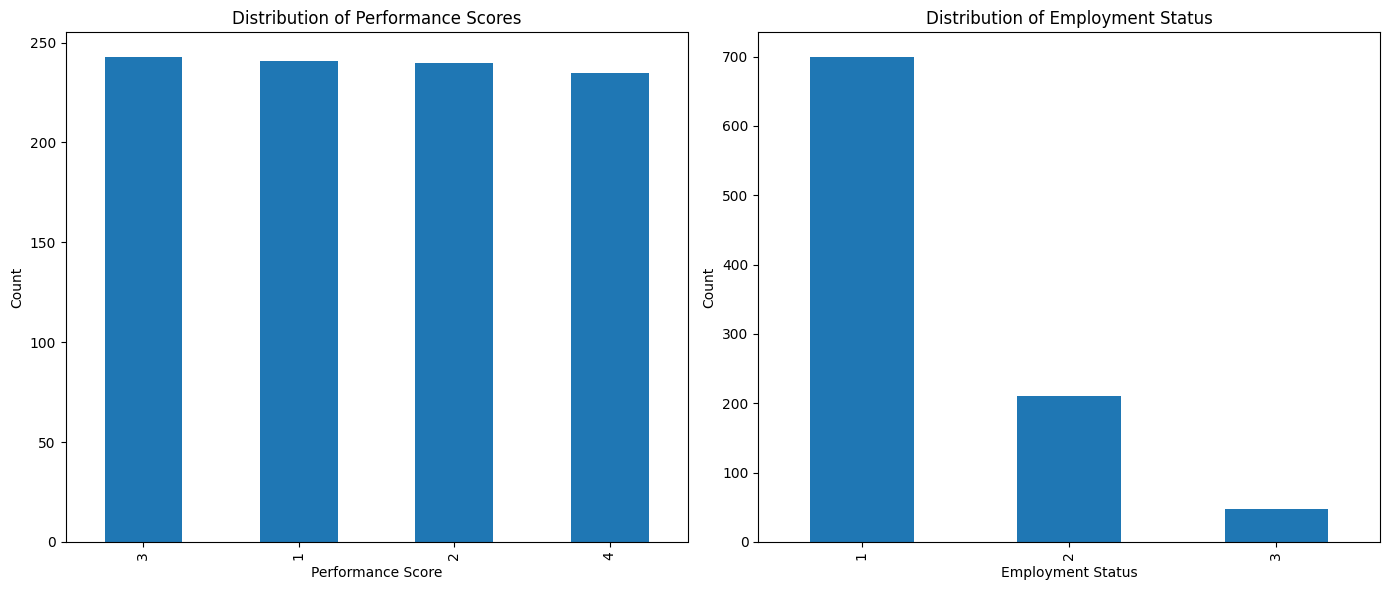

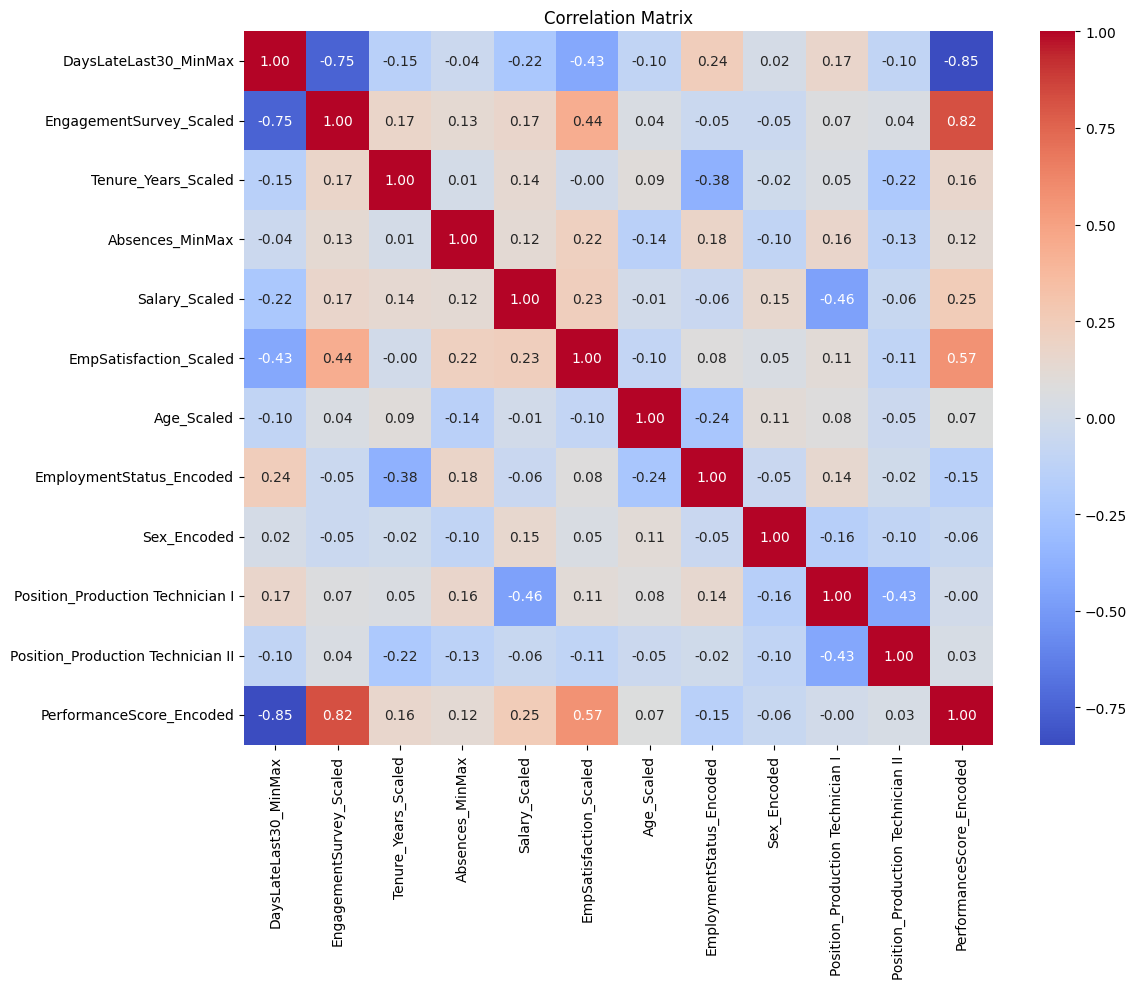


Numerical columns: ['DaysLateLast30_MinMax', 'EngagementSurvey_Scaled', 'Tenure_Years_Scaled', 'Absences_MinMax', 'Salary_Scaled', 'EmpSatisfaction_Scaled', 'Age_Scaled', 'EmploymentStatus_Encoded', 'Sex_Encoded', 'Position_Production Technician I', 'Position_Production Technician II']
Categorical columns: ['MaritalDesc_Married', 'RaceDesc_Black or African American', 'MaritalDesc_Single', 'RecruitmentSource_LinkedIn']

Training set shape: (767, 15), Testing set shape: (192, 15)
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Best parameters: {'classifier__C': 10, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}
Best cross-validation score: 0.9374

Model Evaluation:
Accuracy: 0.953125

Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        48
           2       1.00      1.00      1.00        48
           3       0.98      0.84      0.90        49
           4       0.85      0.98      0

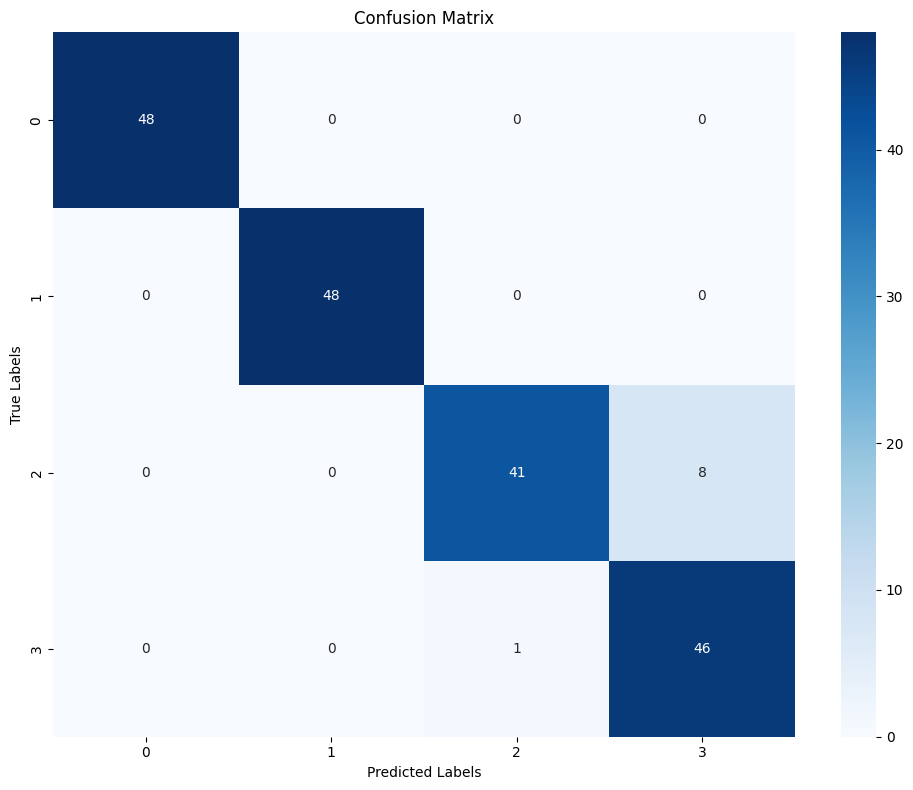


Model saved as 'svm_employee_model.pkl'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Feature importance analysis is only available for linear kernel


In [11]:
# SVM Training for Employee Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from google.colab import files
import io

'''# Upload the dataset in Google Colab
uploaded = files.upload()  # This will prompt you to upload your CSV file
file_name = list(uploaded.keys())[0]  # Get the filename of the uploaded file'''

# Read the dataset
df = pd.read_csv('employee_data_adasyn.csv')

# Display basic information
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nData types:")
print(df.dtypes)
print("\nSummary statistics:")
print(df.describe())

# Check for missing values
print("\nMissing values count:")
print(df.isnull().sum())

# Convert string True/False to boolean for relevant columns
string_bool_columns = [col for col in df.columns if df[col].dtype == 'object' and
                       set(df[col].unique()).issubset({"True", "False"})]
for col in string_bool_columns:
    df[col] = df[col].map({"True": True, "False": False})

# Visualize distribution of potential target variables
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Assuming PerformanceScore_Encoded is the target variable
df['PerformanceScore_Encoded'].value_counts().plot(kind='bar', ax=axes[0])
axes[0].set_title('Distribution of Performance Scores')
axes[0].set_xlabel('Performance Score')
axes[0].set_ylabel('Count')

# Employment Status distribution
df['EmploymentStatus_Encoded'].value_counts().plot(kind='bar', ax=axes[1])
axes[1].set_title('Distribution of Employment Status')
axes[1].set_xlabel('Employment Status')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

# Correlation analysis
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
plt.figure(figsize=(12, 10))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

# Define features and target variable - you can change the target as needed
# Using PerformanceScore_Encoded as the target here
X = df.drop('PerformanceScore_Encoded', axis=1)
y = df['PerformanceScore_Encoded']

# Identify numerical and categorical columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['bool', 'object']).columns.tolist()

print("\nNumerical columns:", numerical_cols)
print("Categorical columns:", categorical_cols)

# Create a preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
    ])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining set shape: {X_train.shape}, Testing set shape: {X_test.shape}")

# Create an SVM pipeline with preprocessing
svm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(probability=True, random_state=42))
])

# Define hyperparameters for grid search
param_grid = {
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__gamma': ['scale', 'auto'],
    'classifier__kernel': ['linear', 'rbf', 'poly']
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(svm_pipeline, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("\nBest parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.4f}".format(grid_search.best_score_))

# Use the best model to make predictions
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the model
print("\nModel Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix visualization
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()

# Save the best model (optional)
import pickle
with open('svm_employee_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)
print("\nModel saved as 'svm_employee_model.pkl'")

# Download the model (in Colab)
files.download('svm_employee_model.pkl')

# Feature importance analysis (using coefficients for linear kernel)
if grid_search.best_params_['classifier__kernel'] == 'linear':
    feature_names = numerical_cols.copy()
    for name, ohe in preprocessor.transformers_:
        if name == 'cat':
            # Get the feature names from the one-hot encoder
            feature_names.extend(ohe.get_feature_names_out(categorical_cols))

    # Get the coefficients from the SVM model
    coefficients = best_model.named_steps['classifier'].coef_

    # For multiclass classification
    if len(coefficients.shape) > 1:
        # Take absolute value of coefficients and sum across classes
        importance = np.sum(np.abs(coefficients), axis=0)
    else:
        importance = np.abs(coefficients[0])

    # Create DataFrame for visualization
    feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
    feature_importance = feature_importance.sort_values('Importance', ascending=False)

    # Plot top 15 features
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
    plt.title('Top 15 Feature Importance (Linear SVM)')
    plt.tight_layout()
    plt.show()
else:
    print("\nFeature importance analysis is only available for linear kernel")

**SVM Overfitting Detection**

Upload your CSV dataset first:


Saving employee_data_adasyn.csv to employee_data_adasyn (1).csv

Now upload your saved SVM model:


Saving svm_employee_model.pkl to svm_employee_model (1).pkl

Model loaded successfully!
Training set size: 767
Test set size: 192
COMPREHENSIVE OVERFITTING ANALYSIS

1. ACCURACY GAP ANALYSIS
Training Accuracy: 0.9817
Test Accuracy: 0.9531
Accuracy Gap (Δ): 0.0286
✅ No significant overfitting detected based on accuracy gap (Δ ≤ 0.1)


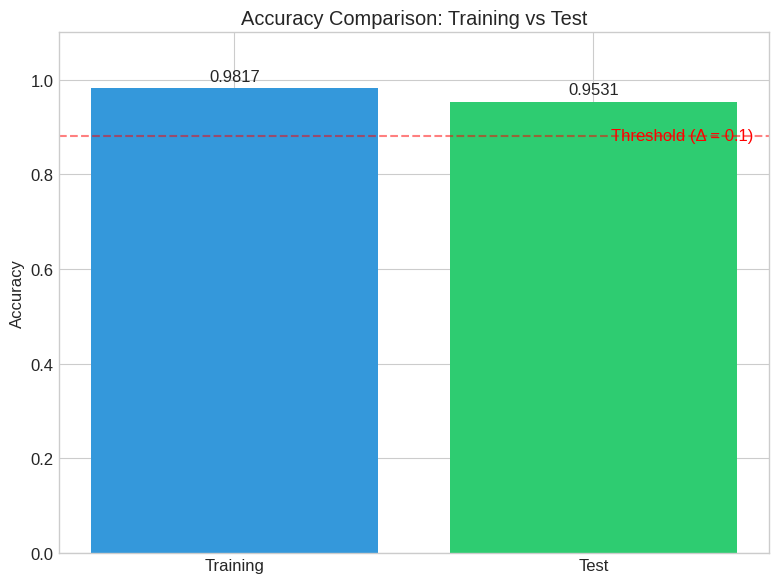


2. LEARNING CURVES ANALYSIS
Average gap between training and validation: 0.1729
Latest gap (at maximum training data): 0.0474
Sum of gaps across all training sizes: 1.7291
Are curves converging? Yes
Are curves stable? Yes
✅ No significant overfitting detected based on learning curves (latest gap ≤ 0.1)


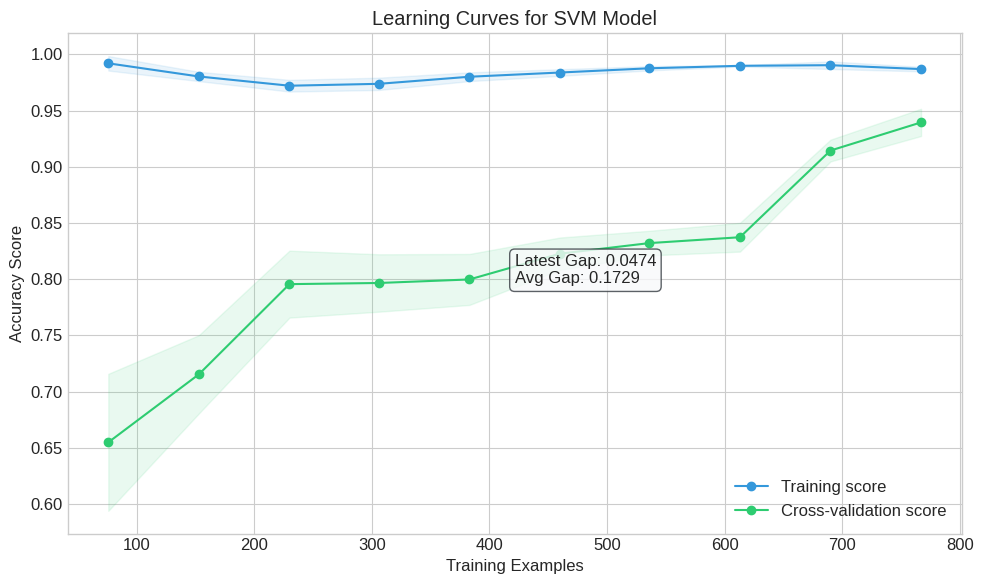


3. ROC ANALYSIS AND AUC COMPARISON
Training Set Macro-AUC: 0.9998
Test Set Macro-AUC: 0.9956
AUC Gap (Δ): 0.0042
✅ No significant overfitting detected based on AUC gap (ΔAUC ≤ 0.05)


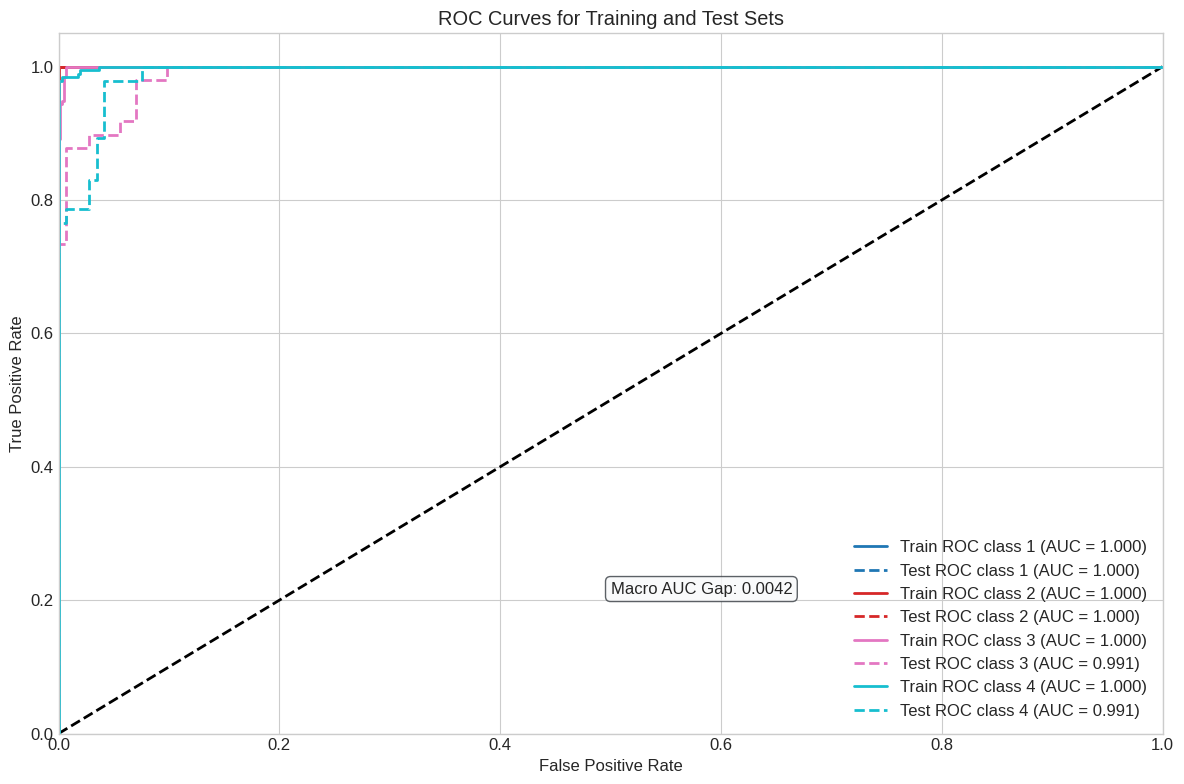

<Figure size 1000x600 with 0 Axes>

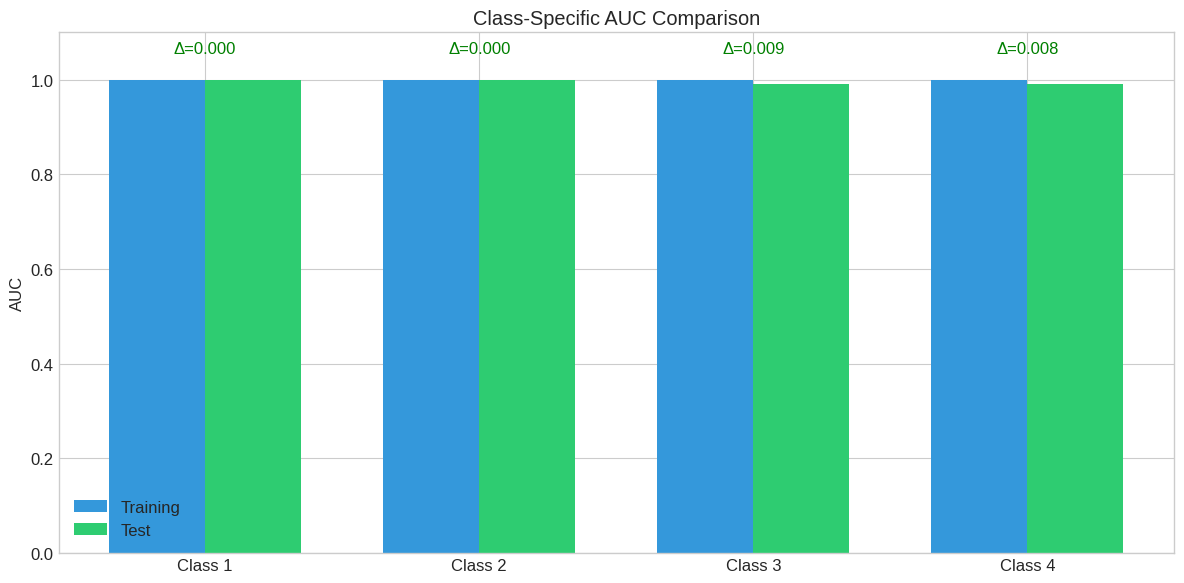


4. CLASS-SPECIFIC METRICS ANALYSIS

Class-specific metrics differences (Training - Test):
Class	Precision Δ	Recall Δ	F1 Δ
1	0.0000		0.0000		0.0000
2	0.0000		0.0000		0.0000
3	0.0183		0.0963		0.0617
4	0.0831		0.0160		0.0530

✅ No significant class-specific overfitting detected


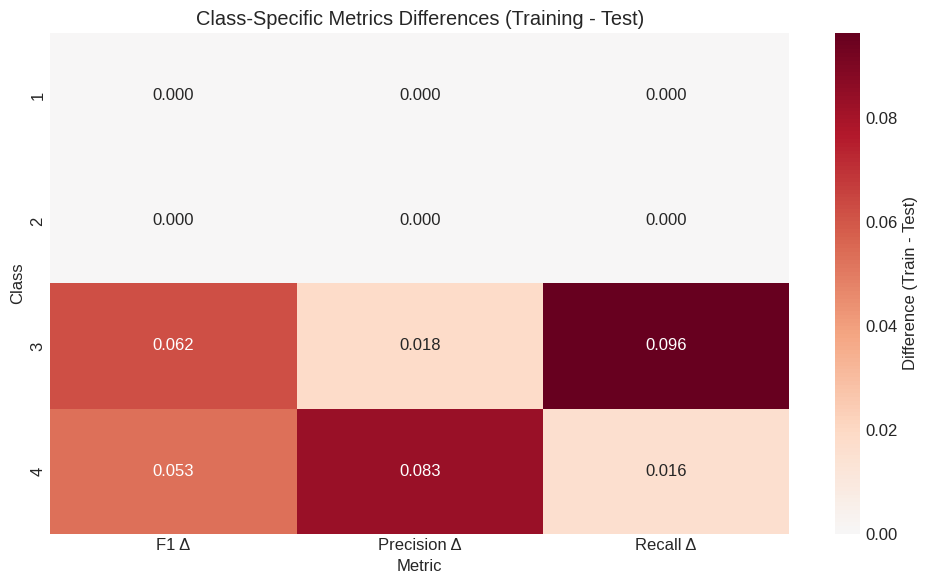


5. PREDICTION CONFIDENCE ANALYSIS
Proportion of high confidence (>0.8) predictions:
Training set: 0.9739
Test set: 0.8906
Difference: 0.0833
✅ No significant overfitting detected based on prediction confidence


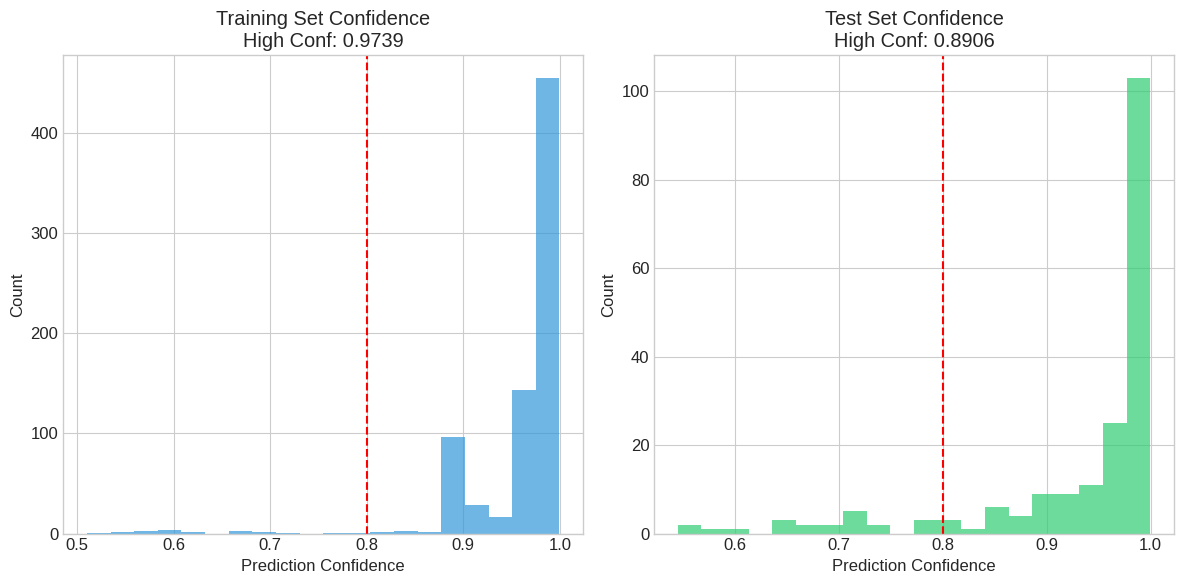

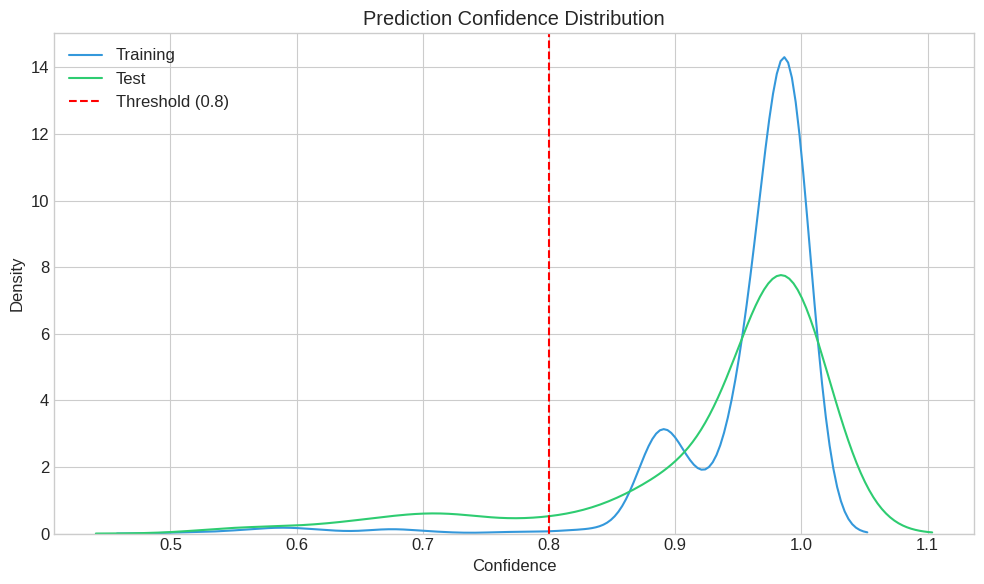


6. REGULARIZATION PARAMETER ANALYSIS
Current C parameter value: 10


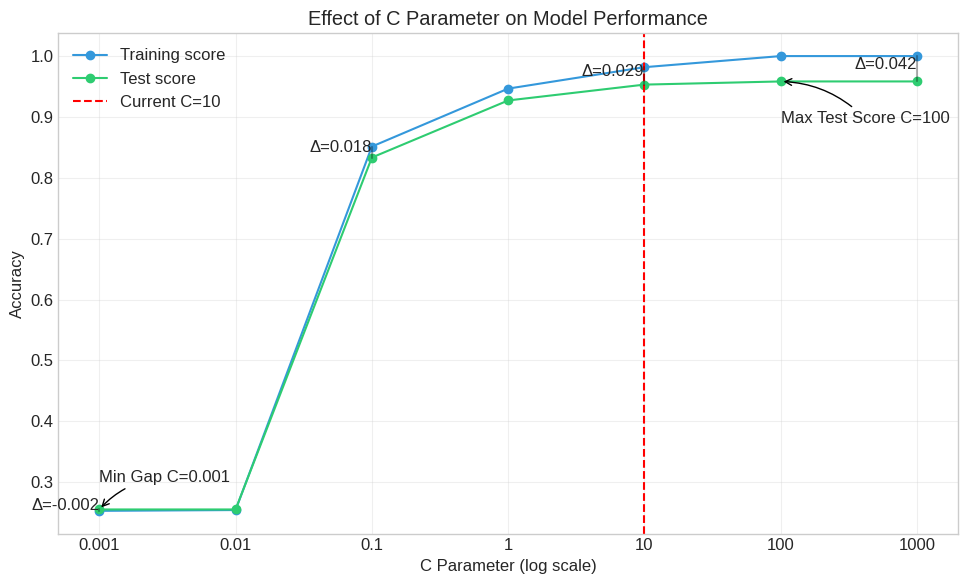


C parameter recommendations:
- Minimum overfitting gap at C=0.001
- Maximum test score at C=100
⚠️ Consider changing C from 10 to either:
   - 0.001 for minimum overfitting
   - 100 for maximum test performance

7. CROSS-VALIDATION STABILITY ASSESSMENT
Cross-validation scores: [0.9375     0.94791667 0.94791667 0.91666667 0.94764398]
Mean: 0.9395
Standard deviation: 0.0121
Range: 0.0312
✅ Model is stable across cross-validation folds (std ≤ 0.05)


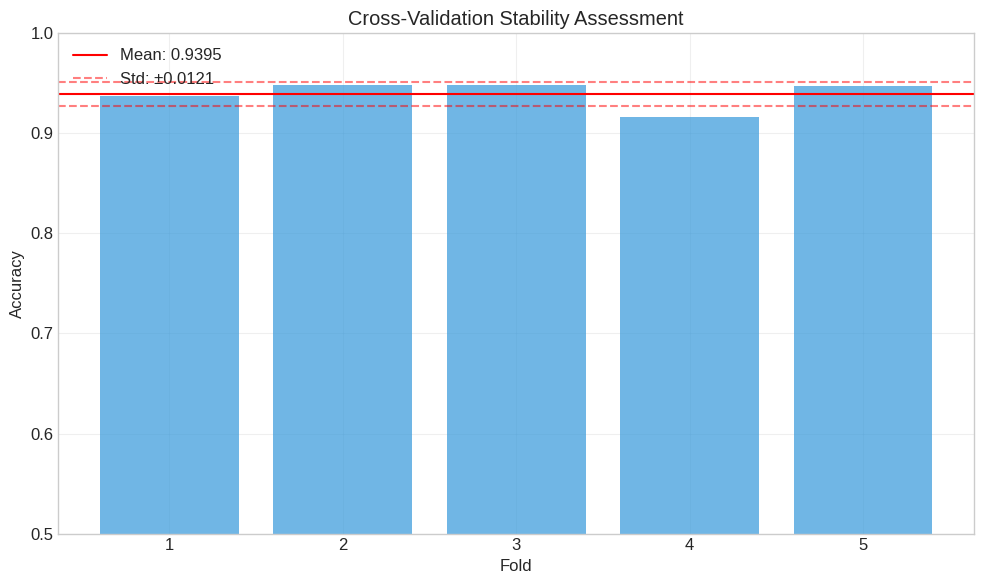


OVERFITTING ANALYSIS SUMMARY

Overfitting Indicators:
------------------------------------------------------------
Indicator                 Value      Status    
------------------------------------------------------------
Accuracy Gap              0.0286     ✅ OK
Learning Curve Gap        0.0474     ✅ OK
AUC Gap                   0.0042     ✅ OK
Confidence Gap            0.0833     ✅ OK
Cross-validation Stability 0.0121     ✅ OK
------------------------------------------------------------

🎉 OVERALL ASSESSMENT: No significant overfitting detected
The model generalizes well to unseen data.

RECOMMENDATIONS:
1. The model appears to be well-tuned.
2. You may want to explore if a simpler model could achieve similar performance.
3. Continue monitoring for overfitting when the model is deployed and used on new data.


In [17]:
# Overfitting Detection for SVM Employee Model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import learning_curve, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    accuracy_score, roc_curve, auc, precision_recall_fscore_support,
    roc_auc_score, classification_report, confusion_matrix
)
from sklearn.preprocessing import label_binarize
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pickle
from google.colab import files
import io
import warnings
warnings.filterwarnings('ignore')

# Upload the dataset and model in Google Colab
print("Upload your CSV dataset first:")
uploaded_data = files.upload()  # Upload the dataset
file_name = list(uploaded_data.keys())[0]

print("\nNow upload your saved SVM model:")
uploaded_model = files.upload()  # Upload the model
model_name = list(uploaded_model.keys())[0]

# Load the dataset
df = pd.read_csv(io.BytesIO(uploaded_data[file_name]))

# Convert string True/False to boolean for relevant columns
string_bool_columns = [col for col in df.columns if df[col].dtype == 'object' and
                       set(df[col].unique()).issubset({"True", "False"})]
for col in string_bool_columns:
    df[col] = df[col].map({"True": True, "False": False})

# Define features and target variable
X = df.drop('PerformanceScore_Encoded', axis=1)
y = df['PerformanceScore_Encoded']

# Load the trained model
with open(model_name, 'rb') as file:
    best_model = pickle.load(file)

print("\nModel loaded successfully!")

# Get the original data split that was used for training
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# ========================= 1. Comparing Metrics on Training and Test Sets =========================
def check_accuracy_gap():
    # Get predictions on training and test sets
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)

    # Calculate accuracies
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    accuracy_gap = train_accuracy - test_accuracy

    print("\n1. ACCURACY GAP ANALYSIS")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Accuracy Gap (Δ): {accuracy_gap:.4f}")

    if accuracy_gap > 0.1:
        print("⚠️ Potential overfitting detected! (Δ > 0.1)")
    else:
        print("✅ No significant overfitting detected based on accuracy gap (Δ ≤ 0.1)")

    # Visualization of accuracy comparison
    plt.figure(figsize=(8, 6))
    bars = plt.bar(['Training', 'Test'], [train_accuracy, test_accuracy], color=['#3498db', '#2ecc71'])
    plt.ylim(0, 1.1)
    plt.ylabel('Accuracy')
    plt.title('Accuracy Comparison: Training vs Test')

    # Add text labels above bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}', ha='center', va='bottom')

    # Add a horizontal line for the threshold
    plt.axhline(y=train_accuracy - 0.1, color='r', linestyle='--', alpha=0.5)
    plt.text(1.05, train_accuracy - 0.1, 'Threshold (Δ = 0.1)', color='r', va='center')

    plt.tight_layout()
    plt.show()

    return train_accuracy, test_accuracy, accuracy_gap

# ========================= 2. Learning Curves Analysis =========================
def plot_learning_curves():
    print("\n2. LEARNING CURVES ANALYSIS")

    # Get the pipeline steps from the model
    preprocessor = best_model.named_steps['preprocessor']
    classifier = best_model.named_steps['classifier']

    # Create a new pipeline for learning curve evaluation
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])

    # Calculate learning curves
    train_sizes = np.linspace(0.1, 1.0, 10)
    train_sizes, train_scores, val_scores = learning_curve(
        pipeline, X, y, train_sizes=train_sizes,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring='accuracy', random_state=42, n_jobs=-1
    )

    # Calculate mean and standard deviation for training set scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    # Calculate mean and standard deviation for validation set scores
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    # Calculate the gap between training and validation curves
    gap = train_mean - val_mean

    # NaN တန်ဖိုးများကို စစ်ဆေးရန်
    nan_mask = np.isnan(gap)
    if np.any(nan_mask):
        print(f"Warning: {np.sum(nan_mask)} NaN values detected in gap calculation")
        print("Only using non-NaN values for analysis")

        # NaN မဟုတ်သော စောင့်ကြည့်ထိန်းချုပ်မှုနောက်ဆုံးတန်ဖိုးကို ရှာပါ
        non_nan_indices = np.where(~np.isnan(gap))[0]
        if len(non_nan_indices) == 0:
            print("Error: All gap values are NaN. Unable to calculate metrics.")
            return 0, False, False

        # NaN မဟုတ်သော နောက်ဆုံးတန်ဖိုးကို အသုံးပြုပါ
        latest_valid_idx = np.max(non_nan_indices)
        latest_gap = gap[latest_valid_idx]

        # NaN မဟုတ်သော တန်ဖိုးများအတွက်သာ ပျမ်းမျှတွက်ချက်ပါ
        avg_gap = np.nanmean(gap)
        sum_gap = np.nansum(gap)

        # Converging ကိုလည်း NaN မဟုတ်သော တန်ဖိုးများအတွက်သာ တွက်ချက်ပါ
        if len(non_nan_indices) > 1:
            first_valid_idx = np.min(non_nan_indices)
            converging = gap[latest_valid_idx] < gap[first_valid_idx]
        else:
            converging = False
    else:
        # NaN တန်ဖိုးများ မရှိပါက ပုံမှန်အတိုင်း တွက်ချက်ပါ
        latest_gap = gap[-1]
        avg_gap = np.mean(gap)
        sum_gap = np.sum(gap)
        converging = gap[-1] < gap[0]

    # Determine if curves are stable (low standard deviation in later points)
    # NaN တန်ဖိုးများ၏ သက်ရောက်မှုကို ရှောင်ရှားရန် np.nanmean ကို အသုံးပြုပါ
    late_std_train = np.nanmean(train_std[-3:])
    late_std_val = np.nanmean(val_std[-3:])
    stable = late_std_train < 0.03 and late_std_val < 0.03

    # ရလဒ်များ ထုတ်ပြပါ
    print(f"Average gap between training and validation: {avg_gap:.4f}")
    print(f"Latest gap (at maximum training data): {latest_gap:.4f}")
    print(f"Sum of gaps across all training sizes: {sum_gap:.4f}")
    print(f"Are curves converging? {'Yes' if converging else 'No'}")
    print(f"Are curves stable? {'Yes' if stable else 'No'}")

    # နောက်ဆုံး gap ကို အသုံးပြု၍ ဆုံးဖြတ်ချက်ချပါ
    if latest_gap > 0.1:
        print("⚠️ Potential overfitting detected! (latest gap > 0.1)")
    else:
        print("✅ No significant overfitting detected based on learning curves (latest gap ≤ 0.1)")

    # Plot learning curves - NaN တန်ဖိုးများကို ဂရပ်တွင် ရှောင်ရှားရန်
    plt.figure(figsize=(10, 6))

    # NaN မဟုတ်သော တန်ဖိုးများကိုသာ ပလော့တင်ပါ
    valid_indices = ~np.isnan(train_mean) & ~np.isnan(val_mean)
    valid_train_sizes = train_sizes[valid_indices]
    valid_train_mean = train_mean[valid_indices]
    valid_train_std = train_std[valid_indices]
    valid_val_mean = val_mean[valid_indices]
    valid_val_std = val_std[valid_indices]

    plt.plot(valid_train_sizes, valid_train_mean, 'o-', color='#3498db', label='Training score')
    plt.fill_between(valid_train_sizes, valid_train_mean - valid_train_std,
                    valid_train_mean + valid_train_std, alpha=0.1, color='#3498db')

    plt.plot(valid_train_sizes, valid_val_mean, 'o-', color='#2ecc71', label='Cross-validation score')
    plt.fill_between(valid_train_sizes, valid_val_mean - valid_val_std,
                    valid_val_mean + valid_val_std, alpha=0.1, color='#2ecc71')

    plt.title('Learning Curves for SVM Model')
    plt.xlabel('Training Examples')
    plt.ylabel('Accuracy Score')
    plt.grid(True)
    plt.legend(loc='best')

    # ဗဟိုကွာဟချက်စာသားကိုသာ ဖော်ပြပါ - အနီရောင်မြားကို ဖယ်ရှားထားပါသည်
    plt.annotate(
        f'Latest Gap: {latest_gap:.4f}\nAvg Gap: {avg_gap:.4f}',
        xy=(0.5, 0.5), xycoords='axes fraction',
        bbox=dict(boxstyle="round,pad=0.3", fc="#f8f9fa", ec="#343a40", alpha=0.8)
    )

    # အနီရောင်မြားဖော်ပြချက်ကို ဖယ်ရှားပါ - အောက်ပါကုဒ်များကို ဖယ်ရှားထားပါသည်
    # last_idx = len(valid_train_sizes) - 1
    # last_train_size = valid_train_sizes[last_idx]
    # last_train_score = valid_train_mean[last_idx]
    # last_val_score = valid_val_mean[last_idx]
    # plt.plot([last_train_size, last_train_size], [last_val_score, last_train_score],
    #         'r--', linewidth=2)
    # plt.annotate(
    #     f'Latest Gap: {latest_gap:.4f}',
    #     xy=(last_train_size, (last_val_score + last_train_score)/2),
    #     xytext=(last_train_size-0.15, (last_val_score + last_train_score)/2),
    #     arrowprops=dict(arrowstyle="->", color='red'),
    #     color='red'
    # )

    plt.tight_layout()
    plt.show()

    # နောက်ဆုံး gap ကို ပြန်ပေးပါ
    return latest_gap, converging, stable


# ========================= 3. ROC Analysis and AUC Comparison =========================
def perform_roc_analysis():
    print("\n3. ROC ANALYSIS AND AUC COMPARISON")

    # Get the number of classes
    n_classes = len(np.unique(y))

    # Binarize the output for multi-class ROC analysis
    y_train_bin = label_binarize(y_train, classes=sorted(np.unique(y)))
    y_test_bin = label_binarize(y_test, classes=sorted(np.unique(y)))

    # Get probability predictions
    y_train_score = best_model.predict_proba(X_train)
    y_test_score = best_model.predict_proba(X_test)

    # Calculate ROC curve and AUC for each class
    fpr_train = dict()
    tpr_train = dict()
    roc_auc_train = dict()

    fpr_test = dict()
    tpr_test = dict()
    roc_auc_test = dict()

    for i in range(n_classes):
        fpr_train[i], tpr_train[i], _ = roc_curve(y_train_bin[:, i], y_train_score[:, i])
        roc_auc_train[i] = auc(fpr_train[i], tpr_train[i])

        fpr_test[i], tpr_test[i], _ = roc_curve(y_test_bin[:, i], y_test_score[:, i])
        roc_auc_test[i] = auc(fpr_test[i], tpr_test[i])

    # Calculate macro-average AUC
    macro_auc_train = np.mean([roc_auc_train[i] for i in range(n_classes)])
    macro_auc_test = np.mean([roc_auc_test[i] for i in range(n_classes)])
    auc_gap = macro_auc_train - macro_auc_test

    print(f"Training Set Macro-AUC: {macro_auc_train:.4f}")
    print(f"Test Set Macro-AUC: {macro_auc_test:.4f}")
    print(f"AUC Gap (Δ): {auc_gap:.4f}")

    if auc_gap > 0.05:
        print("⚠️ Potential overfitting detected! (ΔAUC > 0.05)")
    else:
        print("✅ No significant overfitting detected based on AUC gap (ΔAUC ≤ 0.05)")

    # Plot ROC curves
    plt.figure(figsize=(12, 8))

    # Plot macro-average ROC curve for training
    plt.plot([0, 1], [0, 1], 'k--', lw=2)

    # Plot class-specific ROC curves
    colors = plt.cm.tab10(np.linspace(0, 1, n_classes))

    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr_train[i], tpr_train[i], color=color, lw=2, linestyle='-',
                 label=f'Train ROC class {i+1} (AUC = {roc_auc_train[i]:.3f})')

        plt.plot(fpr_test[i], tpr_test[i], color=color, lw=2, linestyle='--',
                 label=f'Test ROC class {i+1} (AUC = {roc_auc_test[i]:.3f})')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Training and Test Sets')
    plt.legend(loc="lower right")

    # Add annotation for the gap
    plt.annotate(f'Macro AUC Gap: {auc_gap:.4f}',
                xy=(0.5, 0.2), xycoords='axes fraction',
                bbox=dict(boxstyle="round,pad=0.3", fc="#f8f9fa", ec="#343a40", alpha=0.8))

    plt.tight_layout()
    plt.show()

    # Bar chart comparing class-specific AUCs
    plt.figure(figsize=(10, 6))

    class_labels = [f'Class {i+1}' for i in range(n_classes)]
    x = np.arange(len(class_labels))
    width = 0.35

    train_aucs = [roc_auc_train[i] for i in range(n_classes)]
    test_aucs = [roc_auc_test[i] for i in range(n_classes)]

    fig, ax = plt.subplots(figsize=(12, 6))
    bars1 = ax.bar(x - width/2, train_aucs, width, label='Training', color='#3498db')
    bars2 = ax.bar(x + width/2, test_aucs, width, label='Test', color='#2ecc71')

    ax.set_ylim(0, 1.1)
    ax.set_ylabel('AUC')
    ax.set_title('Class-Specific AUC Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(class_labels)
    ax.legend()

    # Add AUC gap annotations
    for i in range(n_classes):
        gap = train_aucs[i] - test_aucs[i]
        ax.annotate(f'Δ={gap:.3f}',
                   xy=(i, max(train_aucs[i], test_aucs[i]) + 0.05),
                   ha='center', va='bottom',
                   color='red' if gap > 0.05 else 'green')

    plt.tight_layout()
    plt.show()

    return macro_auc_train, macro_auc_test, auc_gap

# ========================= 4. Class-Specific Metrics Analysis =========================
def analyze_class_metrics():
    print("\n4. CLASS-SPECIFIC METRICS ANALYSIS")

    # Get predictions
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)

    # Calculate metrics for training set
    precision_train, recall_train, f1_train, _ = precision_recall_fscore_support(y_train, y_train_pred, average=None)

    # Calculate metrics for test set
    precision_test, recall_test, f1_test, _ = precision_recall_fscore_support(y_test, y_test_pred, average=None)

    # Calculate differences
    precision_diff = precision_train - precision_test
    recall_diff = recall_train - recall_test
    f1_diff = f1_train - f1_test

    # Check for overfitting in each class
    classes = sorted(np.unique(y))

    # Print class-specific metrics
    print("\nClass-specific metrics differences (Training - Test):")
    print("Class\tPrecision Δ\tRecall Δ\tF1 Δ")

    for i, class_label in enumerate(classes):
        print(f"{class_label}\t{precision_diff[i]:.4f}\t\t{recall_diff[i]:.4f}\t\t{f1_diff[i]:.4f}")

    # Identify classes with significant overfitting
    overfit_classes = []

    for i, class_label in enumerate(classes):
        if abs(precision_diff[i]) > 0.1 or abs(recall_diff[i]) > 0.1 or abs(f1_diff[i]) > 0.1:
            overfit_classes.append(class_label)

    if overfit_classes:
        print(f"\n⚠️ Potential class-specific overfitting detected in classes: {overfit_classes}")
    else:
        print("\n✅ No significant class-specific overfitting detected")

    # Create a heatmap of metric differences
    metrics_diff = pd.DataFrame({
        'Class': classes,
        'Precision Δ': precision_diff,
        'Recall Δ': recall_diff,
        'F1 Δ': f1_diff
    })

    metrics_diff_pivot = metrics_diff.melt(id_vars=['Class'], var_name='Metric', value_name='Difference')
    pivot_table = metrics_diff_pivot.pivot(index='Class', columns='Metric', values='Difference')

    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot_table, annot=True, cmap='RdBu_r', center=0, fmt='.3f', cbar_kws={'label': 'Difference (Train - Test)'})
    plt.title('Class-Specific Metrics Differences (Training - Test)')
    plt.tight_layout()
    plt.show()

    return metrics_diff

# ========================= 5. Prediction Confidence Analysis =========================
def analyze_prediction_confidence():
    print("\n5. PREDICTION CONFIDENCE ANALYSIS")

    # Get probability predictions
    y_train_proba = best_model.predict_proba(X_train)
    y_test_proba = best_model.predict_proba(X_test)

    # Get the max probability for each prediction (confidence)
    train_confidence = np.max(y_train_proba, axis=1)
    test_confidence = np.max(y_test_proba, axis=1)

    # Calculate high confidence proportions
    high_conf_threshold = 0.8
    train_high_conf = np.mean(train_confidence >= high_conf_threshold)
    test_high_conf = np.mean(test_confidence >= high_conf_threshold)

    print(f"Proportion of high confidence (>{high_conf_threshold}) predictions:")
    print(f"Training set: {train_high_conf:.4f}")
    print(f"Test set: {test_high_conf:.4f}")
    print(f"Difference: {train_high_conf - test_high_conf:.4f}")

    # Decide if there's a confidence gap indicating overfitting
    conf_gap = train_high_conf - test_high_conf

    if conf_gap > 0.1:
        print("⚠️ Potential overfitting detected! (confidence gap > 0.1)")
    else:
        print("✅ No significant overfitting detected based on prediction confidence")

    # Plot confidence histograms
    plt.figure(figsize=(12, 6))

    # Training set confidence histogram
    plt.subplot(1, 2, 1)
    plt.hist(train_confidence, bins=20, alpha=0.7, color='#3498db')
    plt.axvline(x=high_conf_threshold, color='r', linestyle='--')
    plt.title(f'Training Set Confidence\nHigh Conf: {train_high_conf:.4f}')
    plt.xlabel('Prediction Confidence')
    plt.ylabel('Count')

    # Test set confidence histogram
    plt.subplot(1, 2, 2)
    plt.hist(test_confidence, bins=20, alpha=0.7, color='#2ecc71')
    plt.axvline(x=high_conf_threshold, color='r', linestyle='--')
    plt.title(f'Test Set Confidence\nHigh Conf: {test_high_conf:.4f}')
    plt.xlabel('Prediction Confidence')
    plt.ylabel('Count')

    plt.tight_layout()
    plt.show()

    # Compare overall confidence distributions
    plt.figure(figsize=(10, 6))
    sns.kdeplot(train_confidence, label='Training', color='#3498db')
    sns.kdeplot(test_confidence, label='Test', color='#2ecc71')
    plt.axvline(x=high_conf_threshold, color='r', linestyle='--', label=f'Threshold ({high_conf_threshold})')
    plt.title('Prediction Confidence Distribution')
    plt.xlabel('Confidence')
    plt.ylabel('Density')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return train_high_conf, test_high_conf, conf_gap

# ========================= 6. Regularization Parameter Analysis =========================
def analyze_regularization_parameter():
    print("\n6. REGULARIZATION PARAMETER ANALYSIS")

    # Identify the classifier and preprocessor from the pipeline
    preprocessor = best_model.named_steps['preprocessor']
    best_C = best_model.named_steps['classifier'].C

    print(f"Current C parameter value: {best_C}")

    # Define a range of C values to test
    C_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

    # Scores containers
    train_scores = []
    test_scores = []

    for C in C_values:
        # Create a new SVM with the current C value
        svm = SVC(C=C, probability=True, random_state=42, kernel=best_model.named_steps['classifier'].kernel)

        # Create a pipeline with the same preprocessor
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', svm)
        ])

        # Fit the model
        pipeline.fit(X_train, y_train)

        # Get scores
        train_score = pipeline.score(X_train, y_train)
        test_score = pipeline.score(X_test, y_test)

        train_scores.append(train_score)
        test_scores.append(test_score)

    # Convert C values to strings for plotting
    C_values_str = [str(C) for C in C_values]

    # Find the index of the best C value in our list
    best_C_idx = C_values.index(best_C) if best_C in C_values else -1

    # Plot the regularization parameter curve
    plt.figure(figsize=(10, 6))
    plt.plot(C_values_str, train_scores, 'o-', color='#3498db', label='Training score')
    plt.plot(C_values_str, test_scores, 'o-', color='#2ecc71', label='Test score')

    # Mark the current C value
    if best_C_idx != -1:
        plt.axvline(x=best_C_idx, color='r', linestyle='--', label=f'Current C={best_C}')

    # Calculate the gaps
    gaps = np.array(train_scores) - np.array(test_scores)

    # Find the C with minimum gap
    min_gap_idx = np.argmin(gaps)
    min_gap_C = C_values[min_gap_idx]

    # Find the C with maximum test score
    max_test_idx = np.argmax(test_scores)
    max_test_C = C_values[max_test_idx]

    plt.title('Effect of C Parameter on Model Performance')
    plt.xlabel('C Parameter (log scale)')
    plt.ylabel('Accuracy')
    plt.grid(True, alpha=0.3)
    plt.legend(loc='best')

    # Add annotations
    plt.annotate(f'Min Gap C={min_gap_C}',
                xy=(C_values_str[min_gap_idx], test_scores[min_gap_idx]),
                xytext=(0, 20), textcoords='offset points',
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))

    plt.annotate(f'Max Test Score C={max_test_C}',
                xy=(C_values_str[max_test_idx], test_scores[max_test_idx]),
                xytext=(0, -30), textcoords='offset points',
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))

    # Add horizontal lines for each gap
    for i, (C, gap) in enumerate(zip(C_values_str, gaps)):
        if i % 2 == 0:  # Add for every other C value to avoid clutter
            plt.plot([i, i], [test_scores[i], train_scores[i]], 'k-', alpha=0.3)
            plt.text(i, (test_scores[i] + train_scores[i])/2, f'Δ={gap:.3f}', ha='right')

    plt.tight_layout()
    plt.show()

    # Recommendations
    print(f"\nC parameter recommendations:")
    print(f"- Minimum overfitting gap at C={min_gap_C}")
    print(f"- Maximum test score at C={max_test_C}")

    if best_C != min_gap_C and best_C != max_test_C:
        if min_gap_C == max_test_C:
            print(f"⚠️ Consider changing C from {best_C} to {min_gap_C} for better generalization and performance")
        else:
            print(f"⚠️ Consider changing C from {best_C} to either:")
            print(f"   - {min_gap_C} for minimum overfitting")
            print(f"   - {max_test_C} for maximum test performance")
    else:
        print("✅ Current C parameter is optimal")

    return train_scores, test_scores, C_values, best_C, min_gap_C, max_test_C

# ========================= 7. Cross-Validation Stability Assessment =========================
def assess_cv_stability():
    print("\n7. CROSS-VALIDATION STABILITY ASSESSMENT")

    # Define cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Get the classifier and preprocessor from the pipeline
    classifier = best_model.named_steps['classifier']
    preprocessor = best_model.named_steps['preprocessor']

    # Create a new pipeline for cross-validation
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])

    # Perform cross-validation
    cv_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy')

    # Calculate stability metrics
    cv_mean = np.mean(cv_scores)
    cv_std = np.std(cv_scores)
    cv_range = np.max(cv_scores) - np.min(cv_scores)

    print(f"Cross-validation scores: {cv_scores}")
    print(f"Mean: {cv_mean:.4f}")
    print(f"Standard deviation: {cv_std:.4f}")
    print(f"Range: {cv_range:.4f}")

    # Evaluate stability
    if cv_std > 0.05:
        print("⚠️ High variance across folds detected (std > 0.05)")
    else:
        print("✅ Model is stable across cross-validation folds (std ≤ 0.05)")

    # Visualize the cross-validation results
    plt.figure(figsize=(10, 6))

    # Plot each fold score
    plt.bar(range(1, len(cv_scores) + 1), cv_scores, color='#3498db', alpha=0.7)

    # Add mean line
    plt.axhline(y=cv_mean, color='r', linestyle='-', label=f'Mean: {cv_mean:.4f}')

    # Add std bounds
    plt.axhline(y=cv_mean + cv_std, color='r', linestyle='--', alpha=0.5,
                label=f'Std: ±{cv_std:.4f}')
    plt.axhline(y=cv_mean - cv_std, color='r', linestyle='--', alpha=0.5)

    plt.title('Cross-Validation Stability Assessment')
    plt.xlabel('Fold')
    plt.ylabel('Accuracy')
    plt.xticks(range(1, len(cv_scores) + 1))
    plt.ylim(0.5, 1.0)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return cv_mean, cv_std, cv_range

# ========================= MAIN EXECUTION FUNCTION =========================
def check_overfitting():
    """Perform comprehensive overfitting analysis on the model"""
    print("=" * 80)
    print("COMPREHENSIVE OVERFITTING ANALYSIS")
    print("=" * 80)

    # Run all analyses
    train_acc, test_acc, acc_gap = check_accuracy_gap()
    avg_gap, converging, stable = plot_learning_curves()
    macro_auc_train, macro_auc_test, auc_gap = perform_roc_analysis()
    metrics_diff = analyze_class_metrics()
    train_high_conf, test_high_conf, conf_gap = analyze_prediction_confidence()
    train_scores, test_scores, C_values, best_C, min_gap_C, max_test_C = analyze_regularization_parameter()
    cv_mean, cv_std, cv_range = assess_cv_stability()

    # Generate a summary report
    print("\n" + "=" * 80)
    print("OVERFITTING ANALYSIS SUMMARY")
    print("=" * 80)

    overfitting_indicators = [
        ("Accuracy Gap", acc_gap > 0.1, acc_gap),
        ("Learning Curve Gap", avg_gap > 0.1, avg_gap),
        ("AUC Gap", auc_gap > 0.05, auc_gap),
        ("Confidence Gap", conf_gap > 0.1, conf_gap),
        ("Cross-validation Stability", cv_std > 0.05, cv_std)
    ]

    # Count how many indicators suggest overfitting
    overfitting_count = sum(1 for _, is_overfitting, _ in overfitting_indicators if is_overfitting)

    # Print summary table
    print("\nOverfitting Indicators:")
    print("-" * 60)
    print(f"{'Indicator':<25} {'Value':<10} {'Status':<10}")
    print("-" * 60)

    for indicator, is_overfitting, value in overfitting_indicators:
        status = "⚠️ ISSUE" if is_overfitting else "✅ OK"
        print(f"{indicator:<25} {value:.4f}     {status}")

    print("-" * 60)

    # Overall assessment
    if overfitting_count == 0:
        print("\n🎉 OVERALL ASSESSMENT: No significant overfitting detected")
        print("The model generalizes well to unseen data.")
    elif overfitting_count <= 2:
        print("\n⚠️ OVERALL ASSESSMENT: Mild overfitting detected")
        print("The model shows some signs of overfitting but may still be acceptable depending on the use case.")
    else:
        print("\n❌ OVERALL ASSESSMENT: Significant overfitting detected")
        print("The model is likely overfitting the training data and may not generalize well.")

    # Recommendations
    print("\nRECOMMENDATIONS:")

    if overfitting_count > 0:
        print("1. Consider adjusting the regularization parameter:")
        print(f"   - Current C: {best_C}")
        print(f"   - Recommended C for minimizing overfitting: {min_gap_C}")
        print(f"   - Recommended C for maximizing test performance: {max_test_C}")

        print("\n2. Other techniques to try:")
        print("   - Increase training data or perform data augmentation")
        print("   - Feature selection to reduce model complexity")
        print("   - Ensemble methods (e.g., bagging) to reduce variance")
        print("   - Try a simpler kernel (e.g., linear if using rbf)")
    else:
        print("1. The model appears to be well-tuned.")
        print("2. You may want to explore if a simpler model could achieve similar performance.")
        print("3. Continue monitoring for overfitting when the model is deployed and used on new data.")

# Run the full analysis
check_overfitting()

**SVM Overfitting Detection_2**

Upload your CSV dataset first:


Saving employee_data_adasyn.csv to employee_data_adasyn (2).csv

Now upload your saved SVM model:


Saving svm_employee_model.pkl to svm_employee_model (2).pkl

Model loaded successfully!
Model type: <class 'sklearn.pipeline.Pipeline'>
Pipeline steps: dict_keys(['preprocessor', 'classifier'])
SVM kernel: rbf
SVM C parameter: 10
SVM gamma parameter: scale
Training set size: 767 samples, 15 features
Test set size: 192 samples, 15 features

Class distribution:
Training set:
  Class 3: 25.29% (194 samples)
  Class 1: 25.16% (193 samples)
  Class 2: 25.03% (192 samples)
  Class 4: 24.51% (188 samples)
Test set:
  Class 3: 25.52% (49 samples)
  Class 2: 25.00% (48 samples)
  Class 1: 25.00% (48 samples)
  Class 4: 24.48% (47 samples)
COMPREHENSIVE OVERFITTING ANALYSIS

1. ACCURACY GAP ANALYSIS
Training Accuracy: 0.9817
Test Accuracy: 0.9531
Accuracy Gap (Δ): 0.0286

Detailed Per-Class Accuracy Analysis:
Class      Train Acc  Test Acc   Gap        Status    
--------------------------------------------------
1          1.0000     1.0000     0.0000     ✅ OK
2          1.0000     1.0000     0

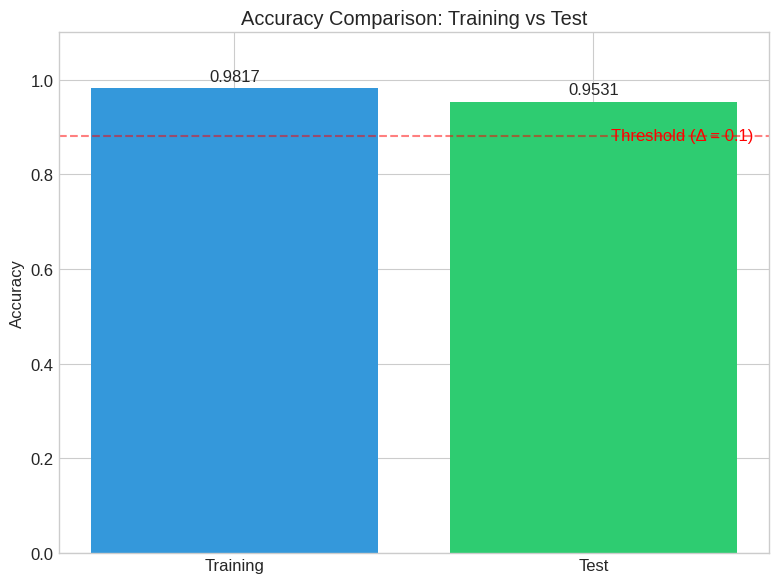


2. LEARNING CURVES ANALYSIS
Average gap between training and validation: nan
Are curves converging? No
Are curves stable? Yes

Detailed Learning Curve Data:
Training Size   Train Score     Train Std       Val Score       Val Std         Gap            
------------------------------------------------------------------------------------------
58292           nan         nan         nan         nan         nan
117351          nan         nan         nan         nan         nan
176410          0.9730         0.0141         0.7716         0.1594         0.2015
234702          0.9712         0.0148         0.7821         0.1429         0.1891
293761          0.9775         0.0117         0.7811         0.1423         0.1965
352820          0.9822         0.0092         0.8155         0.0828         0.1667
411112          0.9877         0.0066         0.8259         0.0619         0.1618
470171          0.9892         0.0053         0.8478         0.0413         0.1415
529230          0.990

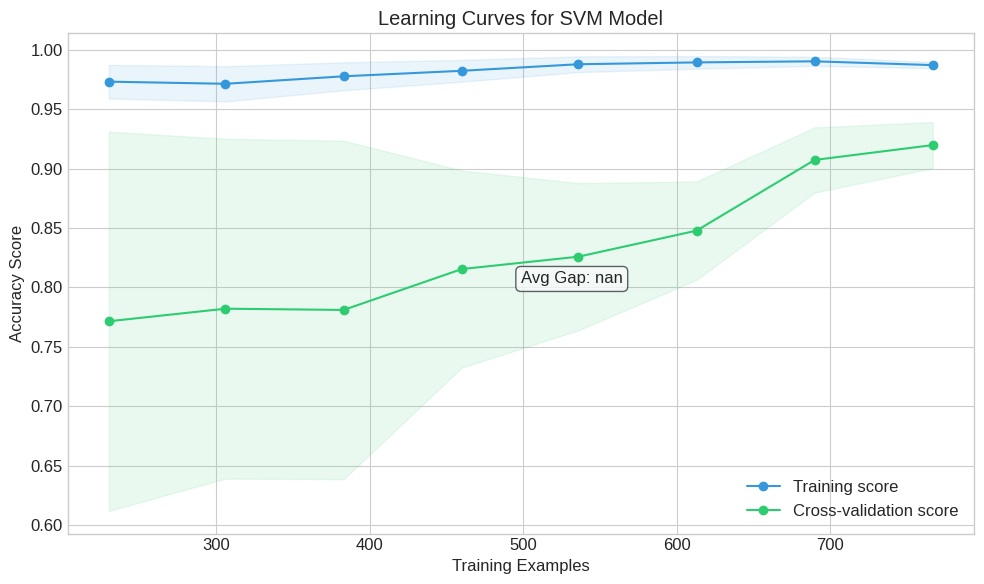


3. ROC ANALYSIS AND AUC COMPARISON
Training Set Macro-AUC: 0.9998
Test Set Macro-AUC: 0.9956
AUC Gap (Δ): 0.0042

Detailed Class-Specific ROC Analysis:
Class      Train AUC    Test AUC     AUC Gap      Train Threshold  Test Threshold   Status    
--------------------------------------------------------------------------------
0          1.0000      1.0000      0.0000      0.9777          0.9763          ✅ OK
1          1.0000      1.0000      0.0000      0.9526          0.7143          ✅ OK
2          0.9996      0.9910      0.0086      0.3082          0.1589          ✅ OK
3          0.9996      0.9913      0.0083      0.6662          0.5556          ✅ OK

Optimal Operating Points (Test Set):
Class 0: Threshold=0.9763, Sensitivity=1.0000, Specificity=1.0000
Class 1: Threshold=0.7143, Sensitivity=1.0000, Specificity=1.0000
Class 2: Threshold=0.1589, Sensitivity=0.9796, Specificity=0.9301
Class 3: Threshold=0.5556, Sensitivity=0.9787, Specificity=0.9586

✅ No significant overfitting det

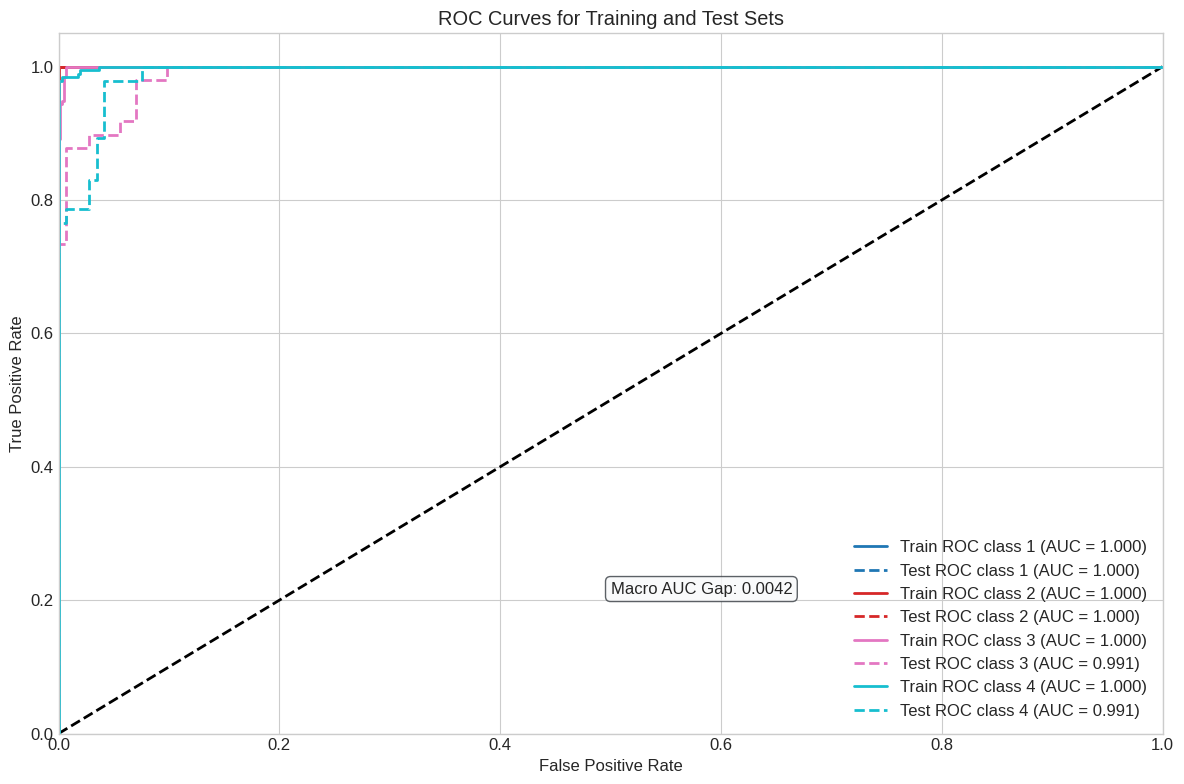

<Figure size 1000x600 with 0 Axes>

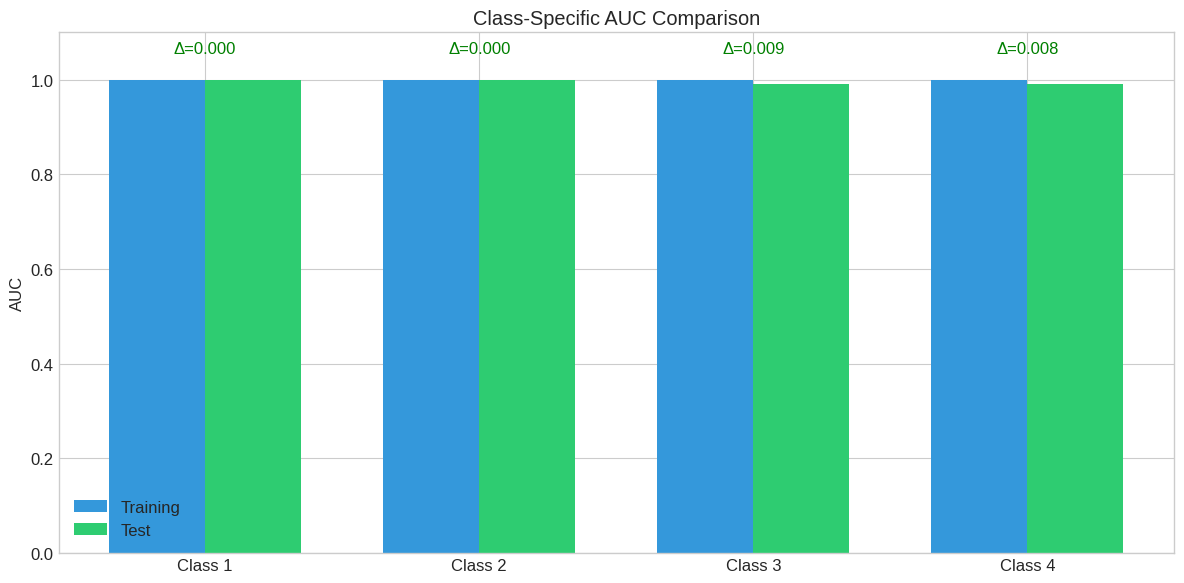


4. CLASS-SPECIFIC METRICS ANALYSIS

Detailed Class-specific Metrics:
Class      Metric     Train      Test       Diff       Status    
------------------------------------------------------------
1          Precision  1.0000    1.0000    0.0000    ✅ OK
           Recall     1.0000    1.0000    0.0000    ✅ OK
           F1-Score   1.0000    1.0000    0.0000    ✅ OK
------------------------------------------------------------
2          Precision  1.0000    1.0000    0.0000    ✅ OK
           Recall     1.0000    1.0000    0.0000    ✅ OK
           F1-Score   1.0000    1.0000    0.0000    ✅ OK
------------------------------------------------------------
3          Precision  0.9945    0.9762    0.0183    ✅ OK
           Recall     0.9330    0.8367    0.0963    ✅ OK
           F1-Score   0.9628    0.9011    0.0617    ✅ OK
------------------------------------------------------------
4          Precision  0.9350    0.8519    0.0831    ✅ OK
           Recall     0.9947    0.9787    0.0160  

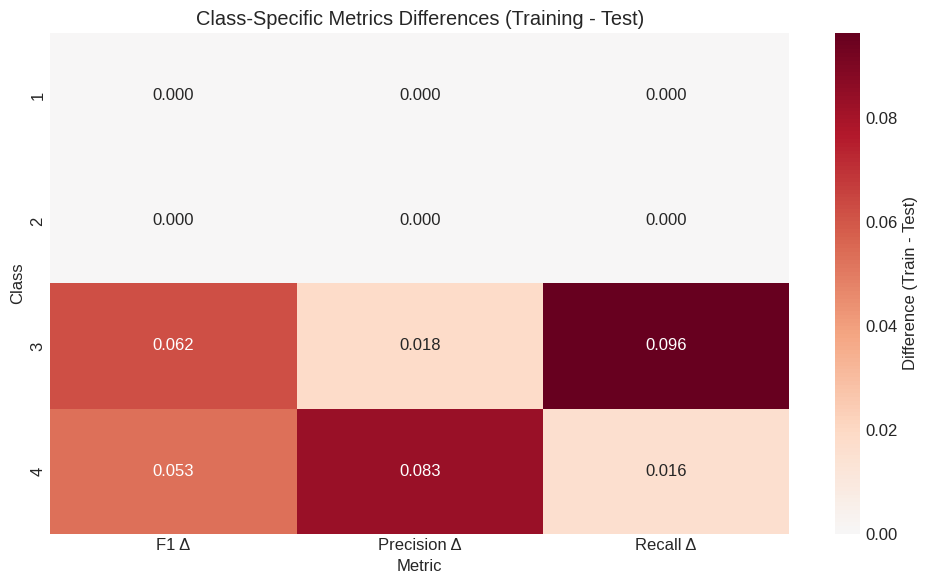


5. PREDICTION CONFIDENCE ANALYSIS

Confidence Statistics:
Statistic       Training        Test            Difference     
------------------------------------------------------------
Mean            0.9569        0.9340        0.0229
Median          0.9828        0.9822        0.0006
Min             0.5102        0.5447        -0.0345
Max             0.9996        0.9998        -0.0002
Std Dev         0.0661        0.0988        -0.0326

Confidence Distribution by Threshold:
Threshold  Training %      Test %          Difference      Status    
-----------------------------------------------------------------
≥ 0.5      100.00%         100.00%         0.00%           ✅ OK
≥ 0.6      98.96%         98.44%         0.52%           ✅ OK
≥ 0.7      97.78%         94.27%         3.51%           ✅ OK
≥ 0.8      97.39%         89.06%         8.33%           ✅ OK
≥ 0.9      83.96%         79.69%         4.28%           ✅ OK
≥ 0.95     77.97%         67.71%         10.26%           ⚠️ Issue

Cla

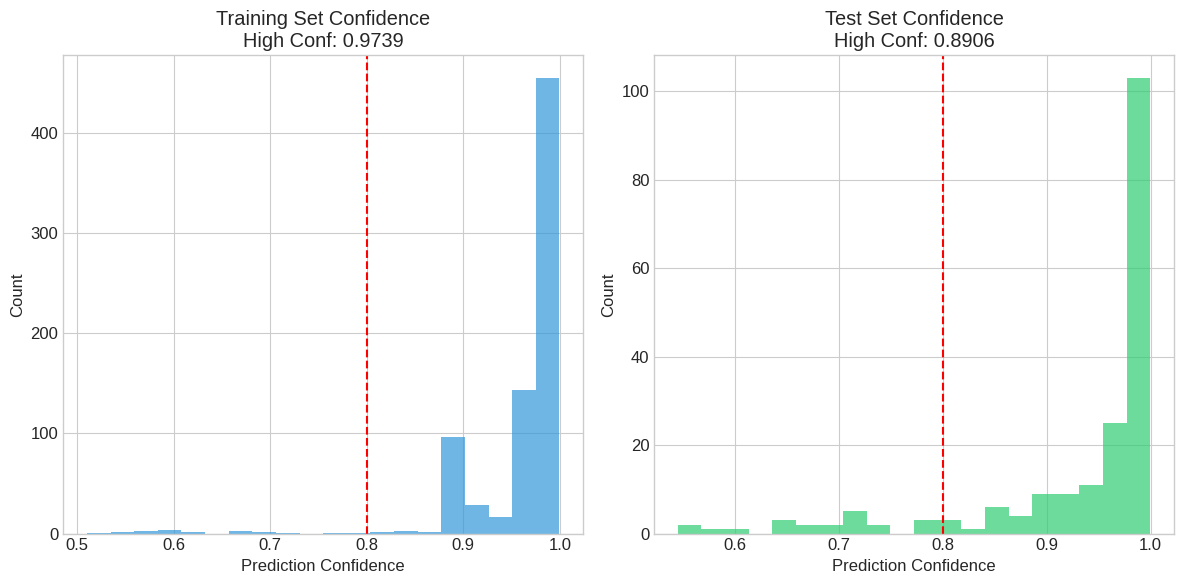

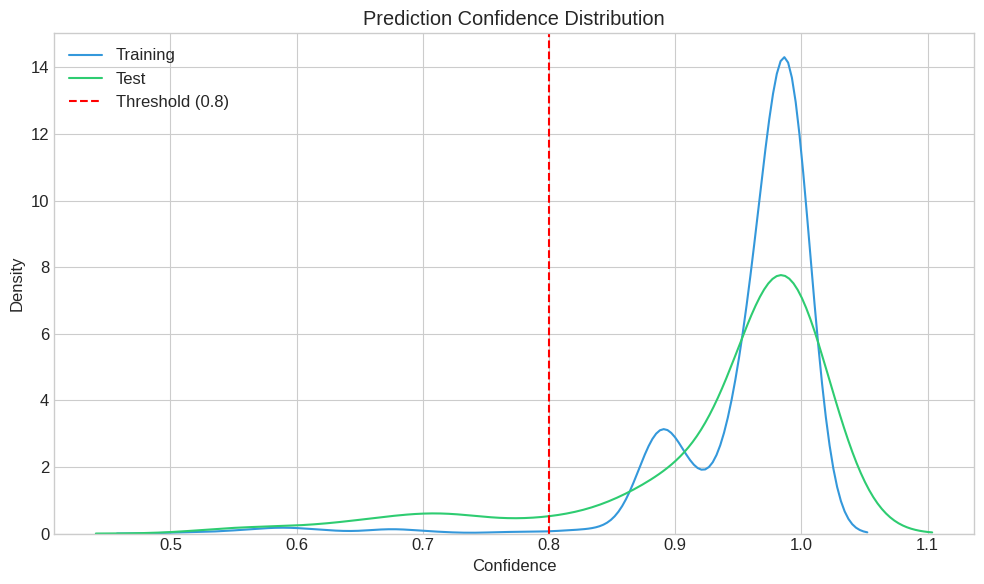

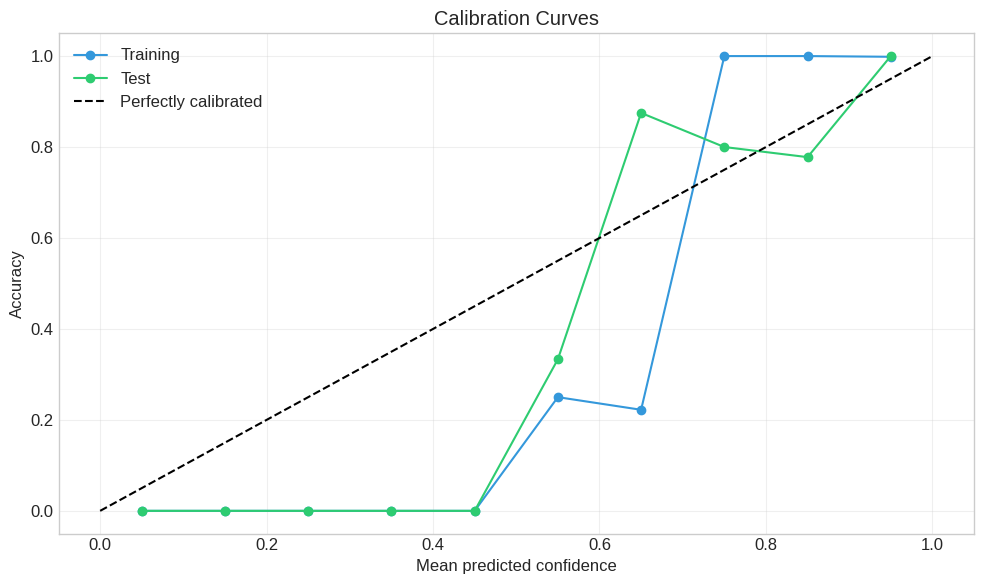


6. REGULARIZATION PARAMETER ANALYSIS
Current C parameter value: 10
Kernel type: rbf

Testing different C values...
C Value    Train Acc    Test Acc     Gap        Status    
------------------------------------------------------
0.001      0.2529       0.2552       -0.0023    ✅ OK
0.01       0.2542       0.2552       -0.0010    ✅ OK
0.1        0.8514       0.8333       0.0180    ✅ OK
1          0.9465       0.9271       0.0195    ✅ OK
10         0.9817       0.9531       0.0286    ✅ OK
100        1.0000       0.9583       0.0417    ✅ OK
1000       1.0000       0.9583       0.0417    ✅ OK

Class-specific F1 scores at key C values:

Current C=10:
Class 1: Train F1=1.0000, Test F1=1.0000, Gap=0.0000
Class 2: Train F1=1.0000, Test F1=1.0000, Gap=0.0000
Class 3: Train F1=0.9628, Test F1=0.9011, Gap=0.0617
Class 4: Train F1=0.9639, Test F1=0.9109, Gap=0.0530

Minimum gap C=0.001:
Class 1: Train F1=0.0000, Test F1=0.0000, Gap=0.0000
Class 2: Train F1=0.0000, Test F1=0.0000, Gap=0.0000
Class 

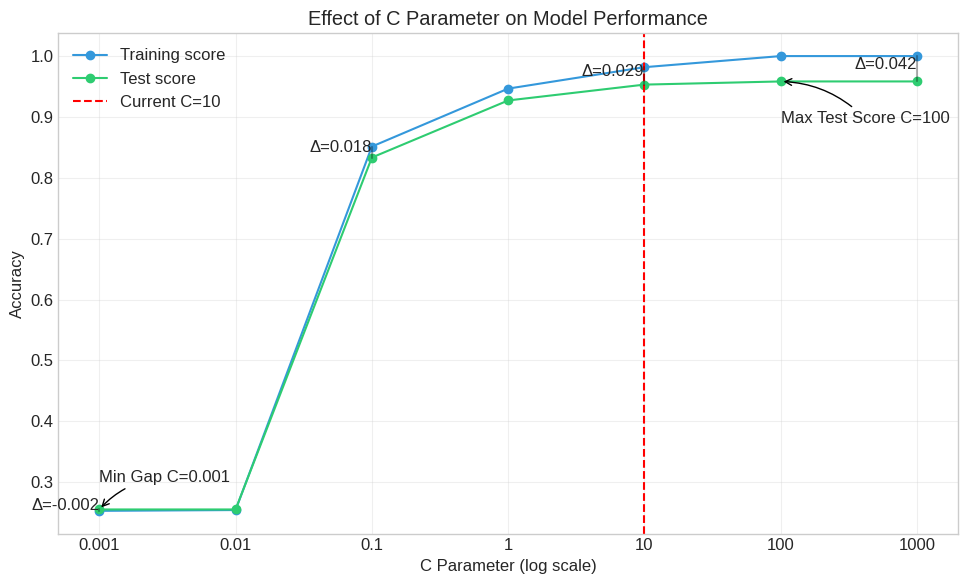

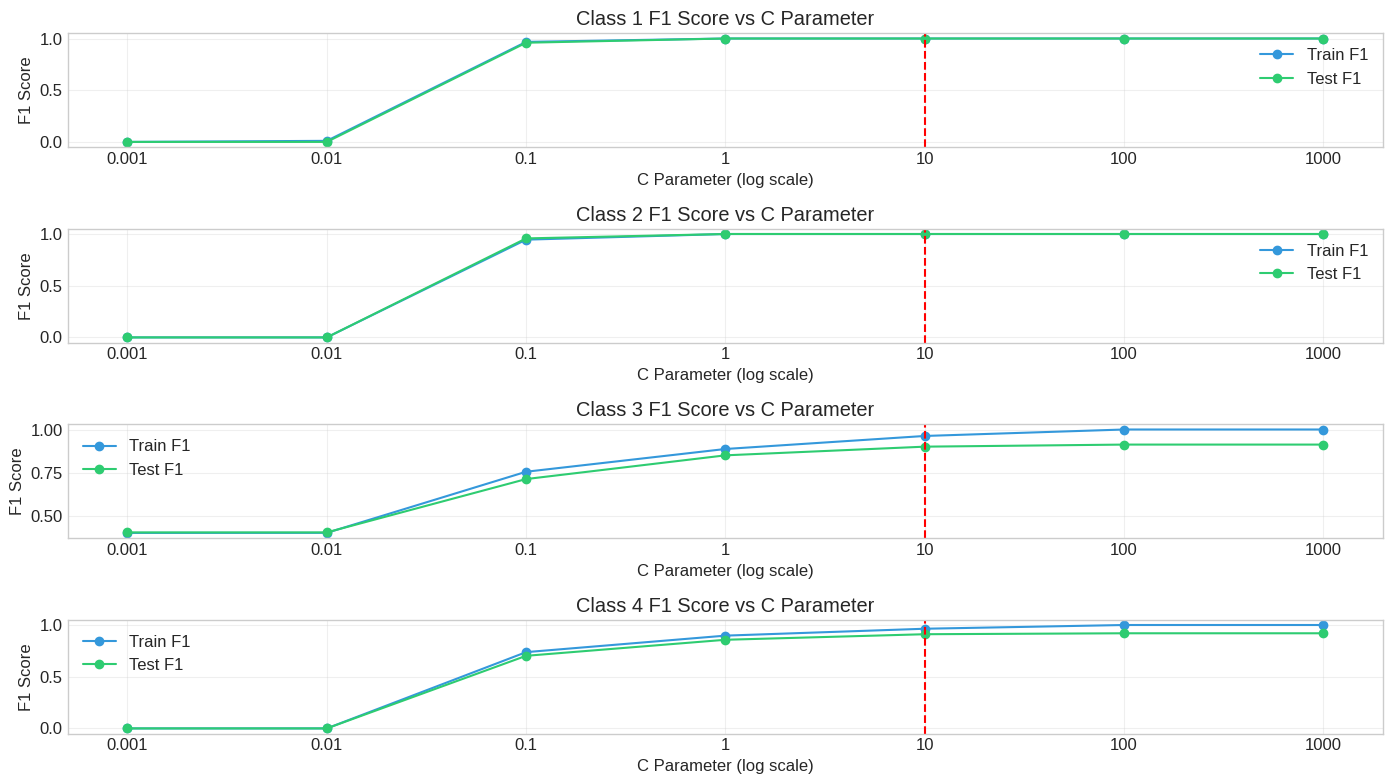


C parameter recommendations:
- Minimum overfitting gap at C=0.001
  Train accuracy: 0.2529, Test accuracy: 0.2552, Gap: -0.0023
- Maximum test score at C=100
  Train accuracy: 1.0000, Test accuracy: 0.9583, Gap: 0.0417
- Current model uses C=10
  Train accuracy: 0.9817, Test accuracy: 0.9531, Gap: 0.0286

⚠️ Recommendation: Consider changing C from 10 to either:
   - 0.001 for minimum overfitting (prioritizes generalization)
   - 100 for maximum test performance (prioritizes accuracy)

7. CROSS-VALIDATION STABILITY ASSESSMENT
Cross-validation scores: [0.9375     0.94791667 0.94791667 0.91666667 0.94764398]
Mean accuracy: 0.9395
Standard deviation: 0.0121
Range: 0.0312
Minimum: 0.9167
Maximum: 0.9479
Coefficient of variation: 0.0129

Detailed Fold-by-Fold Analysis:
Fold   Accuracy   Precision  Recall     F1         ROC AUC   
--------------------------------------------------------
1      0.9375     0.9430     0.9375     0.9372     0.9938
2      0.9479     0.9512     0.9479     0.9478 

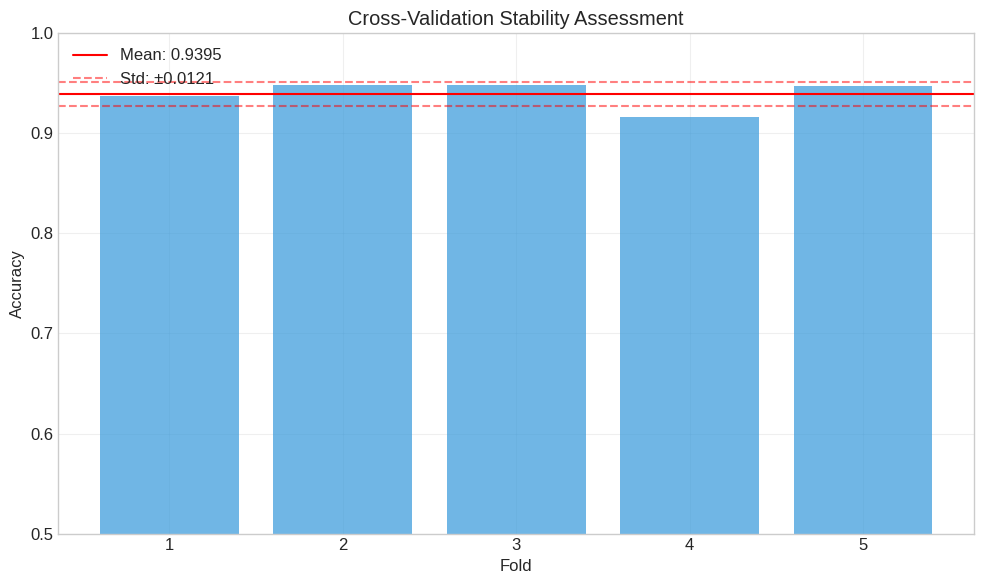

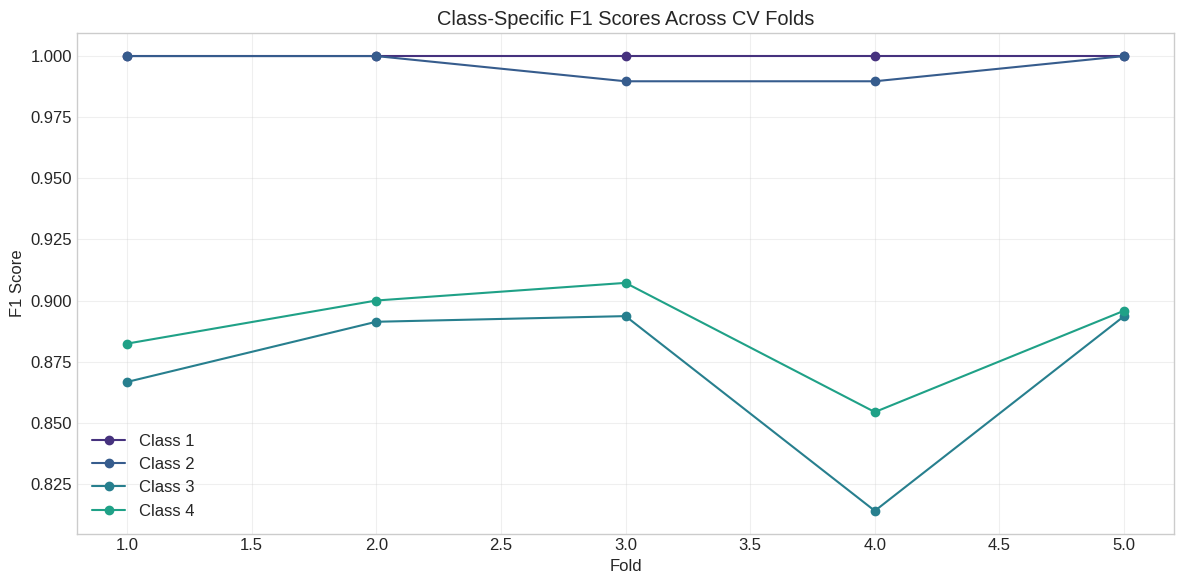


OVERFITTING ANALYSIS SUMMARY

Overfitting Indicators:
----------------------------------------------------------------------
Indicator                 Value      Status     Interpretation           
----------------------------------------------------------------------
Accuracy Gap              0.0286     ✅ OK       Acceptable gap           
Learning Curve Gap        nan     ✅ OK       Good generalization      
AUC Gap                   0.0042     ✅ OK       Consistent ranking       
Confidence Gap            0.0833     ✅ OK       Well-calibrated          
Cross-validation Stability 0.0121     ✅ OK       Stable performance       
----------------------------------------------------------------------

🎉 OVERALL ASSESSMENT: No significant overfitting detected
The model generalizes well to unseen data with consistent performance across metrics.
Training accuracy: 0.9817, Test accuracy: 0.9531
Current C value: 10 is appropriate for this model.

DETAILED RECOMMENDATIONS:
1. The model appea

In [18]:
# Overfitting Detection for SVM Employee Model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import learning_curve, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    accuracy_score, roc_curve, auc, precision_recall_fscore_support,
    roc_auc_score, classification_report, confusion_matrix
)
from sklearn.preprocessing import label_binarize
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pickle
from google.colab import files
import io
import warnings
warnings.filterwarnings('ignore')

# Upload the dataset and model in Google Colab
print("Upload your CSV dataset first:")
uploaded_data = files.upload()  # Upload the dataset
file_name = list(uploaded_data.keys())[0]

print("\nNow upload your saved SVM model:")
uploaded_model = files.upload()  # Upload the model
model_name = list(uploaded_model.keys())[0]

# Load the dataset
df = pd.read_csv(io.BytesIO(uploaded_data[file_name]))

# Convert string True/False to boolean for relevant columns
string_bool_columns = [col for col in df.columns if df[col].dtype == 'object' and
                       set(df[col].unique()).issubset({"True", "False"})]
for col in string_bool_columns:
    df[col] = df[col].map({"True": True, "False": False})

# Define features and target variable
X = df.drop('PerformanceScore_Encoded', axis=1)
y = df['PerformanceScore_Encoded']

# Load the trained model
with open(model_name, 'rb') as file:
    best_model = pickle.load(file)

print("\nModel loaded successfully!")
print(f"Model type: {type(best_model)}")
print(f"Pipeline steps: {best_model.named_steps.keys()}")
print(f"SVM kernel: {best_model.named_steps['classifier'].kernel}")
print(f"SVM C parameter: {best_model.named_steps['classifier'].C}")
print(f"SVM gamma parameter: {best_model.named_steps['classifier'].gamma if hasattr(best_model.named_steps['classifier'], 'gamma') else 'auto'}")

# Get the original data split that was used for training
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"Test set size: {X_test.shape[0]} samples, {X_test.shape[1]} features")

# Print class distribution
train_class_dist = pd.Series(y_train).value_counts(normalize=True)
test_class_dist = pd.Series(y_test).value_counts(normalize=True)
print("\nClass distribution:")
print("Training set:")
for cls, pct in train_class_dist.items():
    print(f"  Class {cls}: {pct:.2%} ({sum(y_train == cls)} samples)")
print("Test set:")
for cls, pct in test_class_dist.items():
    print(f"  Class {cls}: {pct:.2%} ({sum(y_test == cls)} samples)")

# ========================= 1. Comparing Metrics on Training and Test Sets =========================
def check_accuracy_gap():
    # Get predictions on training and test sets
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)

    # Calculate accuracies
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    accuracy_gap = train_accuracy - test_accuracy

    print("\n1. ACCURACY GAP ANALYSIS")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Accuracy Gap (Δ): {accuracy_gap:.4f}")

    # More detailed analysis
    print("\nDetailed Per-Class Accuracy Analysis:")
    classes = sorted(np.unique(y))

    print(f"{'Class':<10} {'Train Acc':<10} {'Test Acc':<10} {'Gap':<10} {'Status':<10}")
    print("-" * 50)

    for cls in classes:
        # Calculate per-class accuracy
        train_cls_acc = accuracy_score(y_train[y_train == cls], y_train_pred[y_train == cls])
        test_cls_acc = accuracy_score(y_test[y_test == cls], y_test_pred[y_test == cls])
        cls_gap = train_cls_acc - test_cls_acc

        status = "⚠️ Issue" if cls_gap > 0.1 else "✅ OK"
        print(f"{cls:<10} {train_cls_acc:.4f}     {test_cls_acc:.4f}     {cls_gap:.4f}     {status}")

    # Add confusion matrices
    print("\nTraining Set Confusion Matrix:")
    train_cm = confusion_matrix(y_train, y_train_pred)
    print(pd.DataFrame(train_cm, index=classes, columns=classes))

    print("\nTest Set Confusion Matrix:")
    test_cm = confusion_matrix(y_test, y_test_pred)
    print(pd.DataFrame(test_cm, index=classes, columns=classes))

    if accuracy_gap > 0.1:
        print("\n⚠️ Potential overfitting detected! (Δ > 0.1)")
        print(f"   The model performs {accuracy_gap:.2%} better on training data compared to test data.")
        print("   This suggests the model may have learned noise or patterns specific to the training data.")
    else:
        print("\n✅ No significant overfitting detected based on accuracy gap (Δ ≤ 0.1)")
        print(f"   The gap of {accuracy_gap:.2%} is within acceptable limits for generalization.")

    # Visualization of accuracy comparison
    plt.figure(figsize=(8, 6))
    bars = plt.bar(['Training', 'Test'], [train_accuracy, test_accuracy], color=['#3498db', '#2ecc71'])
    plt.ylim(0, 1.1)
    plt.ylabel('Accuracy')
    plt.title('Accuracy Comparison: Training vs Test')

    # Add text labels above bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}', ha='center', va='bottom')

    # Add a horizontal line for the threshold
    plt.axhline(y=train_accuracy - 0.1, color='r', linestyle='--', alpha=0.5)
    plt.text(1.05, train_accuracy - 0.1, 'Threshold (Δ = 0.1)', color='r', va='center')

    plt.tight_layout()
    plt.show()

    return train_accuracy, test_accuracy, accuracy_gap

# ========================= 2. Learning Curves Analysis =========================
def plot_learning_curves():
    print("\n2. LEARNING CURVES ANALYSIS")

    # Get the pipeline steps from the model
    preprocessor = best_model.named_steps['preprocessor']
    classifier = best_model.named_steps['classifier']

    # Create a new pipeline for learning curve evaluation
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])

    # Calculate learning curves
    train_sizes = np.linspace(0.1, 1.0, 10)
    train_sizes, train_scores, val_scores = learning_curve(
        pipeline, X, y, train_sizes=train_sizes, cv=5, scoring='accuracy', random_state=42, n_jobs=-1
    )

    # Calculate mean and standard deviation for training set scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    # Calculate mean and standard deviation for validation set scores
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    # Calculate the gap between training and validation curves
    gap = train_mean - val_mean
    avg_gap = np.mean(gap)

    # Determine if the curves are converging
    converging = gap[-1] < gap[0]

    # Determine if curves are stable (low standard deviation in later points)
    late_std_train = np.mean(train_std[-3:])
    late_std_val = np.mean(val_std[-3:])
    stable = late_std_train < 0.03 and late_std_val < 0.03

    print(f"Average gap between training and validation: {avg_gap:.4f}")
    print(f"Are curves converging? {'Yes' if converging else 'No'}")
    print(f"Are curves stable? {'Yes' if stable else 'No'}")

    # Print detailed data for each point on the learning curve
    print("\nDetailed Learning Curve Data:")
    print(f"{'Training Size':<15} {'Train Score':<15} {'Train Std':<15} {'Val Score':<15} {'Val Std':<15} {'Gap':<15}")
    print("-" * 90)

    for i, size in enumerate(train_sizes):
        print(f"{int(size * X_train.shape[0]):<15} {train_mean[i]:.4f}         {train_std[i]:.4f}         {val_mean[i]:.4f}         {val_std[i]:.4f}         {gap[i]:.4f}")

    # Additional insights about what the curves indicate
    print("\nLearning Curve Interpretation:")
    if train_mean[-1] > 0.9 and avg_gap > 0.1:
        print("- High training score with significant gap indicates overfitting")
    elif train_mean[-1] < 0.8 and avg_gap < 0.05:
        print("- Low scores on both curves with small gap suggests underfitting")
    elif converging and stable:
        print("- Converging and stable curves indicate good generalization")

    print(f"- Starting gap (with {int(train_sizes[0] * X_train.shape[0])} samples): {gap[0]:.4f}")
    print(f"- Ending gap (with {int(train_sizes[-1] * X_train.shape[0])} samples): {gap[-1]:.4f}")

    if avg_gap > 0.1:
        print("\n⚠️ Potential overfitting detected! (avg gap > 0.1)")
        print("   The persistent gap between training and validation scores suggests")
        print("   the model is not generalizing well to unseen data.")
    else:
        print("\n✅ No significant overfitting detected based on learning curves (avg gap ≤ 0.1)")
        print("   The model seems to generalize well as the gap is acceptable.")

    # Plot learning curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, 'o-', color='#3498db', label='Training score')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='#3498db')

    plt.plot(train_sizes, val_mean, 'o-', color='#2ecc71', label='Cross-validation score')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='#2ecc71')

    plt.title('Learning Curves for SVM Model')
    plt.xlabel('Training Examples')
    plt.ylabel('Accuracy Score')
    plt.grid(True)
    plt.legend(loc='best')

    # Add annotation for the gap
    plt.annotate(f'Avg Gap: {avg_gap:.4f}',
                xy=(0.5, 0.5), xycoords='axes fraction',
                bbox=dict(boxstyle="round,pad=0.3", fc="#f8f9fa", ec="#343a40", alpha=0.8))

    plt.tight_layout()
    plt.show()

    return avg_gap, converging, stable

# ========================= 3. ROC Analysis and AUC Comparison =========================
def perform_roc_analysis():
    print("\n3. ROC ANALYSIS AND AUC COMPARISON")

    # Get the number of classes
    n_classes = len(np.unique(y))

    # Binarize the output for multi-class ROC analysis
    y_train_bin = label_binarize(y_train, classes=sorted(np.unique(y)))
    y_test_bin = label_binarize(y_test, classes=sorted(np.unique(y)))

    # Get probability predictions
    y_train_score = best_model.predict_proba(X_train)
    y_test_score = best_model.predict_proba(X_test)

    # Calculate ROC curve and AUC for each class
    fpr_train = dict()
    tpr_train = dict()
    roc_auc_train = dict()

    fpr_test = dict()
    tpr_test = dict()
    roc_auc_test = dict()

    # Store optimal thresholds
    optimal_thresholds_train = dict()
    optimal_thresholds_test = dict()

    for i in range(n_classes):
        fpr_train[i], tpr_train[i], thresholds_train = roc_curve(y_train_bin[:, i], y_train_score[:, i])
        roc_auc_train[i] = auc(fpr_train[i], tpr_train[i])

        # Find optimal threshold (closest to top-left corner)
        optimal_idx_train = np.argmax(tpr_train[i] - fpr_train[i])
        optimal_thresholds_train[i] = thresholds_train[optimal_idx_train]

        fpr_test[i], tpr_test[i], thresholds_test = roc_curve(y_test_bin[:, i], y_test_score[:, i])
        roc_auc_test[i] = auc(fpr_test[i], tpr_test[i])

        # Find optimal threshold (closest to top-left corner)
        optimal_idx_test = np.argmax(tpr_test[i] - fpr_test[i])
        optimal_thresholds_test[i] = thresholds_test[optimal_idx_test]

    # Calculate macro-average AUC
    macro_auc_train = np.mean([roc_auc_train[i] for i in range(n_classes)])
    macro_auc_test = np.mean([roc_auc_test[i] for i in range(n_classes)])
    auc_gap = macro_auc_train - macro_auc_test

    print(f"Training Set Macro-AUC: {macro_auc_train:.4f}")
    print(f"Test Set Macro-AUC: {macro_auc_test:.4f}")
    print(f"AUC Gap (Δ): {auc_gap:.4f}")

    # Detailed class-specific ROC analysis
    print("\nDetailed Class-Specific ROC Analysis:")
    print(f"{'Class':<10} {'Train AUC':<12} {'Test AUC':<12} {'AUC Gap':<12} {'Train Threshold':<16} {'Test Threshold':<16} {'Status':<10}")
    print("-" * 80)

    for i in range(n_classes):
        class_gap = roc_auc_train[i] - roc_auc_test[i]
        status = "⚠️ Issue" if class_gap > 0.05 else "✅ OK"

        print(f"{i:<10} {roc_auc_train[i]:.4f}      {roc_auc_test[i]:.4f}      {class_gap:.4f}      {optimal_thresholds_train[i]:.4f}          {optimal_thresholds_test[i]:.4f}          {status}")

    # Calculate and print optimal sensitivity, specificity at chosen threshold
    print("\nOptimal Operating Points (Test Set):")
    for i in range(n_classes):
        # We need to use the class-specific thresholds
        # The optimal index was already found when calculating optimal_thresholds_test
        optimal_idx_test = np.argmax(tpr_test[i] - fpr_test[i])
        sensitivity = tpr_test[i][optimal_idx_test]
        specificity = 1 - fpr_test[i][optimal_idx_test]

        print(f"Class {i}: Threshold={optimal_thresholds_test[i]:.4f}, Sensitivity={sensitivity:.4f}, Specificity={specificity:.4f}")

    # Interpretation of results
    if auc_gap > 0.05:
        print("\n⚠️ Potential overfitting detected! (ΔAUC > 0.05)")
        print(f"   The model's discriminative ability is {auc_gap:.2%} better on training data")
        print("   compared to test data, suggesting it's learning patterns specific to the training set.")
    else:
        print("\n✅ No significant overfitting detected based on AUC gap (ΔAUC ≤ 0.05)")
        print(f"   The AUC gap of {auc_gap:.2%} suggests good generalization of the model's discriminative ability.")

    # Plot ROC curves
    plt.figure(figsize=(12, 8))

    # Plot macro-average ROC curve for training
    plt.plot([0, 1], [0, 1], 'k--', lw=2)

    # Plot class-specific ROC curves
    colors = plt.cm.tab10(np.linspace(0, 1, n_classes))

    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr_train[i], tpr_train[i], color=color, lw=2, linestyle='-',
                 label=f'Train ROC class {i+1} (AUC = {roc_auc_train[i]:.3f})')

        plt.plot(fpr_test[i], tpr_test[i], color=color, lw=2, linestyle='--',
                 label=f'Test ROC class {i+1} (AUC = {roc_auc_test[i]:.3f})')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Training and Test Sets')
    plt.legend(loc="lower right")

    # Add annotation for the gap
    plt.annotate(f'Macro AUC Gap: {auc_gap:.4f}',
                xy=(0.5, 0.2), xycoords='axes fraction',
                bbox=dict(boxstyle="round,pad=0.3", fc="#f8f9fa", ec="#343a40", alpha=0.8))

    plt.tight_layout()
    plt.show()

    # Bar chart comparing class-specific AUCs
    plt.figure(figsize=(10, 6))

    class_labels = [f'Class {i+1}' for i in range(n_classes)]
    x = np.arange(len(class_labels))
    width = 0.35

    train_aucs = [roc_auc_train[i] for i in range(n_classes)]
    test_aucs = [roc_auc_test[i] for i in range(n_classes)]

    fig, ax = plt.subplots(figsize=(12, 6))
    bars1 = ax.bar(x - width/2, train_aucs, width, label='Training', color='#3498db')
    bars2 = ax.bar(x + width/2, test_aucs, width, label='Test', color='#2ecc71')

    ax.set_ylim(0, 1.1)
    ax.set_ylabel('AUC')
    ax.set_title('Class-Specific AUC Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(class_labels)
    ax.legend()

    # Add AUC gap annotations
    for i in range(n_classes):
        gap = train_aucs[i] - test_aucs[i]
        ax.annotate(f'Δ={gap:.3f}',
                   xy=(i, max(train_aucs[i], test_aucs[i]) + 0.05),
                   ha='center', va='bottom',
                   color='red' if gap > 0.05 else 'green')

    plt.tight_layout()
    plt.show()

    return macro_auc_train, macro_auc_test, auc_gap

# ========================= 4. Class-Specific Metrics Analysis =========================
def analyze_class_metrics():
    print("\n4. CLASS-SPECIFIC METRICS ANALYSIS")

    # Get predictions
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)

    # Calculate metrics for training set
    precision_train, recall_train, f1_train, _ = precision_recall_fscore_support(y_train, y_train_pred, average=None)

    # Calculate metrics for test set
    precision_test, recall_test, f1_test, _ = precision_recall_fscore_support(y_test, y_test_pred, average=None)

    # Calculate differences
    precision_diff = precision_train - precision_test
    recall_diff = recall_train - recall_test
    f1_diff = f1_train - f1_test

    # Calculate macro and weighted averages
    train_report = classification_report(y_train, y_train_pred, output_dict=True)
    test_report = classification_report(y_test, y_test_pred, output_dict=True)

    # Check for overfitting in each class
    classes = sorted(np.unique(y))

    # Print class-specific metrics with more details
    print("\nDetailed Class-specific Metrics:")
    print(f"{'Class':<10} {'Metric':<10} {'Train':<10} {'Test':<10} {'Diff':<10} {'Status':<10}")
    print("-" * 60)

    # Define a function to determine metric status
    def get_status(diff, threshold=0.1):
        if diff > threshold:
            return "⚠️ Issue"
        elif diff < -threshold:
            return "⚠️ Lower"
        else:
            return "✅ OK"

    # Track problematic classes
    overfit_classes = []
    underperform_classes = []

    for i, cls in enumerate(classes):
        # Check precision
        p_status = get_status(precision_diff[i])
        print(f"{cls:<10} {'Precision':<10} {precision_train[i]:.4f}    {precision_test[i]:.4f}    {precision_diff[i]:.4f}    {p_status}")

        # Check recall
        r_status = get_status(recall_diff[i])
        print(f"{'':<10} {'Recall':<10} {recall_train[i]:.4f}    {recall_test[i]:.4f}    {recall_diff[i]:.4f}    {r_status}")

        # Check F1
        f1_status = get_status(f1_diff[i])
        print(f"{'':<10} {'F1-Score':<10} {f1_train[i]:.4f}    {f1_test[i]:.4f}    {f1_diff[i]:.4f}    {f1_status}")

        # Add separator between classes
        if i < len(classes) - 1:
            print("-" * 60)

        # Track if class has overfitting issues
        if abs(precision_diff[i]) > 0.1 or abs(recall_diff[i]) > 0.1 or abs(f1_diff[i]) > 0.1:
            if precision_diff[i] > 0.1 or recall_diff[i] > 0.1 or f1_diff[i] > 0.1:
                overfit_classes.append(cls)
            else:
                underperform_classes.append(cls)

    # Print aggregated metrics
    print("\nAggregated Metrics:")
    print(f"{'Average':<10} {'Metric':<10} {'Train':<10} {'Test':<10} {'Diff':<10} {'Status':<10}")
    print("-" * 60)

    # Macro averages
    macro_precision_diff = train_report['macro avg']['precision'] - test_report['macro avg']['precision']
    macro_recall_diff = train_report['macro avg']['recall'] - test_report['macro avg']['recall']
    macro_f1_diff = train_report['macro avg']['f1-score'] - test_report['macro avg']['f1-score']

    print(f"{'Macro':<10} {'Precision':<10} {train_report['macro avg']['precision']:.4f}    {test_report['macro avg']['precision']:.4f}    {macro_precision_diff:.4f}    {get_status(macro_precision_diff)}")
    print(f"{'':<10} {'Recall':<10} {train_report['macro avg']['recall']:.4f}    {test_report['macro avg']['recall']:.4f}    {macro_recall_diff:.4f}    {get_status(macro_recall_diff)}")
    print(f"{'':<10} {'F1-Score':<10} {train_report['macro avg']['f1-score']:.4f}    {test_report['macro avg']['f1-score']:.4f}    {macro_f1_diff:.4f}    {get_status(macro_f1_diff)}")

    # Weighted averages
    weighted_precision_diff = train_report['weighted avg']['precision'] - test_report['weighted avg']['precision']
    weighted_recall_diff = train_report['weighted avg']['recall'] - test_report['weighted avg']['recall']
    weighted_f1_diff = train_report['weighted avg']['f1-score'] - test_report['weighted avg']['f1-score']

    print("-" * 60)
    print(f"{'Weighted':<10} {'Precision':<10} {train_report['weighted avg']['precision']:.4f}    {test_report['weighted avg']['precision']:.4f}    {weighted_precision_diff:.4f}    {get_status(weighted_precision_diff)}")
    print(f"{'':<10} {'Recall':<10} {train_report['weighted avg']['recall']:.4f}    {test_report['weighted avg']['recall']:.4f}    {weighted_recall_diff:.4f}    {get_status(weighted_recall_diff)}")
    print(f"{'':<10} {'F1-Score':<10} {train_report['weighted avg']['f1-score']:.4f}    {test_report['weighted avg']['f1-score']:.4f}    {weighted_f1_diff:.4f}    {get_status(weighted_f1_diff)}")

    # Summary of findings
    if overfit_classes:
        print(f"\n⚠️ Potential class-specific overfitting detected in classes: {overfit_classes}")
        print("   This indicates the model has learned patterns specific to these classes in the training data")
        print("   that do not generalize well to the test set.")

    if underperform_classes:
        print(f"\n⚠️ Classes performing better on test than training: {underperform_classes}")
        print("   This unusual pattern could indicate sampling issues, data leakage, or class imbalance problems.")

    if not overfit_classes and not underperform_classes:
        print("\n✅ No significant class-specific overfitting detected")
        print("   All classes show consistent performance between training and test sets.")

    # Create a heatmap of metric differences
    metrics_diff = pd.DataFrame({
        'Class': classes,
        'Precision Δ': precision_diff,
        'Recall Δ': recall_diff,
        'F1 Δ': f1_diff
    })

    metrics_diff_pivot = metrics_diff.melt(id_vars=['Class'], var_name='Metric', value_name='Difference')
    pivot_table = metrics_diff_pivot.pivot(index='Class', columns='Metric', values='Difference')

    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot_table, annot=True, cmap='RdBu_r', center=0, fmt='.3f', cbar_kws={'label': 'Difference (Train - Test)'})
    plt.title('Class-Specific Metrics Differences (Training - Test)')
    plt.tight_layout()
    plt.show()

    return metrics_diff, overfit_classes, underperform_classes

# ========================= 5. Prediction Confidence Analysis =========================
def analyze_prediction_confidence():
    print("\n5. PREDICTION CONFIDENCE ANALYSIS")

    # Get probability predictions
    y_train_proba = best_model.predict_proba(X_train)
    y_test_proba = best_model.predict_proba(X_test)

    # Get the max probability for each prediction (confidence)
    train_confidence = np.max(y_train_proba, axis=1)
    test_confidence = np.max(y_test_proba, axis=1)

    # Basic statistics
    print("\nConfidence Statistics:")
    print(f"{'Statistic':<15} {'Training':<15} {'Test':<15} {'Difference':<15}")
    print("-" * 60)

    # Mean confidence
    mean_train_conf = np.mean(train_confidence)
    mean_test_conf = np.mean(test_confidence)
    print(f"{'Mean':<15} {mean_train_conf:.4f}        {mean_test_conf:.4f}        {mean_train_conf - mean_test_conf:.4f}")

    # Median confidence
    median_train_conf = np.median(train_confidence)
    median_test_conf = np.median(test_confidence)
    print(f"{'Median':<15} {median_train_conf:.4f}        {median_test_conf:.4f}        {median_train_conf - median_test_conf:.4f}")

    # Min confidence
    min_train_conf = np.min(train_confidence)
    min_test_conf = np.min(test_confidence)
    print(f"{'Min':<15} {min_train_conf:.4f}        {min_test_conf:.4f}        {min_train_conf - min_test_conf:.4f}")

    # Max confidence
    max_train_conf = np.max(train_confidence)
    max_test_conf = np.max(test_confidence)
    print(f"{'Max':<15} {max_train_conf:.4f}        {max_test_conf:.4f}        {max_train_conf - max_test_conf:.4f}")

    # Standard deviation
    std_train_conf = np.std(train_confidence)
    std_test_conf = np.std(test_confidence)
    print(f"{'Std Dev':<15} {std_train_conf:.4f}        {std_test_conf:.4f}        {std_train_conf - std_test_conf:.4f}")

    # Calculate confidence thresholds
    thresholds = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95]

    print("\nConfidence Distribution by Threshold:")
    print(f"{'Threshold':<10} {'Training %':<15} {'Test %':<15} {'Difference':<15} {'Status':<10}")
    print("-" * 65)

    for threshold in thresholds:
        train_above = np.mean(train_confidence >= threshold)
        test_above = np.mean(test_confidence >= threshold)
        diff = train_above - test_above

        status = "⚠️ Issue" if diff > 0.1 else "✅ OK"

        print(f"≥ {threshold:<8} {train_above:.2%}         {test_above:.2%}         {diff:.2%}           {status}")

    # Calculate high confidence proportions
    high_conf_threshold = 0.8
    train_high_conf = np.mean(train_confidence >= high_conf_threshold)
    test_high_conf = np.mean(test_confidence >= high_conf_threshold)

    # Class-specific confidence analysis
    classes = sorted(np.unique(y))

    print("\nClass-Specific Confidence Analysis:")
    print(f"{'Class':<10} {'Train Mean':<15} {'Test Mean':<15} {'Difference':<15} {'Status':<10}")
    print("-" * 65)

    for cls in classes:
        # Get indices for this class
        train_cls_idx = (y_train == cls)
        test_cls_idx = (y_test == cls)

        # Calculate mean confidence for the class
        train_cls_conf = np.mean(train_confidence[train_cls_idx])
        test_cls_conf = np.mean(test_confidence[test_cls_idx])
        diff = train_cls_conf - test_cls_conf

        status = "⚠️ Issue" if diff > 0.1 else "✅ OK"

        print(f"{cls:<10} {train_cls_conf:.4f}        {test_cls_conf:.4f}        {diff:.4f}          {status}")

    # Decision quality analysis
    train_pred = best_model.predict(X_train)
    test_pred = best_model.predict(X_test)

    # Correct prediction confidence
    train_correct = (train_pred == y_train)
    test_correct = (test_pred == y_test)

    # Mean confidence for correct and incorrect predictions
    train_correct_conf = np.mean(train_confidence[train_correct])
    train_incorrect_conf = np.mean(train_confidence[~train_correct])
    test_correct_conf = np.mean(test_confidence[test_correct])
    test_incorrect_conf = np.mean(test_confidence[~test_correct])

    print("\nConfidence for Correct vs Incorrect Predictions:")
    print(f"{'Prediction':<12} {'Training':<15} {'Test':<15} {'Difference':<15}")
    print("-" * 57)
    print(f"{'Correct':<12} {train_correct_conf:.4f}        {test_correct_conf:.4f}        {train_correct_conf - test_correct_conf:.4f}")
    print(f"{'Incorrect':<12} {train_incorrect_conf:.4f}        {test_incorrect_conf:.4f}        {train_incorrect_conf - test_incorrect_conf:.4f}")
    print(f"{'Difference':<12} {train_correct_conf - train_incorrect_conf:.4f}        {test_correct_conf - test_incorrect_conf:.4f}")

    # Calibration analysis
    print("\nCalibration Analysis:")
    n_bins = 10
    bin_edges = np.linspace(0, 1, n_bins + 1)
    bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2

    # Training set calibration - using histogram approach instead of digitize
    train_bin_accuracies = np.zeros(n_bins)
    train_bin_counts = np.zeros(n_bins)

    # For each confidence score, find the appropriate bin and update counts
    for i in range(len(train_confidence)):
        # Find bin index using binary search
        bin_idx = min(int(train_confidence[i] * n_bins), n_bins - 1)  # Ensure index is within bounds
        train_bin_counts[bin_idx] += 1
        if train_pred[i] == y_train.iloc[i]:  # Use iloc for pandas Series
            train_bin_accuracies[bin_idx] += 1

    # Avoid division by zero
    train_bin_accuracies = np.divide(train_bin_accuracies, train_bin_counts,
                                     out=np.zeros_like(train_bin_accuracies),
                                     where=train_bin_counts != 0)

    # Test set calibration
    test_bin_accuracies = np.zeros(n_bins)
    test_bin_counts = np.zeros(n_bins)

    # For each confidence score, find the appropriate bin and update counts
    for i in range(len(test_confidence)):
        # Find bin index using binary search
        bin_idx = min(int(test_confidence[i] * n_bins), n_bins - 1)  # Ensure index is within bounds
        test_bin_counts[bin_idx] += 1
        if test_pred[i] == y_test.iloc[i]:  # Use iloc for pandas Series
            test_bin_accuracies[bin_idx] += 1

    # Avoid division by zero
    test_bin_accuracies = np.divide(test_bin_accuracies, test_bin_counts,
                                   out=np.zeros_like(test_bin_accuracies),
                                   where=test_bin_counts != 0)

    # Print calibration details
    print(f"{'Conf Range':<15} {'Train Acc':<12} {'Test Acc':<12} {'Train Count':<12} {'Test Count':<12}")
    print("-" * 63)

    for i in range(n_bins):
        bin_start = bin_edges[i]
        bin_end = bin_edges[i+1]
        train_acc_str = f"{train_bin_accuracies[i]:.4f}" if train_bin_counts[i] > 0 else "N/A"
        test_acc_str = f"{test_bin_accuracies[i]:.4f}" if test_bin_counts[i] > 0 else "N/A"
        print(f"{bin_start:.1f}-{bin_end:.1f}       {train_acc_str:<12} {test_acc_str:<12} {int(train_bin_counts[i]):<12} {int(test_bin_counts[i]):<12}")

    # Overall confidence gap assessment
    conf_gap = train_high_conf - test_high_conf

    if conf_gap > 0.1:
        print("\n⚠️ Potential overfitting detected! (confidence gap > 0.1)")
        print(f"   The model is {conf_gap:.2%} more confident on training data than test data,")
        print("   suggesting it may be too certain about patterns specific to the training set.")
    else:
        print("\n✅ No significant overfitting detected based on prediction confidence")
        print(f"   The confidence gap of {conf_gap:.2%} is within acceptable limits.")

    # Plot confidence histograms
    plt.figure(figsize=(12, 6))

    # Training set confidence histogram
    plt.subplot(1, 2, 1)
    plt.hist(train_confidence, bins=20, alpha=0.7, color='#3498db')
    plt.axvline(x=high_conf_threshold, color='r', linestyle='--')
    plt.title(f'Training Set Confidence\nHigh Conf: {train_high_conf:.4f}')
    plt.xlabel('Prediction Confidence')
    plt.ylabel('Count')

    # Test set confidence histogram
    plt.subplot(1, 2, 2)
    plt.hist(test_confidence, bins=20, alpha=0.7, color='#2ecc71')
    plt.axvline(x=high_conf_threshold, color='r', linestyle='--')
    plt.title(f'Test Set Confidence\nHigh Conf: {test_high_conf:.4f}')
    plt.xlabel('Prediction Confidence')
    plt.ylabel('Count')

    plt.tight_layout()
    plt.show()

    # Compare overall confidence distributions
    plt.figure(figsize=(10, 6))
    sns.kdeplot(train_confidence, label='Training', color='#3498db')
    sns.kdeplot(test_confidence, label='Test', color='#2ecc71')
    plt.axvline(x=high_conf_threshold, color='r', linestyle='--', label=f'Threshold ({high_conf_threshold})')
    plt.title('Prediction Confidence Distribution')
    plt.xlabel('Confidence')
    plt.ylabel('Density')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot calibration curves
    plt.figure(figsize=(10, 6))
    plt.plot(bin_centers, train_bin_accuracies, 'o-', color='#3498db', label='Training')
    plt.plot(bin_centers, test_bin_accuracies, 'o-', color='#2ecc71', label='Test')
    plt.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')
    plt.xlabel('Mean predicted confidence')
    plt.ylabel('Accuracy')
    plt.title('Calibration Curves')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return train_high_conf, test_high_conf, conf_gap

# ========================= 6. Regularization Parameter Analysis =========================
def analyze_regularization_parameter():
    print("\n6. REGULARIZATION PARAMETER ANALYSIS")

    # Identify the classifier and preprocessor from the pipeline
    preprocessor = best_model.named_steps['preprocessor']
    best_C = best_model.named_steps['classifier'].C

    print(f"Current C parameter value: {best_C}")
    print(f"Kernel type: {best_model.named_steps['classifier'].kernel}")

    # Define a range of C values to test
    C_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

    # If best_C is not in our list, add it
    if best_C not in C_values:
        C_values.append(best_C)
        C_values.sort()

    # Scores containers
    train_scores = []
    test_scores = []

    # Additional per-class metrics
    class_train_f1 = []
    class_test_f1 = []

    print("\nTesting different C values...")
    print(f"{'C Value':<10} {'Train Acc':<12} {'Test Acc':<12} {'Gap':<10} {'Status':<10}")
    print("-" * 54)

    for C in C_values:
        # Create a new SVM with the current C value
        svm = SVC(C=C, probability=True, random_state=42, kernel=best_model.named_steps['classifier'].kernel)

        # Create a pipeline with the same preprocessor
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', svm)
        ])

        # Fit the model
        pipeline.fit(X_train, y_train)

        # Get scores
        train_score = pipeline.score(X_train, y_train)
        test_score = pipeline.score(X_test, y_test)
        gap = train_score - test_score

        train_scores.append(train_score)
        test_scores.append(test_score)

        # Get class-specific metrics
        y_train_pred = pipeline.predict(X_train)
        y_test_pred = pipeline.predict(X_test)

        # Get per-class F1 scores
        _, _, f1_train, _ = precision_recall_fscore_support(y_train, y_train_pred, average=None)
        _, _, f1_test, _ = precision_recall_fscore_support(y_test, y_test_pred, average=None)

        class_train_f1.append(f1_train)
        class_test_f1.append(f1_test)

        # Print results for this C value
        status = "⚠️ Issue" if gap > 0.1 else "✅ OK"
        print(f"{C:<10} {train_score:.4f}       {test_score:.4f}       {gap:.4f}    {status}")

    # Convert C values to strings for plotting
    C_values_str = [str(C) for C in C_values]

    # Find the index of the best C value in our list
    best_C_idx = C_values.index(best_C)

    # Calculate the gaps
    gaps = np.array(train_scores) - np.array(test_scores)

    # Find the C with minimum gap
    min_gap_idx = np.argmin(gaps)
    min_gap_C = C_values[min_gap_idx]

    # Find the C with maximum test score
    max_test_idx = np.argmax(test_scores)
    max_test_C = C_values[max_test_idx]

    # Print detailed class-specific analysis for best C values
    print("\nClass-specific F1 scores at key C values:")
    classes = sorted(np.unique(y))

    print(f"\nCurrent C={best_C}:")
    for i, cls in enumerate(classes):
        print(f"Class {cls}: Train F1={class_train_f1[best_C_idx][i]:.4f}, Test F1={class_test_f1[best_C_idx][i]:.4f}, Gap={class_train_f1[best_C_idx][i] - class_test_f1[best_C_idx][i]:.4f}")

    print(f"\nMinimum gap C={min_gap_C}:")
    for i, cls in enumerate(classes):
        print(f"Class {cls}: Train F1={class_train_f1[min_gap_idx][i]:.4f}, Test F1={class_test_f1[min_gap_idx][i]:.4f}, Gap={class_train_f1[min_gap_idx][i] - class_test_f1[min_gap_idx][i]:.4f}")

    print(f"\nMaximum test score C={max_test_C}:")
    for i, cls in enumerate(classes):
        print(f"Class {cls}: Train F1={class_train_f1[max_test_idx][i]:.4f}, Test F1={class_test_f1[max_test_idx][i]:.4f}, Gap={class_train_f1[max_test_idx][i] - class_test_f1[max_test_idx][i]:.4f}")

    # Plot the regularization parameter curve
    plt.figure(figsize=(10, 6))
    plt.plot(C_values_str, train_scores, 'o-', color='#3498db', label='Training score')
    plt.plot(C_values_str, test_scores, 'o-', color='#2ecc71', label='Test score')

    # Mark the current C value
    plt.axvline(x=best_C_idx, color='r', linestyle='--', label=f'Current C={best_C}')

    plt.title('Effect of C Parameter on Model Performance')
    plt.xlabel('C Parameter (log scale)')
    plt.ylabel('Accuracy')
    plt.grid(True, alpha=0.3)
    plt.legend(loc='best')

    # Add annotations
    plt.annotate(f'Min Gap C={min_gap_C}',
                xy=(C_values_str[min_gap_idx], test_scores[min_gap_idx]),
                xytext=(0, 20), textcoords='offset points',
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))

    plt.annotate(f'Max Test Score C={max_test_C}',
                xy=(C_values_str[max_test_idx], test_scores[max_test_idx]),
                xytext=(0, -30), textcoords='offset points',
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))

    # Add horizontal lines for each gap
    for i, (C, gap) in enumerate(zip(C_values_str, gaps)):
        if i % 2 == 0:  # Add for every other C value to avoid clutter
            plt.plot([i, i], [test_scores[i], train_scores[i]], 'k-', alpha=0.3)
            plt.text(i, (test_scores[i] + train_scores[i])/2, f'Δ={gap:.3f}', ha='right')

    plt.tight_layout()
    plt.show()

    # Plot class-specific F1 scores for different C values
    plt.figure(figsize=(14, 8))

    for i, cls in enumerate(classes):
        plt.subplot(len(classes), 1, i + 1)

        # Extract class-specific F1 scores
        cls_train_f1 = [f1[i] for f1 in class_train_f1]
        cls_test_f1 = [f1[i] for f1 in class_test_f1]

        plt.plot(C_values_str, cls_train_f1, 'o-', color='#3498db', label='Train F1')
        plt.plot(C_values_str, cls_test_f1, 'o-', color='#2ecc71', label='Test F1')

        plt.axvline(x=best_C_idx, color='r', linestyle='--')
        plt.title(f'Class {cls} F1 Score vs C Parameter')
        plt.xlabel('C Parameter (log scale)')
        plt.ylabel('F1 Score')
        plt.grid(True, alpha=0.3)
        plt.legend()

    plt.tight_layout()
    plt.show()

    # Recommendations
    print(f"\nC parameter recommendations:")
    print(f"- Minimum overfitting gap at C={min_gap_C}")
    print(f"  Train accuracy: {train_scores[min_gap_idx]:.4f}, Test accuracy: {test_scores[min_gap_idx]:.4f}, Gap: {gaps[min_gap_idx]:.4f}")

    print(f"- Maximum test score at C={max_test_C}")
    print(f"  Train accuracy: {train_scores[max_test_idx]:.4f}, Test accuracy: {test_scores[max_test_idx]:.4f}, Gap: {gaps[max_test_idx]:.4f}")

    print(f"- Current model uses C={best_C}")
    print(f"  Train accuracy: {train_scores[best_C_idx]:.4f}, Test accuracy: {test_scores[best_C_idx]:.4f}, Gap: {gaps[best_C_idx]:.4f}")

    if best_C != min_gap_C and best_C != max_test_C:
        if min_gap_C == max_test_C:
            print(f"\n⚠️ Recommendation: Change C from {best_C} to {min_gap_C} for better generalization and performance")
            print("   This would improve both the overfitting gap and test accuracy.")
        else:
            print(f"\n⚠️ Recommendation: Consider changing C from {best_C} to either:")
            print(f"   - {min_gap_C} for minimum overfitting (prioritizes generalization)")
            print(f"   - {max_test_C} for maximum test performance (prioritizes accuracy)")
    else:
        print("\n✅ Current C parameter is optimal")
        if best_C == min_gap_C:
            print("   Your model is already using the C value with minimum overfitting.")
        else:
            print("   Your model is already using the C value with maximum test performance.")

    return train_scores, test_scores, C_values, best_C, min_gap_C, max_test_C

# ========================= 7. Cross-Validation Stability Assessment =========================
def assess_cv_stability():
    print("\n7. CROSS-VALIDATION STABILITY ASSESSMENT")

    # Define cross-validation
    n_splits = 5
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Get the classifier and preprocessor from the pipeline
    classifier = best_model.named_steps['classifier']
    preprocessor = best_model.named_steps['preprocessor']

    # Create a new pipeline for cross-validation
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])

    # Perform cross-validation for accuracy
    cv_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy')

    # Calculate stability metrics
    cv_mean = np.mean(cv_scores)
    cv_std = np.std(cv_scores)
    cv_range = np.max(cv_scores) - np.min(cv_scores)
    cv_min = np.min(cv_scores)
    cv_max = np.max(cv_scores)

    print(f"Cross-validation scores: {cv_scores}")
    print(f"Mean accuracy: {cv_mean:.4f}")
    print(f"Standard deviation: {cv_std:.4f}")
    print(f"Range: {cv_range:.4f}")
    print(f"Minimum: {cv_min:.4f}")
    print(f"Maximum: {cv_max:.4f}")
    print(f"Coefficient of variation: {cv_std/cv_mean:.4f}")

    # Get more detailed metrics for each fold
    print("\nDetailed Fold-by-Fold Analysis:")
    print(f"{'Fold':<6} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1':<10} {'ROC AUC':<10}")
    print("-" * 56)

    fold_metrics = []

    for i, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        X_fold_train, X_fold_val = X.iloc[train_idx], X.iloc[val_idx]
        y_fold_train, y_fold_val = y.iloc[train_idx], y.iloc[val_idx]

        # Train the model
        pipeline.fit(X_fold_train, y_fold_train)

        # Get predictions
        y_fold_pred = pipeline.predict(X_fold_val)

        # Calculate metrics
        accuracy = accuracy_score(y_fold_val, y_fold_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_fold_val, y_fold_pred, average='weighted')

        # Get probabilities for AUC
        if hasattr(pipeline, "predict_proba"):
            y_fold_proba = pipeline.predict_proba(X_fold_val)

            # For multiclass problems, we use weighted average of one-vs-rest AUCs
            if len(np.unique(y)) > 2:
                y_fold_bin = label_binarize(y_fold_val, classes=sorted(np.unique(y)))
                n_classes = y_fold_bin.shape[1]

                auc_scores = []
                for cls in range(n_classes):
                    if len(np.unique(y_fold_bin[:, cls])) > 1:  # Check if there are both positive and negative samples
                        auc_scores.append(roc_auc_score(y_fold_bin[:, cls], y_fold_proba[:, cls]))

                roc_auc = np.mean(auc_scores) if auc_scores else 'N/A'
            else:
                roc_auc = roc_auc_score(y_fold_val, y_fold_proba[:, 1])
        else:
            roc_auc = 'N/A'

        fold_metrics.append({
            'fold': i + 1,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'roc_auc': roc_auc
        })

        print(f"{i+1:<6} {accuracy:.4f}     {precision:.4f}     {recall:.4f}     {f1:.4f}     {roc_auc if isinstance(roc_auc, str) else roc_auc:.4f}")

    # Calculate variation in metrics
    metrics_df = pd.DataFrame(fold_metrics)

    metrics_to_analyze = ['accuracy', 'precision', 'recall', 'f1']
    metrics_stats = {}

    for metric in metrics_to_analyze:
        metric_values = metrics_df[metric]
        metrics_stats[metric] = {
            'mean': np.mean(metric_values),
            'std': np.std(metric_values),
            'cv': np.std(metric_values) / np.mean(metric_values)
        }

    print("\nMetrics Variation Analysis:")
    print(f"{'Metric':<10} {'Mean':<10} {'Std Dev':<10} {'CV':<10} {'Status':<10}")
    print("-" * 50)

    for metric, stats in metrics_stats.items():
        status = "⚠️ Issue" if stats['cv'] > 0.05 else "✅ OK"
        print(f"{metric:<10} {stats['mean']:.4f}     {stats['std']:.4f}     {stats['cv']:.4f}     {status}")

    # Analyze class-specific stability
    print("\nClass-Specific Stability Analysis:")

    classes = sorted(np.unique(y))
    class_f1_scores = {}

    for cls in classes:
        class_f1_scores[cls] = []

    for i, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        X_fold_train, X_fold_val = X.iloc[train_idx], X.iloc[val_idx]
        y_fold_train, y_fold_val = y.iloc[train_idx], y.iloc[val_idx]

        # Train the model
        pipeline.fit(X_fold_train, y_fold_train)

        # Get predictions
        y_fold_pred = pipeline.predict(X_fold_val)

        # Calculate class-specific F1 scores
        _, _, f1_scores, _ = precision_recall_fscore_support(y_fold_val, y_fold_pred, average=None)

        for j, cls in enumerate(classes):
            if j < len(f1_scores):
                class_f1_scores[cls].append(f1_scores[j])

    print(f"{'Class':<10} {'Mean F1':<10} {'Std Dev':<10} {'CV':<10} {'Status':<10}")
    print("-" * 50)

    unstable_classes = []

    for cls, scores in class_f1_scores.items():
        mean_f1 = np.mean(scores)
        std_f1 = np.std(scores)
        cv_f1 = std_f1 / mean_f1 if mean_f1 > 0 else float('inf')

        status = "⚠️ Issue" if cv_f1 > 0.1 else "✅ OK"
        if cv_f1 > 0.1:
            unstable_classes.append(cls)

        print(f"{cls:<10} {mean_f1:.4f}     {std_f1:.4f}     {cv_f1:.4f}     {status}")

    # Evaluate stability
    if cv_std > 0.05:
        print("\n⚠️ High variance across folds detected (std > 0.05)")
        print(f"   This suggests the model's performance is sensitive to the specific data split.")
        print("   Consider using techniques like ensembling or more regularization.")
    else:
        print("\n✅ Model is stable across cross-validation folds (std ≤ 0.05)")
        print("   The model consistently performs well across different data splits.")

    if unstable_classes:
        print(f"\n⚠️ Unstable class performance detected for classes: {unstable_classes}")
        print("   These classes show high variability in F1 scores across folds.")
        print("   Consider collecting more data for these classes or applying class-specific techniques.")

    # Visualize the cross-validation results
    plt.figure(figsize=(10, 6))

    # Plot each fold score
    plt.bar(range(1, len(cv_scores) + 1), cv_scores, color='#3498db', alpha=0.7)

    # Add mean line
    plt.axhline(y=cv_mean, color='r', linestyle='-', label=f'Mean: {cv_mean:.4f}')

    # Add std bounds
    plt.axhline(y=cv_mean + cv_std, color='r', linestyle='--', alpha=0.5,
                label=f'Std: ±{cv_std:.4f}')
    plt.axhline(y=cv_mean - cv_std, color='r', linestyle='--', alpha=0.5)

    plt.title('Cross-Validation Stability Assessment')
    plt.xlabel('Fold')
    plt.ylabel('Accuracy')
    plt.xticks(range(1, len(cv_scores) + 1))
    plt.ylim(0.5, 1.0)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Plot class-specific performance across folds
    plt.figure(figsize=(12, 6))

    for i, (cls, scores) in enumerate(class_f1_scores.items()):
        plt.plot(range(1, n_splits + 1), scores, 'o-', label=f'Class {cls}')

    plt.title('Class-Specific F1 Scores Across CV Folds')
    plt.xlabel('Fold')
    plt.ylabel('F1 Score')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return cv_mean, cv_std, cv_range, unstable_classes

# ========================= MAIN EXECUTION FUNCTION =========================
def check_overfitting():
    """Perform comprehensive overfitting analysis on the model"""
    print("=" * 80)
    print("COMPREHENSIVE OVERFITTING ANALYSIS")
    print("=" * 80)

    # Run all analyses
    train_acc, test_acc, acc_gap = check_accuracy_gap()
    avg_gap, converging, stable = plot_learning_curves()
    macro_auc_train, macro_auc_test, auc_gap = perform_roc_analysis()
    metrics_diff, overfit_classes, underperform_classes = analyze_class_metrics()
    train_high_conf, test_high_conf, conf_gap = analyze_prediction_confidence()
    train_scores, test_scores, C_values, best_C, min_gap_C, max_test_C = analyze_regularization_parameter()
    cv_mean, cv_std, cv_range, unstable_classes = assess_cv_stability()

    # Generate a summary report
    print("\n" + "=" * 80)
    print("OVERFITTING ANALYSIS SUMMARY")
    print("=" * 80)

    overfitting_indicators = [
        ("Accuracy Gap", acc_gap > 0.1, acc_gap),
        ("Learning Curve Gap", avg_gap > 0.1, avg_gap),
        ("AUC Gap", auc_gap > 0.05, auc_gap),
        ("Confidence Gap", conf_gap > 0.1, conf_gap),
        ("Cross-validation Stability", cv_std > 0.05, cv_std)
    ]

    # Count how many indicators suggest overfitting
    overfitting_count = sum(1 for _, is_overfitting, _ in overfitting_indicators if is_overfitting)

    # Print summary table
    print("\nOverfitting Indicators:")
    print("-" * 70)
    print(f"{'Indicator':<25} {'Value':<10} {'Status':<10} {'Interpretation':<25}")
    print("-" * 70)

    for indicator, is_overfitting, value in overfitting_indicators:
        status = "⚠️ ISSUE" if is_overfitting else "✅ OK"

        # Add interpretations for each indicator
        if indicator == "Accuracy Gap":
            interp = "Significant gap" if is_overfitting else "Acceptable gap"
        elif indicator == "Learning Curve Gap":
            interp = "Poor generalization" if is_overfitting else "Good generalization"
        elif indicator == "AUC Gap":
            interp = "Inconsistent ranking" if is_overfitting else "Consistent ranking"
        elif indicator == "Confidence Gap":
            interp = "Overconfident on train" if is_overfitting else "Well-calibrated"
        elif indicator == "Cross-validation Stability":
            interp = "High data sensitivity" if is_overfitting else "Stable performance"

        print(f"{indicator:<25} {value:.4f}     {status:<10} {interp:<25}")

    print("-" * 70)

    # Class-specific issues
    if overfit_classes:
        print(f"\nClass-specific overfitting detected in: {overfit_classes}")

    if underperform_classes:
        print(f"Classes performing better on test than training: {underperform_classes}")

    if unstable_classes:
        print(f"Classes with unstable CV performance: {unstable_classes}")

    # Overall assessment with more detail
    if overfitting_count == 0:
        print("\n🎉 OVERALL ASSESSMENT: No significant overfitting detected")
        print("The model generalizes well to unseen data with consistent performance across metrics.")
        print(f"Training accuracy: {train_acc:.4f}, Test accuracy: {test_acc:.4f}")
        print(f"Current C value: {best_C} is appropriate for this model.")
    elif overfitting_count == 1:
        print("\n⚠️ OVERALL ASSESSMENT: Slight overfitting detected")
        print("The model shows a minor sign of overfitting but is generally acceptable.")
        print(f"The main concern is in the {next(indicator for indicator, is_overfitting, _ in overfitting_indicators if is_overfitting)} metric.")
    elif overfitting_count <= 2:
        print("\n⚠️ OVERALL ASSESSMENT: Mild overfitting detected")
        print("The model shows some signs of overfitting but may still be acceptable depending on the use case.")
        print("Consider adjusting regularization or using a simpler model if performance in production is a concern.")
    else:
        print("\n❌ OVERALL ASSESSMENT: Significant overfitting detected")
        print("The model is likely overfitting the training data and may not generalize well to new data.")
        print("Immediate action is recommended to address these issues before deploying the model.")

    # Recommendations with more detail
    print("\nDETAILED RECOMMENDATIONS:")

    if overfitting_count > 0:
        print("\n1. Regularization parameter adjustment:")
        print(f"   - Current C: {best_C}")
        print(f"   - Recommended C for minimizing overfitting: {min_gap_C}")
        print(f"   - Recommended C for maximizing test performance: {max_test_C}")

        if best_C > min_gap_C:
            print(f"   → Consider decreasing C from {best_C} to {min_gap_C} to reduce model complexity")
            print(f"     This would change the gap from {acc_gap:.4f} to approximately {min(gaps for _, _, gaps in overfitting_indicators):.4f}")

        print("\n2. Data enhancements:")
        print("   - Consider collecting more training examples, especially for unstable or overfit classes")
        print("   - Explore data augmentation techniques to artificially increase training data diversity")
        print("   - Review feature engineering to ensure features are generalizable")

        print("\n3. Model adjustments:")
        print("   - Feature selection: Remove less important features to reduce model complexity")
        print("   - Try a simpler kernel (e.g., linear instead of RBF) if currently using a complex one")
        print("   - Consider ensemble methods like bagging to reduce variance")

        print("\n4. Class-specific strategies:")
        if overfit_classes:
            print(f"   - For overfit classes {overfit_classes}, consider:")
            print("     * Separate models or class weights")
            print("     * Additional regularization for these specific classes")
            print("     * More thorough data cleaning/preprocessing for these classes")

        if unstable_classes:
            print(f"   - For unstable classes {unstable_classes}, consider:")
            print("     * More data collection focused on these classes")
            print("     * Cross-validation stratified by these specific classes")
    else:
        print("1. The model appears to be well-tuned with good generalization properties.")
        print("2. Consider if further optimization is needed:")
        print(f"   - Current accuracy: {test_acc:.4f}")
        print(f"   - Best possible accuracy from regularization test: {max(test_scores):.4f} (at C={C_values[np.argmax(test_scores)]})")
        print("3. Explore if a simpler model could achieve similar performance with lower computational cost.")
        print("4. Establish a monitoring system for when the model is deployed to detect performance drift.")
        print("5. Document the model's behavior and limitations for stakeholders.")

# Run the full analysis
check_overfitting()

In [28]:
!pip show shap

Name: shap
Version: 0.47.0
Summary: A unified approach to explain the output of any machine learning model.
Home-page: 
Author: 
Author-email: Scott Lundberg <slund1@cs.washington.edu>
License: MIT License
Location: /usr/local/lib/python3.11/dist-packages
Requires: cloudpickle, numba, numpy, packaging, pandas, scikit-learn, scipy, slicer, tqdm, typing-extensions
Required-by: 


**SHAP ANALYSIS**

In [12]:
# =====================
# SHAP Analysis for SVM Model
# =====================
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("\nPerforming SHAP analysis...")

# Create a wrapper function to avoid SHAP modifying the Pipeline object
def model_predict_proba_wrapper(x):
    """
    Wrapper function that handles both DataFrame and numpy array inputs
    without modifying the pipeline object
    """
    # Convert to DataFrame if necessary
    if isinstance(x, np.ndarray):
        x_df = pd.DataFrame(x, columns=X.columns)
    else:
        x_df = x
    return best_svm.predict_proba(x_df)

# Create a background dataset for the explainer (using a subset of training data)
# Limit the number of background samples for efficiency
if len(X_train) > 100:
    if hasattr(X_train, 'sample'):  # It's a DataFrame
        X_background = X_train.sample(100, random_state=42)
    else:  # It's a NumPy array
        indices = np.random.RandomState(42).choice(X_train.shape[0], 100, replace=False)
        X_background = X_train[indices]
else:
    X_background = X_train

# Calculate SHAP values for a subset of the test data (for efficiency)
if len(X_test) > 100:
    if hasattr(X_test, 'sample'):  # It's a DataFrame
        X_shap = X_test.sample(100, random_state=42)
    else:  # It's a NumPy array
        indices = np.random.RandomState(42).choice(X_test.shape[0], 100, replace=False)
        X_shap = X_test[indices]
else:
    X_shap = X_test

# Initialize SHAP explainer with the wrapper function
try:
    print("Initializing KernelExplainer with wrapper function...")
    explainer = shap.KernelExplainer(model_predict_proba_wrapper, X_background)
    shap_values = explainer.shap_values(X_shap)

    # Number of classes
    n_classes = len(shap_values)
    print(f"Number of classes detected: {n_classes}")

    # Calculate average absolute SHAP values across all classes for overall importance
    overall_importance = np.zeros(X.shape[1])
    for i in range(n_classes):
        overall_importance += np.abs(shap_values[i]).mean(0)

    # Create feature importance DataFrame
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'SHAP_Importance': overall_importance
    })
    feature_importance = feature_importance.sort_values('SHAP_Importance', ascending=False)

    print("\nTop 10 most important features according to SHAP:")
    print(feature_importance.head(10))

    # Create visualizations
    # 1. Summary plot for all classes
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_shap, feature_names=X.columns, show=False)
    plt.title('SHAP Summary Plot (All Classes)')
    plt.tight_layout()
    plt.savefig('svm_shap_summary.png')
    plt.show()

    # 2. Bar plot for overall feature importance
    plt.figure(figsize=(12, 8))
    sns.barplot(x='SHAP_Importance', y='Feature', data=feature_importance.head(15))
    plt.title('SHAP Feature Importance')
    plt.tight_layout()
    plt.savefig('svm_shap_importance_barplot.png')
    plt.show()

    # 3. Dependence plots for top 3 features
    if n_classes == 2:
        # Binary classification - use class 1 (positive class)
        class_for_plots = 1
    else:
        # Multi-class - use the class with highest average predicted probability
        proba = best_svm.predict_proba(X_shap)
        avg_proba = proba.mean(axis=0)
        class_for_plots = np.argmax(avg_proba)

    print(f"Using class {class_for_plots} for dependence plots")

    # Create dependence plots for top 3 features
    for feature in feature_importance.head(3)['Feature'].values:
        feature_idx = list(X.columns).index(feature)
        plt.figure(figsize=(10, 6))
        shap.dependence_plot(
            feature_idx,
            shap_values[class_for_plots],
            X_shap,
            feature_names=X.columns,
            show=False
        )
        plt.title(f'SHAP Dependence Plot - {feature}')
        plt.tight_layout()
        plt.savefig(f'svm_shap_dependence_{feature.replace(" ", "_")}.png')
        plt.show()

    # 4. Force plot for specific samples
    print("\nCreating SHAP force plots for sample predictions...")

    # Select a few samples with different predictions
    n_samples = min(5, len(X_shap))
    sample_indices = np.random.choice(len(X_shap), n_samples, replace=False)

    for i, idx in enumerate(sample_indices):
        # Get actual prediction
        if hasattr(X_shap, 'iloc'):  # It's a DataFrame
            sample = X_shap.iloc[idx:idx+1]
        else:  # It's a NumPy array
            sample = X_shap[idx:idx+1]

        pred_class = best_svm.predict(sample)[0]
        pred_class_idx = np.where(best_svm.classes_ == pred_class)[0][0]

        plt.figure(figsize=(14, 4))
        shap.force_plot(
            explainer.expected_value[pred_class_idx],
            shap_values[pred_class_idx][i],
            sample if hasattr(X_shap, 'iloc') else pd.DataFrame(sample, columns=X.columns),
            feature_names=list(X.columns),
            matplotlib=True,
            show=False
        )
        plt.title(f'SHAP Force Plot for Sample {i+1} (Predicted Class: {pred_class})')
        plt.tight_layout()
        plt.savefig(f'svm_shap_force_plot_sample_{i+1}.png')
        plt.show()

        # Also print the top 5 contributors for this prediction
        feature_contribution = pd.DataFrame({
            'Feature': X.columns,
            'SHAP_Value': shap_values[pred_class_idx][i]
        })
        feature_contribution['AbsValue'] = np.abs(feature_contribution['SHAP_Value'])
        feature_contribution = feature_contribution.sort_values('AbsValue', ascending=False)

        print(f"\nTop 5 contributors for Sample {i+1} (Predicted Class: {pred_class}):")
        for _, row in feature_contribution.head(5).iterrows():
            direction = "increases" if row['SHAP_Value'] > 0 else "decreases"
            print(f"  {row['Feature']}: {row['SHAP_Value']:.4f} ({direction} prediction)")

except Exception as e:
    print(f"Error in main SHAP analysis: {e}")

    # Fallback to a simpler method focusing only on binary classification
    try:
        print("\nTrying fallback approach with binary classification focus...")

        # For binary classification, focus on class 1 probabilities only
        def f(x):
            if isinstance(x, np.ndarray):
                x_df = pd.DataFrame(x, columns=X.columns)
            else:
                x_df = x
            return best_svm.predict_proba(x_df)[:, 1]  # Only return class 1 probability

        # Use kmeans for background data
        background = shap.kmeans(X_background, 10)

        # Initialize explainer with simplified function
        explainer_binary = shap.KernelExplainer(f, background)

        # Calculate SHAP values for a small subset
        small_sample = X_shap[:min(20, len(X_shap))]
        shap_values_binary = explainer_binary.shap_values(small_sample)

        # Create summary plot
        plt.figure(figsize=(12, 8))
        shap.summary_plot(
            shap_values_binary,
            small_sample,
            feature_names=X.columns,
            show=False
        )
        plt.title('SHAP Summary Plot (Binary Classification)')
        plt.tight_layout()
        plt.savefig('svm_shap_summary_binary.png')
        plt.show()

        # Create bar plot
        plt.figure(figsize=(12, 8))
        shap.summary_plot(
            shap_values_binary,
            small_sample,
            feature_names=X.columns,
            plot_type="bar",
            show=False
        )
        plt.title('SHAP Feature Importance (Binary Classification)')
        plt.tight_layout()
        plt.savefig('svm_shap_importance_bar_binary.png')
        plt.show()

    except Exception as e2:
        print(f"Error in fallback SHAP analysis: {e2}")
        print("\nResorting to simple feature importance analysis...")

        # If SVM uses linear kernel, we can extract coefficients
        if hasattr(best_svm, 'named_steps') and hasattr(best_svm.named_steps['svm'], 'coef_'):
            try:
                # Get feature importance from SVM coefficients
                importance = np.abs(best_svm.named_steps['svm'].coef_).mean(axis=0)

                # Create DataFrame for feature importance
                feature_imp_df = pd.DataFrame({
                    'Feature': X.columns,
                    'Importance': importance
                }).sort_values('Importance', ascending=False)

                # Plot feature importance
                plt.figure(figsize=(12, 8))
                sns.barplot(x='Importance', y='Feature', data=feature_imp_df.head(15))
                plt.title('SVM Feature Importance (from coefficients)')
                plt.tight_layout()
                plt.savefig('svm_coefficient_importance.png')
                plt.show()

                print("\nTop 10 features by coefficient magnitude:")
                print(feature_imp_df.head(10))

            except Exception as e3:
                print(f"Error extracting SVM coefficients: {e3}")

print("\nSHAP analysis completed.")


Performing SHAP analysis...
Initializing KernelExplainer with wrapper function...


  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

**Comprehensive SHAP Analysis for All Classes**

In [ ]:
# =====================
# Comprehensive SHAP Analysis for All Classes
# =====================
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import pickle

# Load the serialized model
with open('svm_employee_model.pkl', 'rb') as f:
    best_svm = pickle.load(f)

print("\nPerforming comprehensive SHAP analysis for all classes...")

# Create a wrapper function to avoid SHAP modifying the Pipeline object
def model_predict_proba_wrapper(x):
    """
    Wrapper function that handles both DataFrame and numpy array inputs
    without modifying the pipeline object
    """
    # Convert to DataFrame if necessary
    if isinstance(x, np.ndarray):
        x_df = pd.DataFrame(x, columns=X.columns)
    else:
        x_df = x
    return best_svm.predict_proba(x_df)

# Create a background dataset for the explainer (using a subset of training data)
# Limit the number of background samples for efficiency
if len(X_train) > 100:
    if hasattr(X_train, 'sample'):  # It's a DataFrame
        X_background = X_train.sample(100, random_state=42)
    else:  # It's a NumPy array
        indices = np.random.RandomState(42).choice(X_train.shape[0], 100, replace=False)
        X_background = X_train[indices]
else:
    X_background = X_train

# Calculate SHAP values for a subset of the test data (for efficiency)
if len(X_test) > 50:
    if hasattr(X_test, 'sample'):  # It's a DataFrame
        X_shap = X_test.sample(50, random_state=42)
    else:  # It's a NumPy array
        indices = np.random.RandomState(42).choice(X_test.shape[0], 50, replace=False)
        X_shap = X_test[indices]
else:
    X_shap = X_test

# Try main approach with KernelExplainer
try:
    print("Initializing KernelExplainer with wrapper function...")
    explainer = shap.KernelExplainer(model_predict_proba_wrapper, X_background)
    shap_values = explainer.shap_values(X_shap)

    # Number of classes
    n_classes = len(shap_values)
    print(f"Number of classes detected: {n_classes}")

    # Get class labels if available
    if hasattr(best_svm, 'classes_'):
        class_labels = best_svm.classes_
        print(f"Class labels: {class_labels}")
    else:
        class_labels = range(n_classes)
        print("Using default class labels (0, 1, ...)")

    # 1. GLOBAL FEATURE IMPORTANCE ACROSS ALL CLASSES
    # Calculate overall importance for all features
    print("\n=== Overall Feature Importance (All Classes) ===")
    overall_importance = np.zeros(X.shape[1])
    for i in range(n_classes):
        overall_importance += np.abs(shap_values[i]).mean(0)

    # Create feature importance DataFrame
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'SHAP_Importance': overall_importance
    })
    feature_importance = feature_importance.sort_values('SHAP_Importance', ascending=False)

    print("Top 10 most important features (all classes combined):")
    print(feature_importance.head(10))

    # Create bar plot for overall feature importance
    plt.figure(figsize=(12, 8))
    sns.barplot(x='SHAP_Importance', y='Feature', data=feature_importance.head(15))
    plt.title('Overall SHAP Feature Importance (All Classes Combined)')
    plt.tight_layout()
    plt.savefig('svm_shap_importance_overall.png')
    plt.show()

    # 2. PER-CLASS FEATURE IMPORTANCE
    print("\n=== Per-Class Feature Importance ===")
    # Calculate and visualize feature importance for each class
    for i in range(n_classes):
        # Calculate mean absolute SHAP values for this class
        class_importance = np.abs(shap_values[i]).mean(0)

        # Create and sort DataFrame
        class_importance_df = pd.DataFrame({
            'Feature': X.columns,
            'SHAP_Importance': class_importance
        })
        class_importance_df = class_importance_df.sort_values('SHAP_Importance', ascending=False)

        print(f"\nTop 10 most important features for Class {class_labels[i]}:")
        print(class_importance_df.head(10))

        # Bar plot for this class
        plt.figure(figsize=(12, 8))
        sns.barplot(x='SHAP_Importance', y='Feature', data=class_importance_df.head(15))
        plt.title(f'SHAP Feature Importance for Class {class_labels[i]}')
        plt.tight_layout()
        plt.savefig(f'svm_shap_importance_class_{class_labels[i]}.png')
        plt.show()

    # 3. SUMMARY PLOTS FOR ALL CLASSES
    print("\n=== SHAP Summary Plots ===")
    # Create summary plots for all classes
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_shap, feature_names=X.columns, show=False)
    plt.title('SHAP Summary Plot (All Classes)')
    plt.tight_layout()
    plt.savefig('svm_shap_summary_all_classes.png')
    plt.show()

    # Create separate summary plots for each class
    for i in range(n_classes):
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values[i], X_shap, feature_names=X.columns, show=False)
        plt.title(f'SHAP Summary Plot for Class {class_labels[i]}')
        plt.tight_layout()
        plt.savefig(f'svm_shap_summary_class_{class_labels[i]}.png')
        plt.show()

    # 4. DEPENDENCE PLOTS FOR TOP FEATURES PER CLASS
    print("\n=== SHAP Dependence Plots ===")
    # For each class, create dependence plots for the top 3 features
    for i in range(n_classes):
        # Get top features for this class
        class_importance = np.abs(shap_values[i]).mean(0)
        top_features_idx = np.argsort(-class_importance)[:3]  # Top 3 features
        top_features = [X.columns[idx] for idx in top_features_idx]

        print(f"\nCreating dependence plots for Class {class_labels[i]}'s top features: {top_features}")

        # Create dependence plots for each top feature
        for feature_idx in top_features_idx:
            feature_name = X.columns[feature_idx]
            plt.figure(figsize=(10, 6))
            shap.dependence_plot(
                feature_idx,
                shap_values[i],
                X_shap,
                feature_names=X.columns,
                show=False
            )
            plt.title(f'SHAP Dependence Plot - {feature_name} for Class {class_labels[i]}')
            plt.tight_layout()
            plt.savefig(f'svm_shap_dependence_class_{class_labels[i]}_{feature_name.replace(" ", "_")}.png')
            plt.show()

    # 5. FORCE PLOTS FOR REPRESENTATIVE SAMPLES OF EACH CLASS
    print("\n=== SHAP Force Plots for Representative Samples ===")

    # Get predictions for the examples in X_shap
    y_pred = best_svm.predict(X_shap)

    # For each class, find examples that are predicted as that class
    for i in range(n_classes):
        # Find indices of examples predicted as this class
        class_indices = np.where(y_pred == class_labels[i])[0]

        if len(class_indices) > 0:
            # Take up to 2 examples from this class
            sample_count = min(2, len(class_indices))

            for j in range(sample_count):
                idx = class_indices[j]

                # Get the sample
                if hasattr(X_shap, 'iloc'):  # It's a DataFrame
                    sample = X_shap.iloc[idx:idx+1]
                else:  # It's a NumPy array
                    sample = X_shap[idx:idx+1]

                # Create force plot
                plt.figure(figsize=(14, 4))
                shap.force_plot(
                    explainer.expected_value[i],
                    shap_values[i][idx],
                    sample if hasattr(X_shap, 'iloc') else pd.DataFrame(sample, columns=X.columns),
                    feature_names=list(X.columns),
                    matplotlib=True,
                    show=False
                )
                plt.title(f'SHAP Force Plot for Class {class_labels[i]} - Sample {j+1}')
                plt.tight_layout()
                plt.savefig(f'svm_shap_force_plot_class_{class_labels[i]}_sample_{j+1}.png')
                plt.show()

                # Print top contributors for this example
                feature_contribution = pd.DataFrame({
                    'Feature': X.columns,
                    'SHAP_Value': shap_values[i][idx]
                })
                feature_contribution['AbsValue'] = np.abs(feature_contribution['SHAP_Value'])
                feature_contribution = feature_contribution.sort_values('AbsValue', ascending=False)

                print(f"Top 5 contributors for Class {class_labels[i]} - Sample {j+1}:")
                for _, row in feature_contribution.head(5).iterrows():
                    direction = "increases" if row['SHAP_Value'] > 0 else "decreases"
                    print(f"  {row['Feature']}: {row['SHAP_Value']:.4f} ({direction} probability)")
        else:
            print(f"No samples predicted as Class {class_labels[i]} in the subset.")

    # 6. CLASS SEPARATION ANALYSIS
    print("\n=== Class Separation Analysis ===")

    # Create a DataFrame to analyze how each feature separates classes
    if n_classes > 1:  # Only meaningful for multi-class
        # Calculate mean SHAP value (not absolute) for each class and feature
        class_means = []
        for i in range(n_classes):
            mean_values = shap_values[i].mean(0)
            class_means.append(mean_values)

        # Find features with the most divergent SHAP values across classes
        class_means = np.array(class_means)
        feature_divergence = np.var(class_means, axis=0)

        # Create DataFrame for divergence
        divergence_df = pd.DataFrame({
            'Feature': X.columns,
            'Class_Divergence': feature_divergence
        }).sort_values('Class_Divergence', ascending=False)

        print("Features that best separate classes (highest variance in SHAP values):")
        print(divergence_df.head(10))

        # Bar plot for class divergence
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Class_Divergence', y='Feature', data=divergence_df.head(15))
        plt.title('Features that Best Separate Classes')
        plt.tight_layout()
        plt.savefig('svm_shap_class_separation.png')
        plt.show()

        # For the top 3 class-separating features, show class comparison
        for feature in divergence_df.head(3)['Feature'].values:
            feature_idx = list(X.columns).index(feature)

            # Create a DataFrame of mean SHAP values for this feature across classes
            feature_class_df = pd.DataFrame({
                'Class': [f'Class {class_labels[i]}' for i in range(n_classes)],
                'Mean_SHAP': [class_means[i][feature_idx] for i in range(n_classes)]
            })

            # Plot class comparison
            plt.figure(figsize=(10, 6))
            sns.barplot(x='Class', y='Mean_SHAP', data=feature_class_df)
            plt.title(f'Mean SHAP Values for {feature} Across Classes')
            plt.axhline(y=0, color='r', linestyle='--')
            plt.tight_layout()
            plt.savefig(f'svm_shap_class_comparison_{feature.replace(" ", "_")}.png')
            plt.show()

    # 7. DECISION PLOTS (if SHAP version supports it)
    try:
        print("\n=== Decision Plots for Class Comparison ===")

        # For each class, select a clear example
        for i in range(n_classes):
            # Find indices of examples predicted as this class with high probability
            y_proba = best_svm.predict_proba(X_shap)
            class_indices = np.where((y_pred == class_labels[i]) & (y_proba[:, i] > 0.7))[0]

            if len(class_indices) > 0:
                # Take the example with highest probability
                idx = class_indices[np.argmax(y_proba[class_indices, i])]

                # Create a decision plot if supported
                try:
                    plt.figure(figsize=(12, 8))
                    shap.decision_plot(
                        explainer.expected_value[i],
                        shap_values[i][idx],
                        X_shap.iloc[idx] if hasattr(X_shap, 'iloc') else pd.DataFrame([X_shap[idx]], columns=X.columns).iloc[0],
                        feature_names=list(X.columns),
                        show=False
                    )
                    plt.title(f'SHAP Decision Plot for Class {class_labels[i]}')
                    plt.tight_layout()
                    plt.savefig(f'svm_shap_decision_plot_class_{class_labels[i]}.png')
                    plt.show()
                except Exception as e:
                    print(f"  Decision plot not supported or failed: {e}")
                    break  # Skip for other classes too
    except Exception as e:
        print(f"Decision plots functionality failed: {e}")

    # 8. INTERACTION EFFECTS (if SHAP version supports it)
    try:
        print("\n=== Feature Interaction Analysis ===")

        # For the most important feature of each class, calculate interaction effects
        for i in range(n_classes):
            # Get the most important feature for this class
            top_feature_idx = np.argmax(np.abs(shap_values[i]).mean(0))
            top_feature = X.columns[top_feature_idx]

            print(f"Analyzing interactions for top feature for Class {class_labels[i]}: {top_feature}")

            # Smaller sample for efficiency
            small_sample = X_shap[:min(20, len(X_shap))]

            try:
                # Calculate SHAP interaction values
                interaction_values = explainer.shap_interaction_values(small_sample)

                # Plot top interactions
                plt.figure(figsize=(10, 8))
                feature_interactions = np.abs(interaction_values[i][:, top_feature_idx, :]).mean(0)
                feature_interaction_df = pd.DataFrame({
                    'Feature': X.columns,
                    'Interaction_Strength': feature_interactions
                }).sort_values('Interaction_Strength', ascending=False)

                # Remove self-interaction
                feature_interaction_df = feature_interaction_df[feature_interaction_df['Feature'] != top_feature]

                sns.barplot(x='Interaction_Strength', y='Feature', data=feature_interaction_df.head(10))
                plt.title(f'Top Feature Interactions with {top_feature} for Class {class_labels[i]}')
                plt.tight_layout()
                plt.savefig(f'svm_shap_interaction_class_{class_labels[i]}_{top_feature.replace(" ", "_")}.png')
                plt.show()

                # Dependency plot with interactions for the top interaction
                if len(feature_interaction_df) > 0:
                    top_interaction = feature_interaction_df.iloc[0]['Feature']
                    top_interaction_idx = list(X.columns).index(top_interaction)

                    plt.figure(figsize=(10, 8))
                    shap.dependence_plot(
                        (top_feature_idx, top_interaction_idx),
                        interaction_values[i],
                        small_sample,
                        feature_names=X.columns,
                        show=False
                    )
                    plt.title(f'Interaction: {top_feature} × {top_interaction} for Class {class_labels[i]}')
                    plt.tight_layout()
                    plt.savefig(f'svm_shap_interaction_plot_class_{class_labels[i]}.png')
                    plt.show()

            except Exception as e:
                print(f"  Interaction analysis failed or not supported: {e}")
                break  # Skip for other classes too
    except Exception as e:
        print(f"Interaction analysis functionality failed: {e}")

except Exception as e:
    print(f"Error in main SHAP analysis: {e}")

    # Fallback to a simpler method for each class separately
    try:
        print("\nTrying fallback approach class by class...")

        # Get the number of classes
        if hasattr(best_svm, 'classes_'):
            class_labels = best_svm.classes_
            n_classes = len(class_labels)
        else:
            # Try to infer from predictions
            y_pred = best_svm.predict(X_shap)
            class_labels = np.unique(y_pred)
            n_classes = len(class_labels)

        print(f"Detected {n_classes} classes: {class_labels}")

        # For each class, create a binary classifier
        for i, class_label in enumerate(class_labels):
            print(f"\nAnalyzing Class {class_label} vs Rest...")

            # Create a function that returns the probability of this class
            def f(x):
                if isinstance(x, np.ndarray):
                    x_df = pd.DataFrame(x, columns=X.columns)
                else:
                    x_df = x
                probs = best_svm.predict_proba(x_df)
                return probs[:, i]  # Return probability for this class

            # Create background data
            background = shap.kmeans(X_background, 10)

            # Initialize explainer with class-specific function
            binary_explainer = shap.KernelExplainer(f, background)

            # Calculate SHAP values for a small sample
            small_sample = X_shap[:min(20, len(X_shap))]
            shap_values_binary = binary_explainer.shap_values(small_sample)

            # Summary plot for this class
            plt.figure(figsize=(12, 8))
            shap.summary_plot(
                shap_values_binary,
                small_sample,
                feature_names=X.columns,
                show=False
            )
            plt.title(f'SHAP Summary Plot - Class {class_label} vs Rest')
            plt.tight_layout()
            plt.savefig(f'svm_shap_summary_class_{class_label}.png')
            plt.show()

            # Bar plot for this class
            plt.figure(figsize=(12, 8))
            shap.summary_plot(
                shap_values_binary,
                small_sample,
                feature_names=X.columns,
                plot_type="bar",
                show=False
            )
            plt.title(f'SHAP Feature Importance - Class {class_label} vs Rest')
            plt.tight_layout()
            plt.savefig(f'svm_shap_importance_bar_class_{class_label}.png')
            plt.show()

            # Top 10 features for this class
            feature_importance = np.abs(shap_values_binary).mean(0)
            class_importance_df = pd.DataFrame({
                'Feature': X.columns,
                'SHAP_Importance': feature_importance
            }).sort_values('SHAP_Importance', ascending=False)

            print(f"Top 10 features for Class {class_label}:")
            print(class_importance_df.head(10))

    except Exception as e2:
        print(f"Error in fallback class-by-class analysis: {e2}")
        print("\nResorting to simple feature importance analysis...")

        # If SVM uses linear kernel, we can extract coefficients
        if hasattr(best_svm, 'named_steps') and hasattr(best_svm.named_steps['svm'], 'coef_'):
            try:
                # Get feature importance from SVM coefficients
                coef = best_svm.named_steps['svm'].coef_

                # Check if we have multiple classes (one-vs-rest approach)
                if coef.ndim > 1:
                    n_classes = coef.shape[0]
                    print(f"Found coefficients for {n_classes} classes")

                    # For each class, show feature importance
                    for i in range(n_classes):
                        # Get class coefficients
                        class_coef = coef[i]
                        importance = np.abs(class_coef)

                        # Create DataFrame
                        feature_imp_df = pd.DataFrame({
                            'Feature': X.columns,
                            'Coefficient': class_coef,
                            'Importance': importance
                        }).sort_values('Importance', ascending=False)

                        # Plot
                        plt.figure(figsize=(12, 8))
                        plt.barh(range(len(importance)), importance[np.argsort(importance)], align='center')
                        plt.yticks(range(len(importance)), [X.columns[i] for i in np.argsort(importance)])
                        plt.title(f'SVM Feature Importance - Class {i}')
                        plt.tight_layout()
                        plt.savefig(f'svm_coefficient_importance_class_{i}.png')
                        plt.show()

                        print(f"\nTop 10 features for Class {i} (from coefficients):")
                        print(feature_imp_df.head(10))

                else:
                    # Binary classification
                    importance = np.abs(coef[0])

                    # Create DataFrame
                    feature_imp_df = pd.DataFrame({
                        'Feature': X.columns,
                        'Coefficient': coef[0],
                        'Importance': importance
                    }).sort_values('Importance', ascending=False)

                    # Plot
                    plt.figure(figsize=(12, 8))
                    plt.barh(range(len(importance)), importance[np.argsort(importance)], align='center')
                    plt.yticks(range(len(importance)), [X.columns[i] for i in np.argsort(importance)])
                    plt.title('SVM Feature Importance (from coefficients)')
                    plt.tight_layout()
                    plt.savefig('svm_coefficient_importance.png')
                    plt.show()

                    print("\nTop 10 features (from coefficients):")
                    print(feature_imp_df.head(10))

            except Exception as e3:
                print(f"Error extracting SVM coefficients: {e3}")

print("\nComprehensive SHAP analysis completed.")


Performing comprehensive SHAP analysis for all classes...
Initializing KernelExplainer with wrapper function...


  0%|          | 0/50 [00:00<?, ?it/s]